# Анализ посетителей фитнес-клуба

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.
Распространённая проблема фитнес-клубов и других сервисов — отток клиентов.
Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал.
Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет.

**Цель проекта:** сформировать целевую аудиторию клиентов спорт-зала. \
**Задача проекта:** выявить наиболее важные признаки, формирующие портрет целевого клиента.

## Шаг 1. Загрузка данных

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
plt.rcParams["figure.figsize"] = (15,15)

In [ ]:
data = pd.read_csv('/datasets/gym_churn.csv')

In [ ]:
print(data.head())
print(data.shape)
print(data.info())

   gender  Near_Location  Partner  Promo_friends  Phone  Contract_period  \
0       1              1        1              1      0                6   
1       0              1        0              0      1               12   
2       0              1        1              0      1                1   
3       0              1        1              1      1               12   
4       1              1        1              1      1                1   

   Group_visits  Age  Avg_additional_charges_total  Month_to_end_contract  \
0             1   29                     14.227470                    5.0   
1             1   31                    113.202938                   12.0   
2             0   28                    129.448479                    1.0   
3             1   33                     62.669863                   12.0   
4             0   26                    198.362265                    1.0   

   Lifetime  Avg_class_frequency_total  Avg_class_frequency_current_month  \
0  

Клиентская база отличается высоким качеством. В ней 4 тысячи строк, отстутствуют пропуски и нет нужды переводить данные в иной формат. Это сокращает работу по предобработке данных.

## Шаг 2. Провести исследовательский анализ данных (EDA)

Так как описание данных мы получили на предыдущем шаге, здесь будем рассматривать статистическое описание данных, а также визуализируем некоторые показатели.

In [ ]:
data.describe()

gender  Near_Location      Partner  Promo_friends        Phone  \
count  4000.000000    4000.000000  4000.000000    4000.000000  4000.000000   
mean      0.510250       0.845250     0.486750       0.308500     0.903500   
std       0.499957       0.361711     0.499887       0.461932     0.295313   
min       0.000000       0.000000     0.000000       0.000000     0.000000   
25%       0.000000       1.000000     0.000000       0.000000     1.000000   
50%       1.000000       1.000000     0.000000       0.000000     1.000000   
75%       1.000000       1.000000     1.000000       1.000000     1.000000   
max       1.000000       1.000000     1.000000       1.000000     1.000000   

       Contract_period  Group_visits          Age  \
count      4000.000000   4000.000000  4000.000000   
mean          4.681250      0.412250    29.184250   
std           4.549706      0.492301     3.258367   
min           1.000000      0.000000    18.000000   
25%           1.000000      0.000000    27.000000   
50%           1.000000      0.000000    29.000000   
75%           6.000000      1.000000    31.000000   
max          12.000000      1.000000    41.000000   

       Avg_additional_charges_total  Month_to_end_contract     Lifetime  \
count                   4000.000000            4000.000000  4000.000000   
mean                     146.943728               4.322750     3.724750   
std                       96.355602               4.191297     3.749267   
min                        0.148205               1.000000     0.000000   
25%                       68.868830               1.000000     1.000000   
50%                      136.220159               1.000000     3.000000   
75%                      210.949625               6.000000     5.000000   
max                      552.590740              12.000000    31.000000   

       Avg_class_frequency_total  Avg_class_frequency_current_month  \
count                4000.000000                        4000.000000   
mean                    1.879020                           1.767052   
std                     0.972245                           1.052906   
min                     0.000000                           0.000000   
25%                     1.180875                           0.963003   
50%                     1.832768                           1.719574   
75%                     2.536078                           2.510336   
max                     6.023668                           6.146783   

             Churn  
count  4000.000000  
mean      0.265250  
std       0.441521  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       1.000000  
max       1.000000

Общая картина по фитнес-центру получилась такой (на основании средних показателей):
1. Финтес-центр посещает примерно одинаковое количество мужчин и женщин (отсутствует информация, под каким номмером какой пол)
2. Большинство посетителей живет или работает в том же районе, в котором находится зал
3. Чуть меньше половины людей в клубе приобретали абонемент по партнерской программе
4. Около трети клиентов были приведены по акции "приведи друга"
5. Большая часть посетителей оставляли контактный номер телефона
6. В фитнец-центре есть 3 вида абонементов: на месяц, на 6 месяцев, на год. Среднее значение ближе к 6-месячному абонементу. Но, так как оно меньше 6, то можно сделать вывод, что подавляющая часть посетителей приобретает месячный абонемент.
7. В основном клиенты избегают посещения групповых трениковок, но доля посещающих достаточно высока.
8. Средний возраст посетителей 29 лет.
9. Средняя выручка от дополнительных услуг - 147 условных единиц. Нельзя сделать выводов на основании таких данных. Нужны дополнительные исследования.
10. В среднем, через 4 месяца у многих истечет срок действия абонемента. Есть время на внесение изменений для удержания целевой аудитории.
11. В среднем, посетители впервые обращались в центр около 4 месяцев назад.
12. Большинство посетителей посещают фитнес-центр 1-2 раза в неделю. (Для справки: оптимальной частотой посещения специалисты называют 2-3 раза в неделю, соответственно, показатель низкий)
13. Средняя частота посещения в текущем месяце ниже, чем за весь период. Клиенты теряют интерес к занятиям.
14. Более четверти клиентов (больше 1000 человек) не вернулось к занятиям.

Почти все показатели отличаются довольно высоким стандантным отклонением. Отсюда можно сделать вывод, что данные неоднородны и требуется их разделить, чтобы выявить определенные отличия. Сгруппируем данные по тем, кто ушел и по тем, кто остался клиентом клуба.

In [ ]:
data.groupby(by = 'Churn').mean()

gender  Near_Location   Partner  Promo_friends     Phone  \
Churn                                                               
0      0.510037       0.873086  0.534195       0.353522  0.903709   
1      0.510839       0.768143  0.355325       0.183789  0.902922   

       Contract_period  Group_visits        Age  Avg_additional_charges_total  \
Churn                                                                           
0             5.747193      0.464103  29.976523                    158.445715   
1             1.728558      0.268615  26.989632                    115.082899   

       Month_to_end_contract  Lifetime  Avg_class_frequency_total  \
Churn                                                               
0                   5.283089  4.711807                   2.024876   
1                   1.662582  0.990575                   1.474995   

       Avg_class_frequency_current_month  
Churn                                     
0                               2.027882  
1                               1.044546

0 - оттока не было \
1 - отток был \
Картина по категориям клиентов:
1. Факт оттока не зависит от пола
2. Факт оттока не зависит от удаленности от дома или места работы, хотя есть небольшое влияние
3. Чаще всего покидают клуб участники, которые пришли без партнерских програм
4. Среди тех, кто покинул клуб очень мало тех, кто был приведен по акции "приведи друга"
5. Факт оставления номера телефона не влияет на отток
6. Среди тех, кто покинул зал, подавляющее большинство приобретало месячный абонемент, в то время как посещающие зал приобрело в основном полугодовые абонементы.
7. Покинувшие фитнес-клуб в основном не посещали групповые занятия. Среди тех, кто ходит в зал, почти половина хотя бы раз посещала групповые занятия
8. Средний возраст покинувших зал немного ниже, чем тех, кто в него ходит. Скорее всего связано с новичками, которые хотят найти себе идеальный зал
9. Текущие посетители потратили в клубе немного больше, чем отсеявшиеся клиенты
10. Абонементы тех, кто покинул клуб в основном истекают уже через месяц, у остальных срок действия истекает почти через полгода
11. Те, кто покинул клуб отзанимались не больше месяца, те же, кто продолжает заниматься посещают его почти полгода
12. Текущие посетители клуба посещают его в среднем 2 раза в неделю, те, кто прекратил занятия ходили 1-2 раза в неделю
13. У постоянных посетителей частота занятий в текущем месяце выросла, у ушедших упала.

Построим гистограммы признаков для каждой группы посетителей.

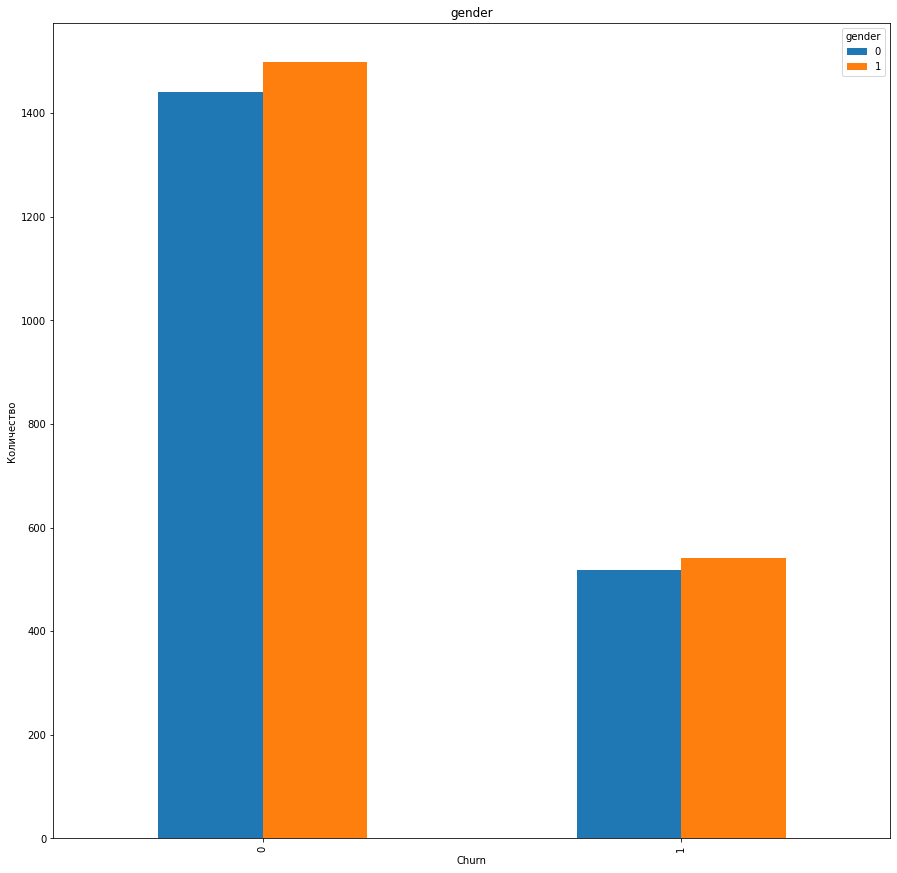

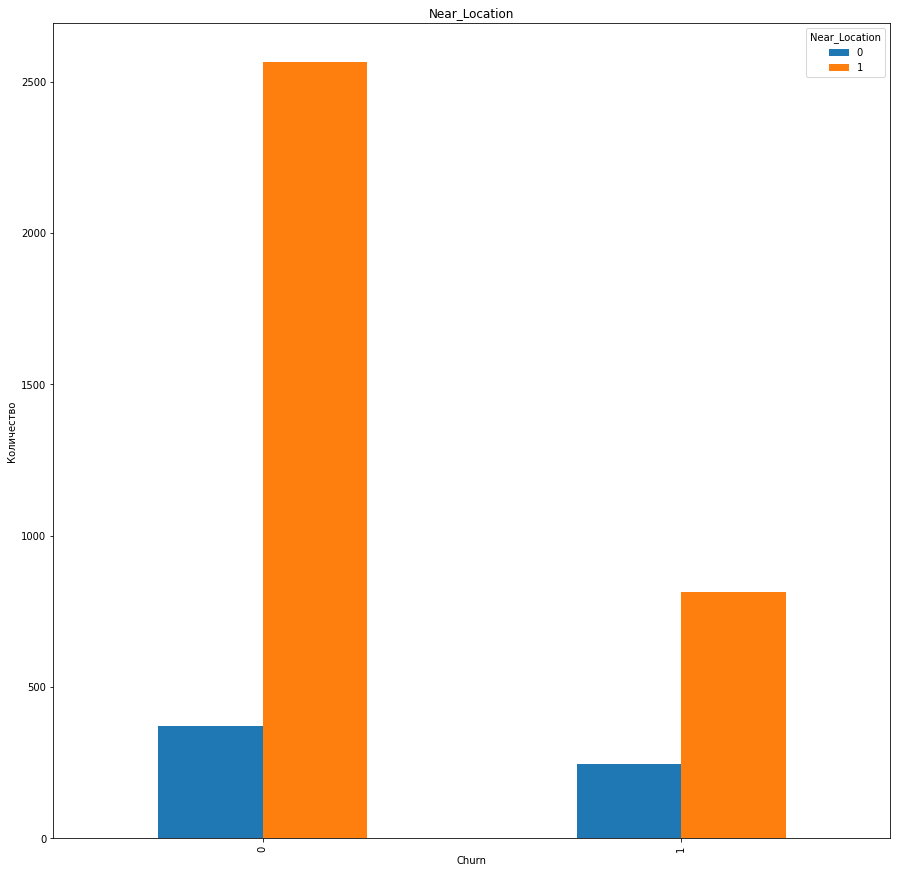

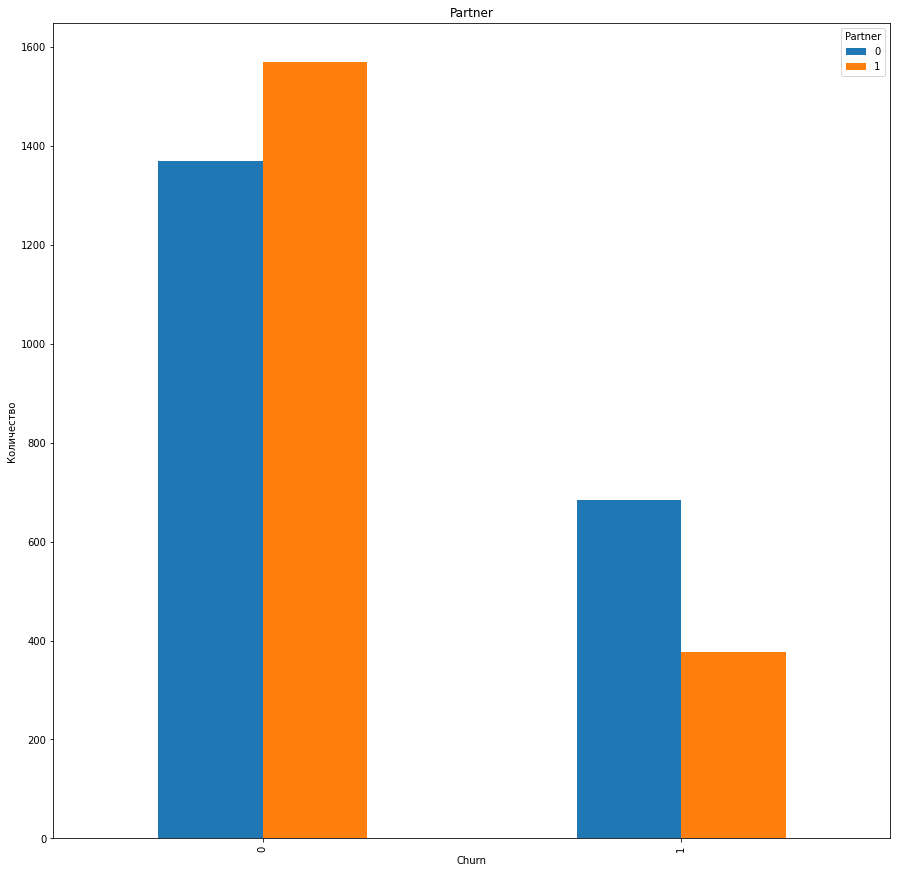

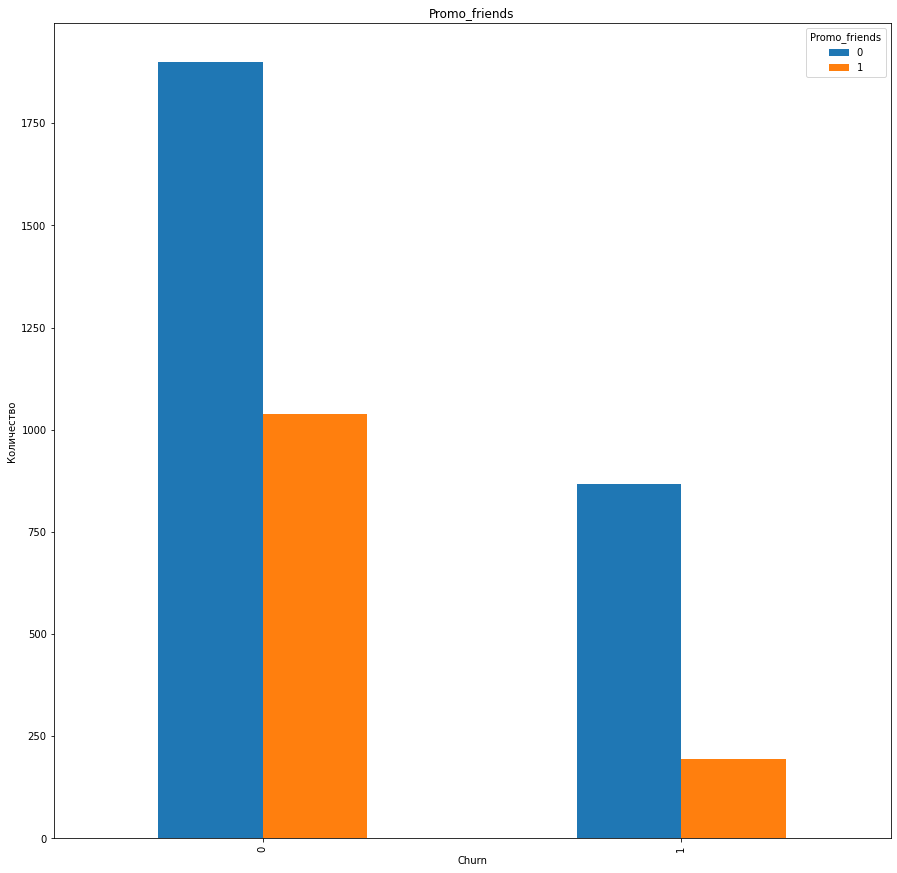

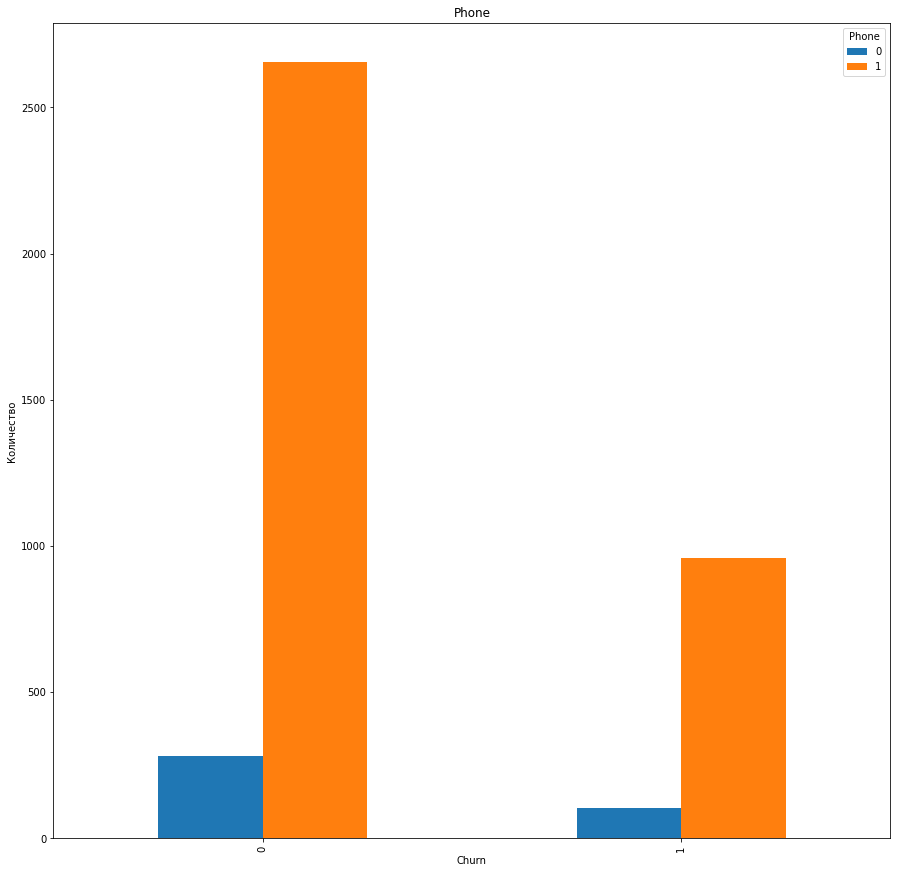

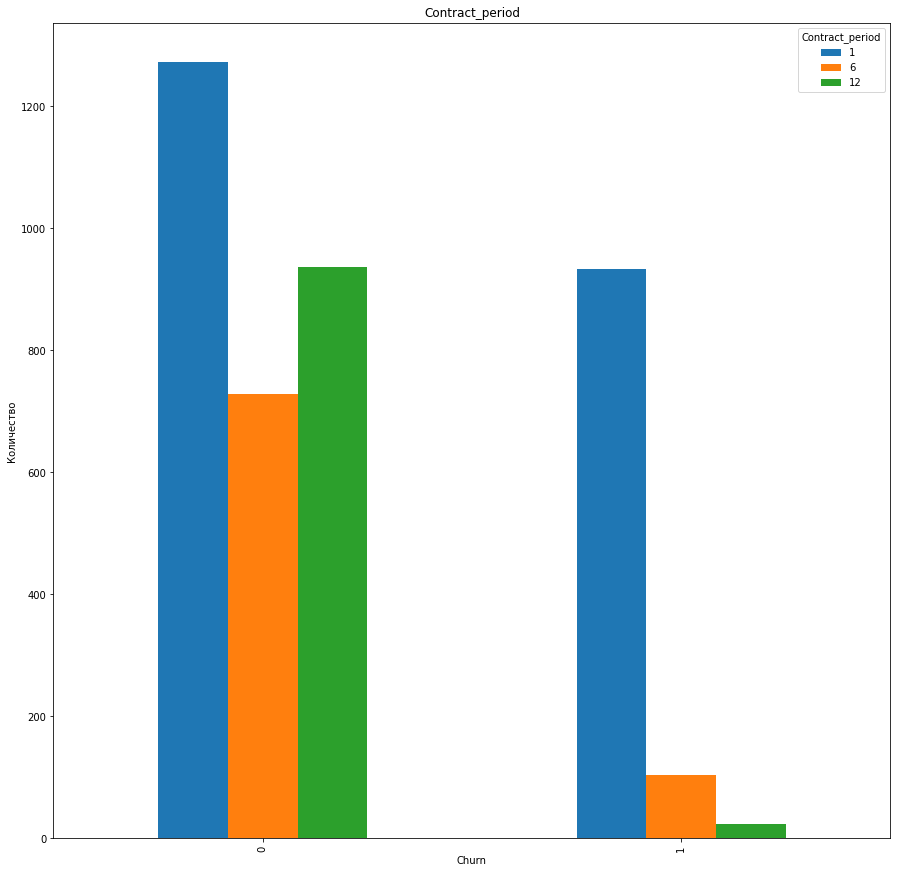

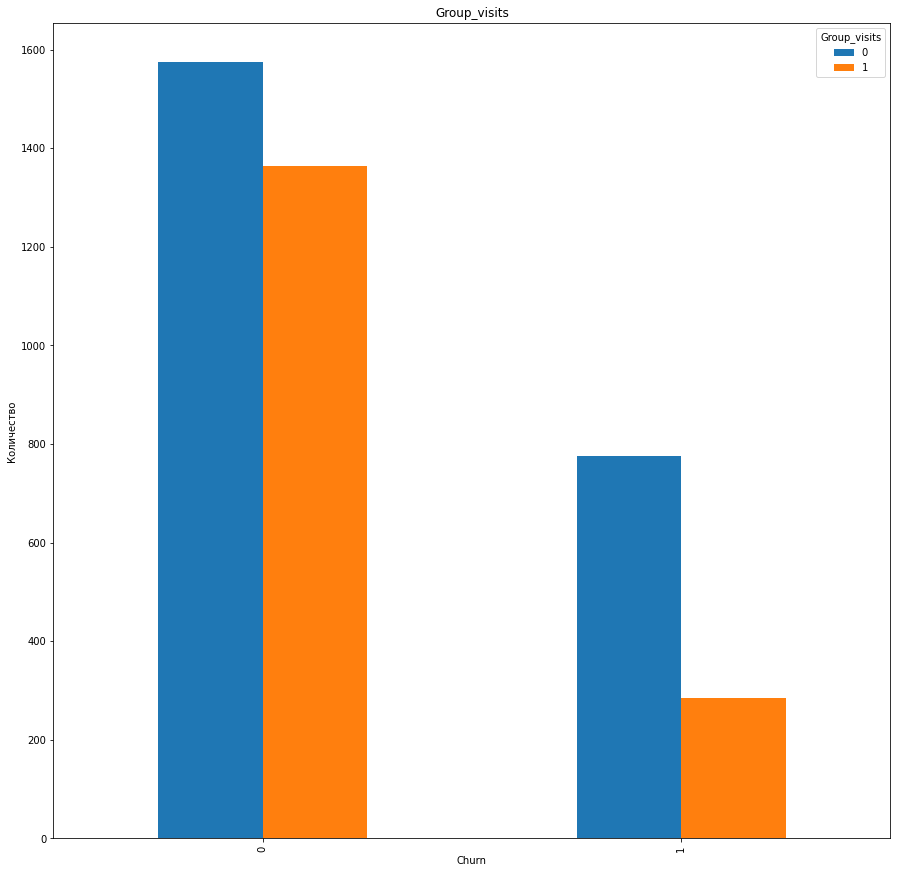

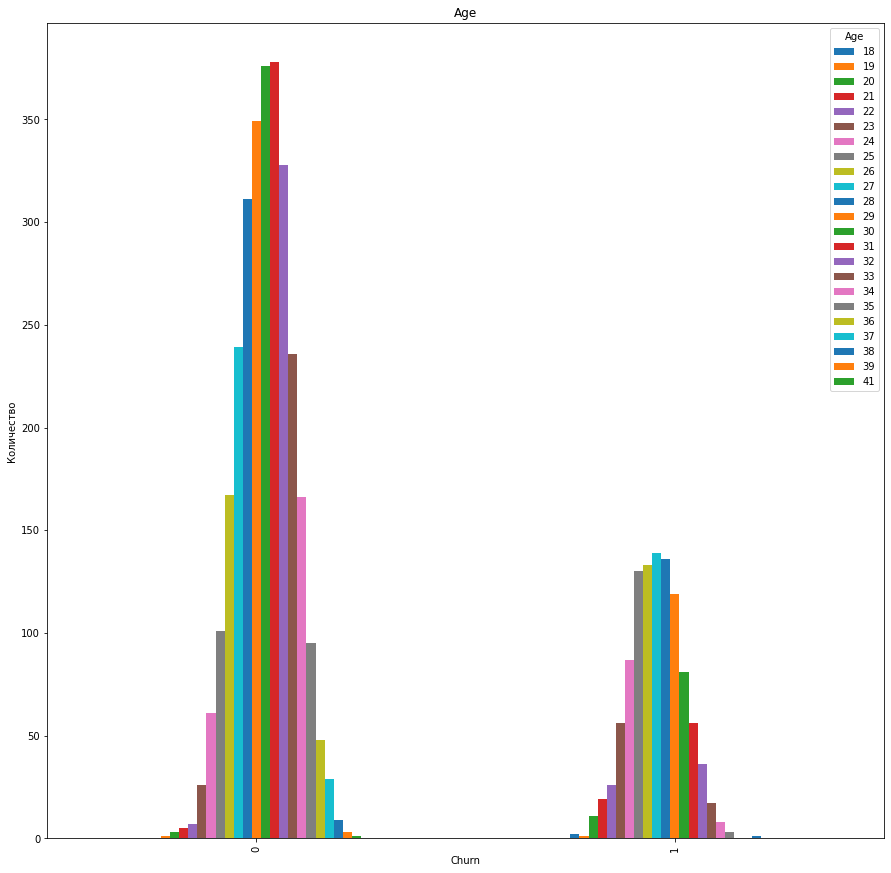

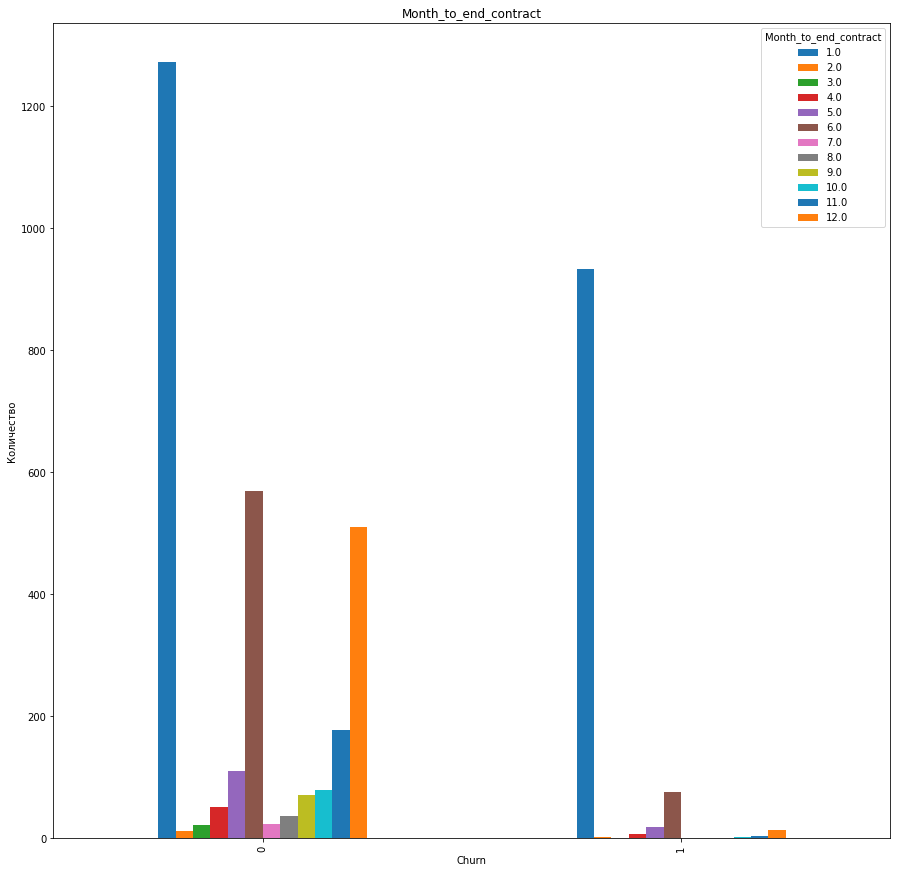

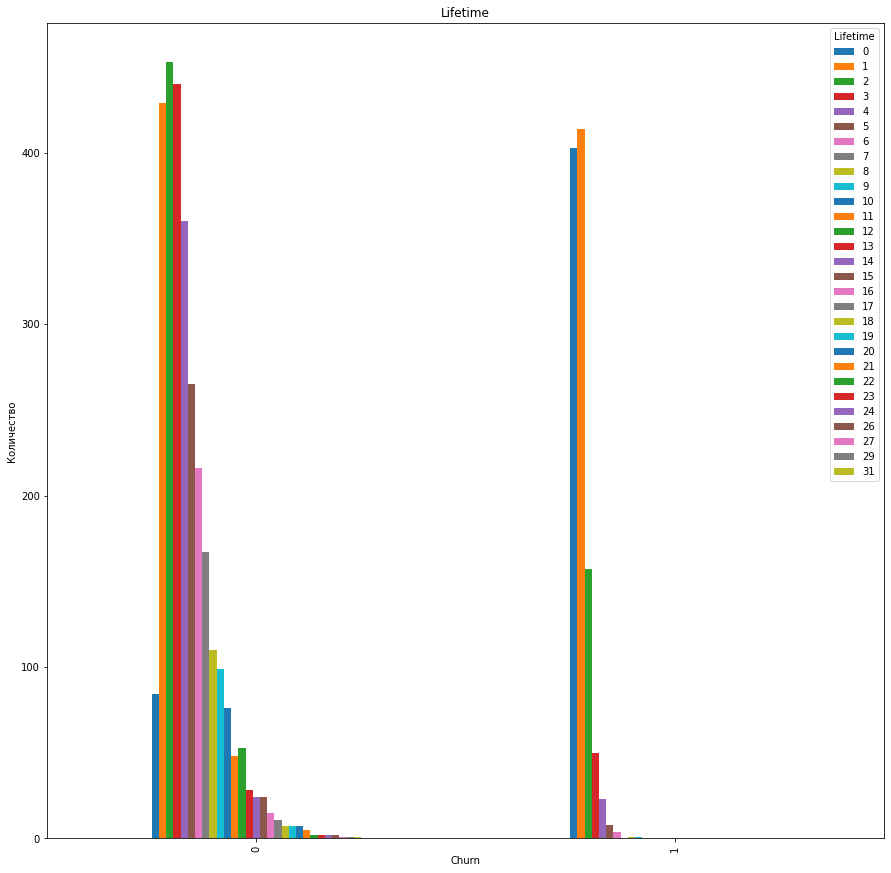

In [ ]:
for col in ['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone', 'Contract_period', \
            'Group_visits', 'Age', 'Month_to_end_contract', 'Lifetime']:

    pd.pivot_table(data, index = 'Churn', columns = col, values = 'Avg_additional_charges_total',  aggfunc = 'count').plot(kind = 'bar')
    plt.title(col)
    plt.ylabel('Количество')

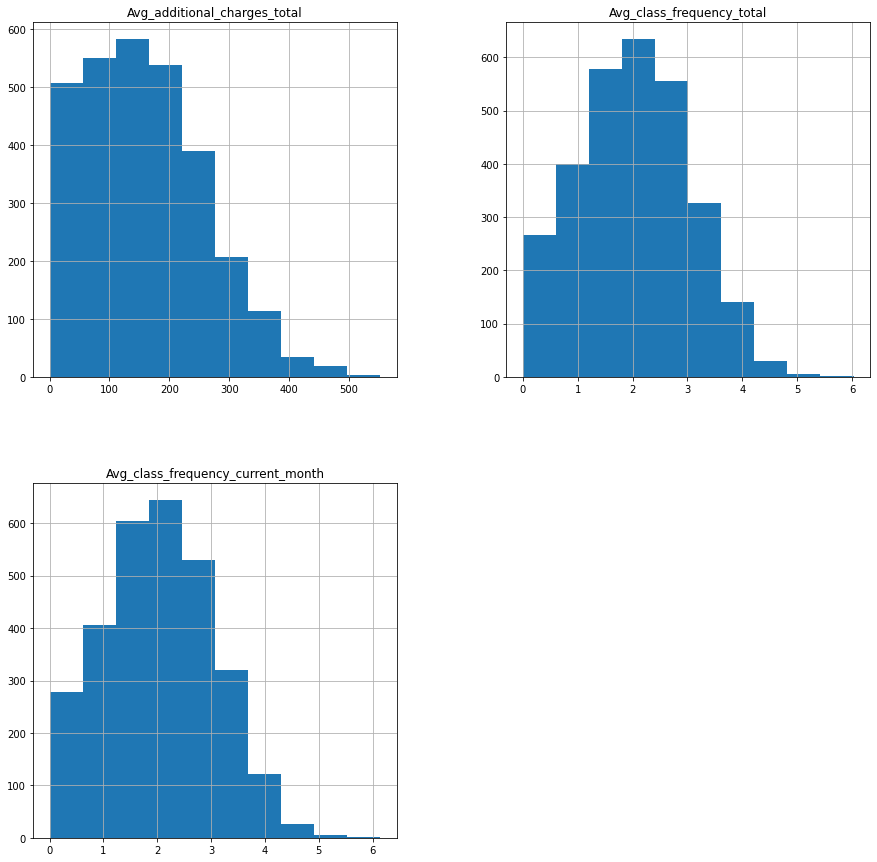

In [ ]:
data.loc[data['Churn'] == 0, ['Avg_additional_charges_total', 'Avg_class_frequency_total', 'Avg_class_frequency_current_month']].hist();

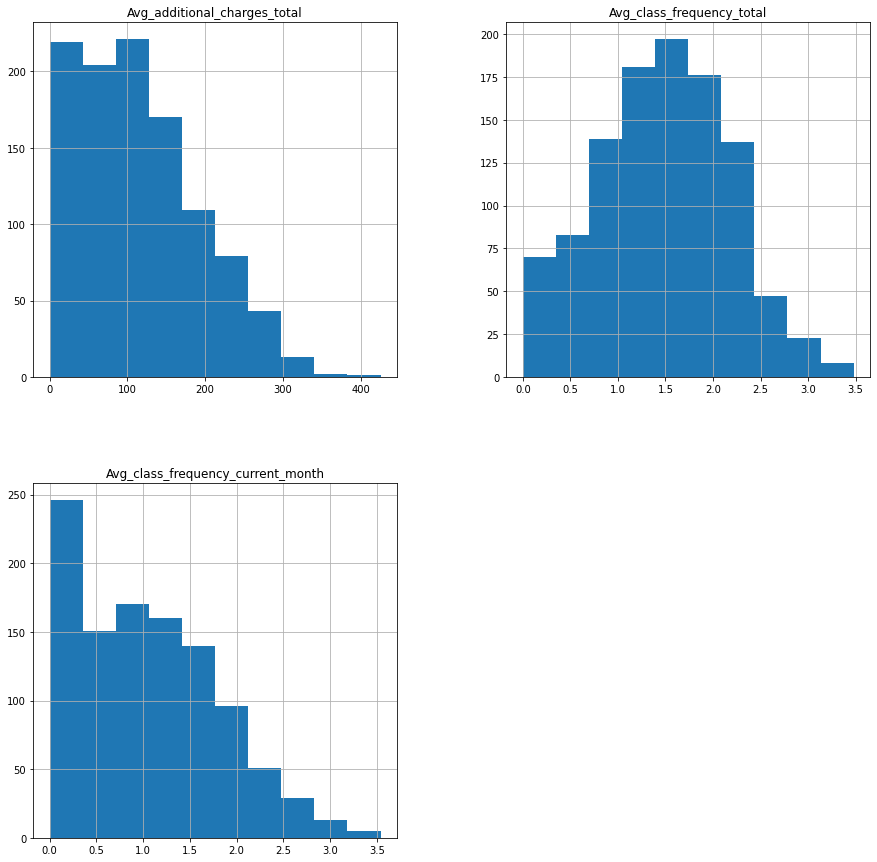

In [ ]:
data.loc[data['Churn'] == 1, ['Avg_additional_charges_total', 'Avg_class_frequency_total', 'Avg_class_frequency_current_month']].hist();

Если сравнить графики попарно, то можно заметить некоторую разницу показателей между группами:
1. В доле тех, кто пинул клуб четверь приезжала из другого района, среди тех, кто стабильно ходит на занятия их доля составляет чуть меньше одной пятой
2. В первой группе подавляющее большинство посещает клуб по партнерской программе, во второй группе их около трети
3. В числе постоянных посетителей доля приведенных по акции "приведи друга" составляет около трети, в ушедших около одной пятой
4. В первой группе посетителей у большинства абонемент не на один месяц, во второй в основном одномесячный абонемент
5. Постоянные посетители чаще посещают групповые занятия, чем ушедшие
6. Возраст тех, кто стабильно ходит на занятия около 30 лет, те же, кто потерял интерес к тренировкам немного младше. Здесь могут быть определенные причины - у молодых людей меньше времени на тренировки, чаще всего они учатся и работают, а также причиной может быть стоимость абонемента, ведь как правило доход молодых людей ниже, чем у взрослых. Кроме того, как раз взрослые могут иметь возможность посещать тренировки по партнерской программе, в то время как студенты и молодые специалисты такой возможности могут не иметь
7. Количество дней до окончания действия абонемента напрямую связано с наличием того или иного вида абонемента у каждой группы
8. Продолжительность сотрудничества у постоянных посетителей более полугода, у покинувших клуб - не более 6 месяцев
9. Частота посещений в неделю у постоянных клиентов в 2 раза выше, чем у ушедших
10. Среди тех, кто покинул клуб очень высокая доля людей, которые в этом месяце ни разу не посещали зал, в то вермя как постоянные клиенты ходят стабильно около 2 раз в неделю

In [ ]:
data.corr()

gender  Near_Location   Partner  \
gender                             1.000000       0.006699 -0.010463   
Near_Location                      0.006699       1.000000 -0.005119   
Partner                           -0.010463      -0.005119  1.000000   
Promo_friends                     -0.005033       0.210964  0.451960   
Phone                             -0.008542      -0.015763  0.009970   
Contract_period                    0.000502       0.150233  0.306166   
Group_visits                       0.017879       0.154728  0.022710   
Age                                0.013807       0.058358  0.047480   
Avg_additional_charges_total      -0.009334       0.040761  0.022941   
Month_to_end_contract             -0.001281       0.143961  0.294632   
Lifetime                           0.013579       0.070921  0.061229   
Avg_class_frequency_total          0.014620       0.043127  0.024938   
Avg_class_frequency_current_month  0.009156       0.062664  0.045561   
Churn                              0.000708      -0.128098 -0.157986   

                                   Promo_friends     Phone  Contract_period  \
gender                                 -0.005033 -0.008542         0.000502   
Near_Location                           0.210964 -0.015763         0.150233   
Partner                                 0.451960  0.009970         0.306166   
Promo_friends                           1.000000  0.001982         0.244552   
Phone                                   0.001982  1.000000        -0.006893   
Contract_period                         0.244552 -0.006893         1.000000   
Group_visits                            0.120170 -0.010099         0.169991   
Age                                     0.050113 -0.011403         0.138249   
Avg_additional_charges_total            0.036898  0.009279         0.111445   
Month_to_end_contract                   0.239553 -0.011196         0.973064   
Lifetime                                0.072721 -0.018801         0.170725   
Avg_class_frequency_total               0.028063  0.008340         0.096211   
Avg_class_frequency_current_month       0.053768  0.013375         0.159407   
Churn                                  -0.162233 -0.001177        -0.389984   

                                   Group_visits       Age  \
gender                                 0.017879  0.013807   
Near_Location                          0.154728  0.058358   
Partner                                0.022710  0.047480   
Promo_friends                          0.120170  0.050113   
Phone                                 -0.010099 -0.011403   
Contract_period                        0.169991  0.138249   
Group_visits                           1.000000  0.080934   
Age                                    0.080934  1.000000   
Avg_additional_charges_total           0.032079  0.080240   
Month_to_end_contract                  0.163703  0.134511   
Lifetime                               0.075853  0.164693   
Avg_class_frequency_total              0.056695  0.119953   
Avg_class_frequency_current_month      0.075923  0.183095   
Churn                                 -0.175325 -0.404735   

                                   Avg_additional_charges_total  \
gender                                                -0.009334   
Near_Location                                          0.040761   
Partner                                                0.022941   
Promo_friends                                          0.036898   
Phone                                                  0.009279   
Contract_period                                        0.111445   
Group_visits                                           0.032079   
Age                                                    0.080240   
Avg_additional_charges_total                           1.000000   
Month_to_end_contract                                  0.113958   
Lifetime                                               0.079028   
Avg_class_frequency_total                         

Особой разницы в корелляции признаков в двух группах не имеется. Обнаружены 4 признака, которые попарно коррелируют друг в другом. Это частота посещений в текущем месяце с общей частотой посещений и дней, оставшихсся до окончания абонемента с длительностью абонемента.

Предварительный анализ данных выявил некоторые закономерности среди клиентов. Есть примерное представление о возрасте клиентов, сроке действия их абонемента, по каким программам они пришли и другие.

## Шаг 3. Построить модель прогнозирования оттока клиентов

In [ ]:
X = data.drop(['Month_to_end_contract', 'Avg_class_frequency_current_month', 'Churn'], axis = 1) # отберем метрики для построения прогноза, избавимся от коррелирующих показателей
y = data['Churn']      # выберем целевую переменную
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) # разделим данные на обучающую и валидационную

In [ ]:
scaler = StandardScaler() # стандартизируем данные
scaler.fit(X_train)
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

In [ ]:
model = LogisticRegression(solver='liblinear', random_state=0)
model.fit(X_train_st, y_train)
predictions = model.predict(X_test_st)
probabilities = model.predict_proba(X_test_st)[:,1]

print('Метрики для логистической регрессии')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, predictions)))
print('ROC_AUC: {:.2f}\n'.format(roc_auc_score(y_test, probabilities)))

tree_model = DecisionTreeClassifier(random_state=0)
tree_model.fit(X_train_st, y_train)
tree_predictions = tree_model.predict(X_test_st)
tree_probabilities = tree_model.predict_proba(X_test_st)[:, 1]

print('Метрики для дерева принятия решения')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, tree_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, tree_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, tree_predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, tree_predictions)))
print('ROC_AUC: {:.2f}'.format(roc_auc_score(y_test, tree_predictions)))

Метрики для логистической регрессии
Accuracy: 0.90
Precision: 0.79
Recall: 0.81
F1: 0.80
ROC_AUC: 0.95

Метрики для дерева принятия решения
Accuracy: 0.83
Precision: 0.64
Recall: 0.71
F1: 0.67
ROC_AUC: 0.79


Дерево принятия решений показывает очень слабые срезультаты по сравнению с линейной регрессией, стоит выбрать более мощный алгоритм для работы с имеющимися метриками.

## Шаг 4. Провести кластеризацию клиентов

В первую очередь разберемся, сколько у нас имеется групп клиентов, о которых, вероятно, мы не подозреваем.

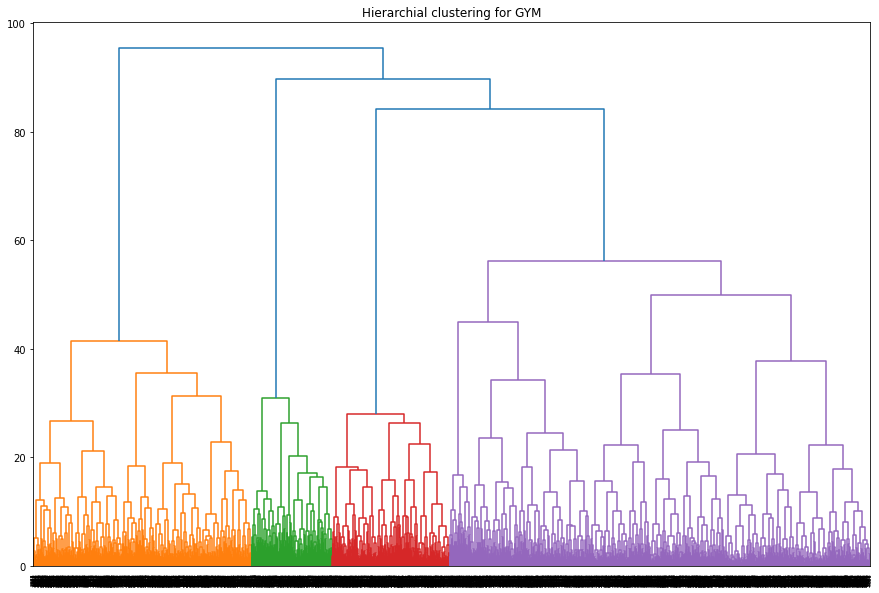

In [ ]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

linked = linkage(X_sc, method = 'ward')
plt.figure(figsize=(15, 10))
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering for GYM')
plt.show()

Программа предложила 4 группы людей, посещавших фитнес-центр. Фиолетовый кластер оказался довольно объемным, поэтому будем считать его за 2 кластера и разделим данные на 5 кластеров.

In [ ]:
def show_clusters_on_plot(df, x_name, y_name, cluster_name):
    plt.figure(figsize=(15, 15))
    sns.scatterplot(
        df[x_name], df[y_name], hue=df[cluster_name], palette='Paired'
    )
    plt.title('{} vs {}'.format(x_name, y_name))
    plt.show()


# задаём модель k_means с числом кластеров 4 и фиксируем значение random_state
km = KMeans(n_clusters = 5, random_state=0)

              gender  Near_Location   Partner  Promo_friends  Phone  \
cluster_km                                                            
0           0.499109       0.000000  0.488414       0.076649    1.0   
1           0.488571       0.995238  0.955238       0.892381    1.0   
2           0.505300       1.000000  0.238516       0.059187    1.0   
3           0.544202       1.000000  0.250287       0.079219    1.0   
4           0.523316       0.862694  0.471503       0.305699    0.0   

            Contract_period  Group_visits        Age  \
cluster_km                                             
0                  3.032086      0.235294  28.721925   
1                  7.660952      0.458095  29.543810   
2                  2.819788      0.000000  28.770318   
3                  4.528129      1.000000  29.536165   
4                  4.777202      0.427461  29.297927   

            Avg_additional_charges_total  Month_to_end_contract  Lifetime  \
cluster_km                      

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


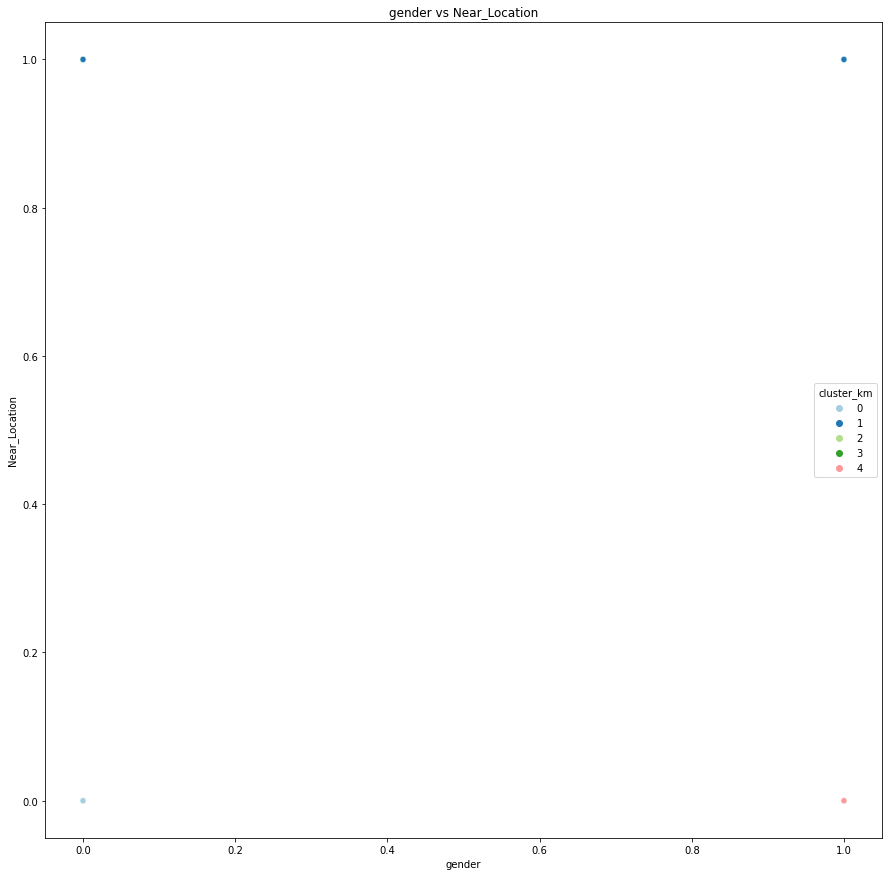

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


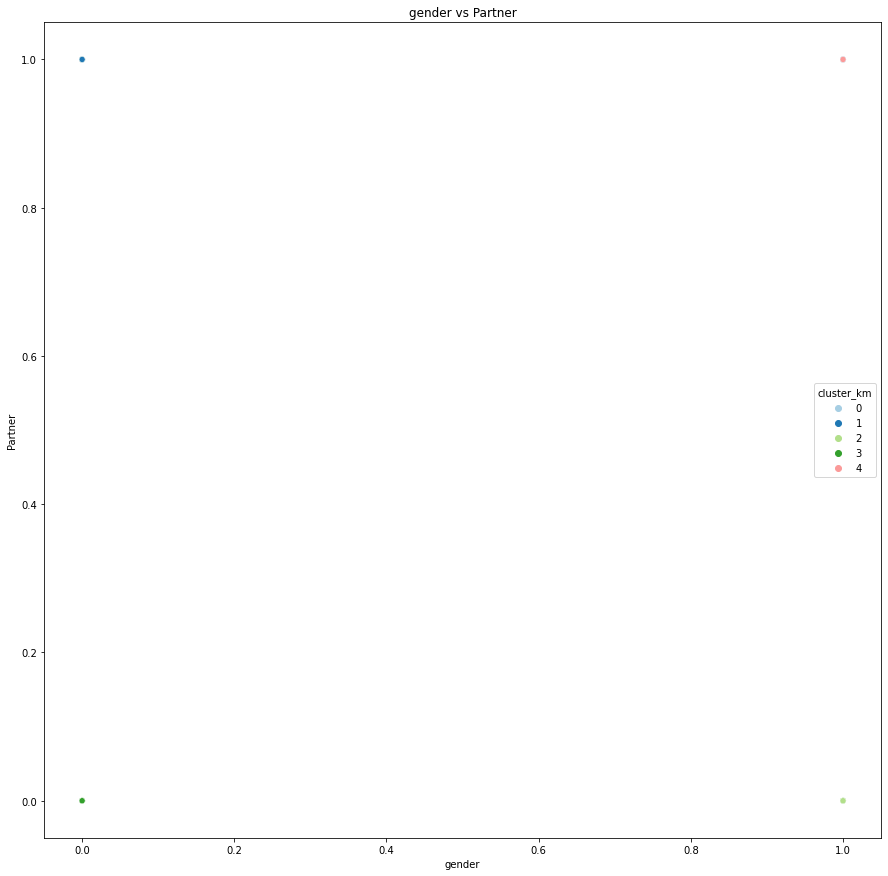

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


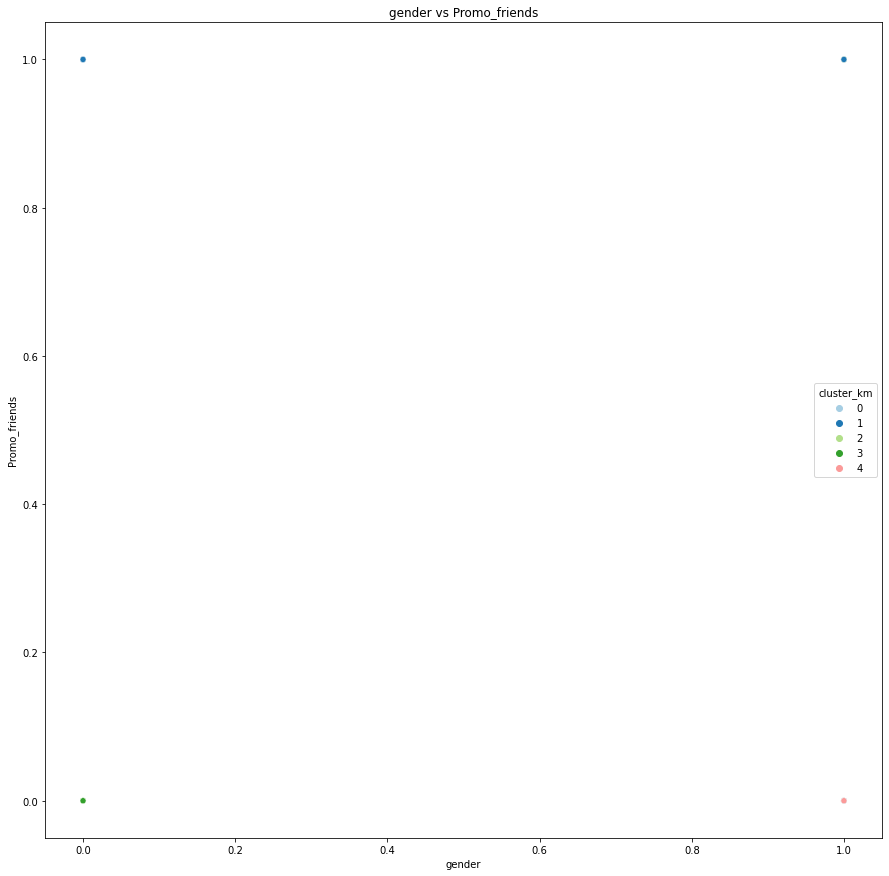

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


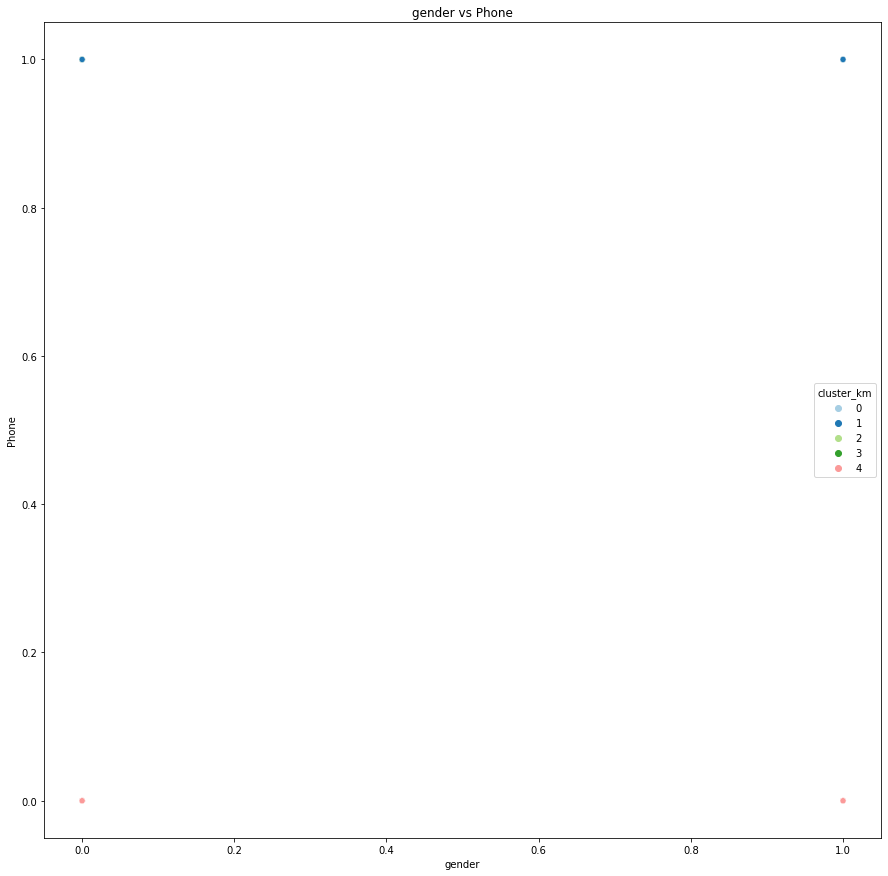

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


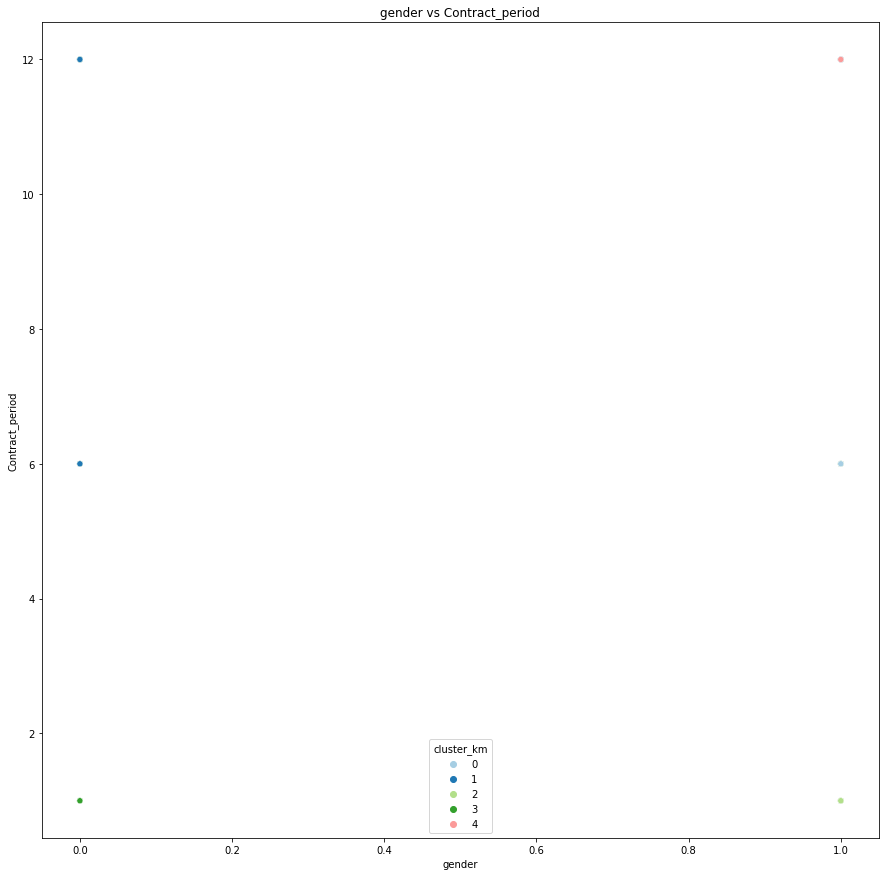

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


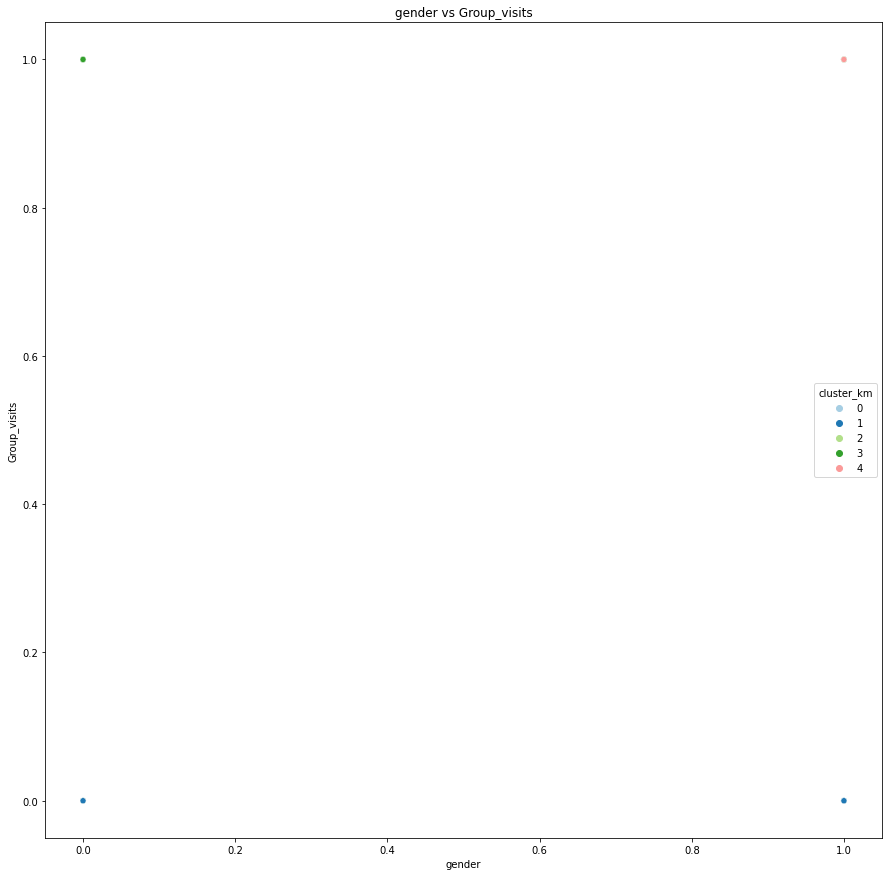

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


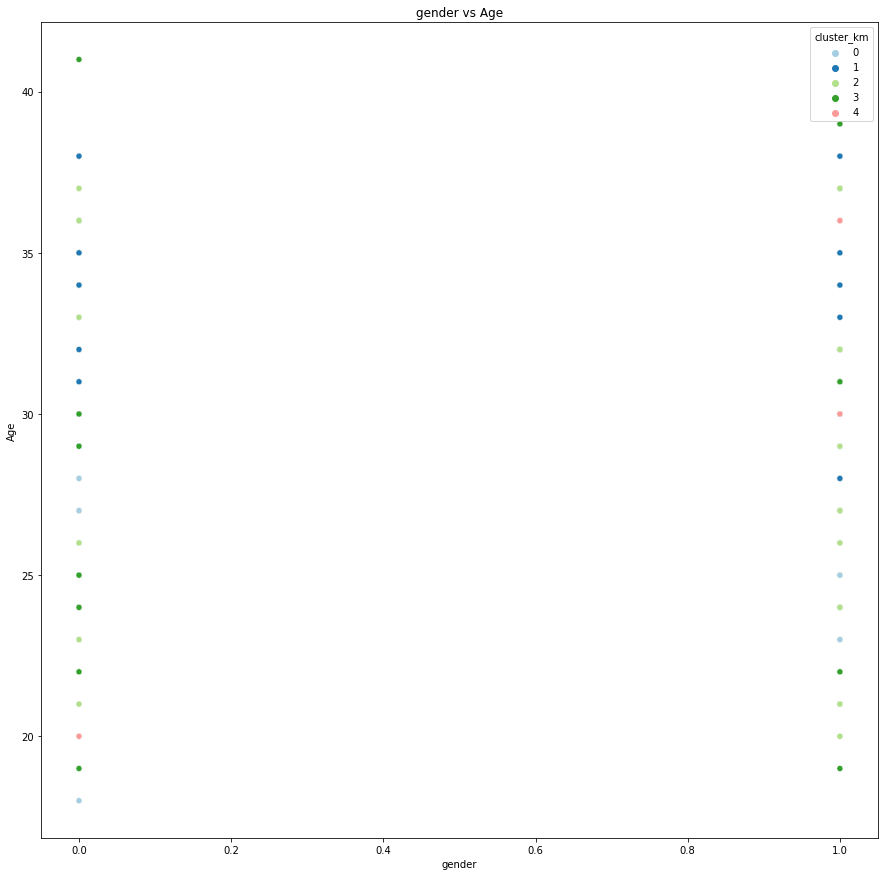

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


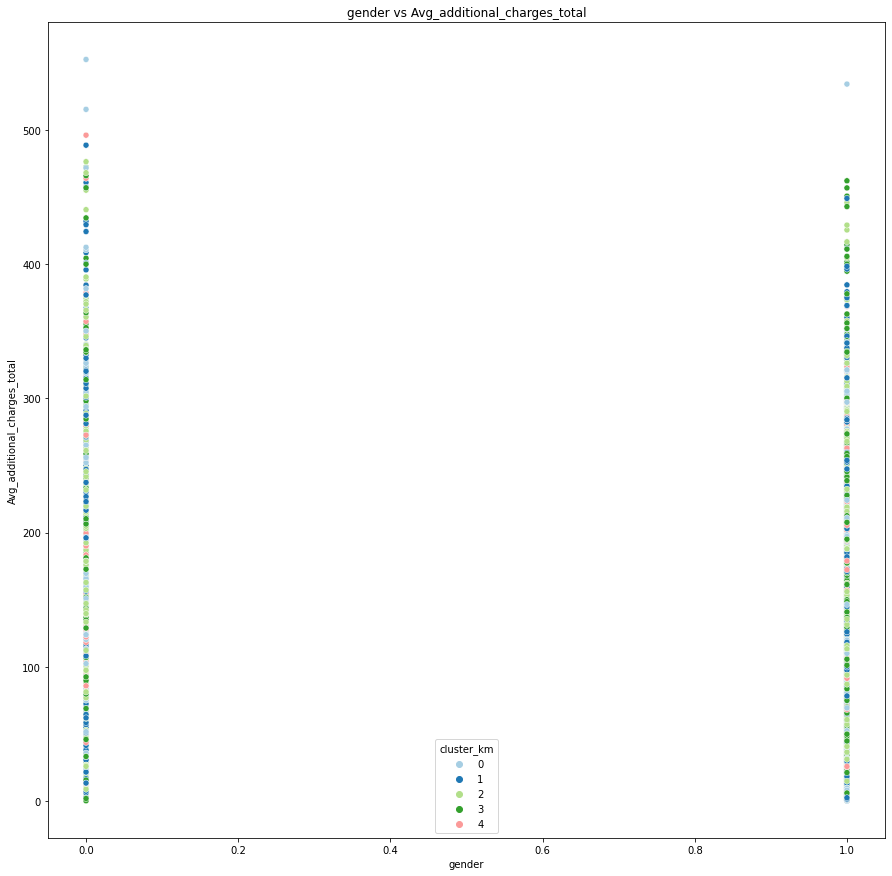

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


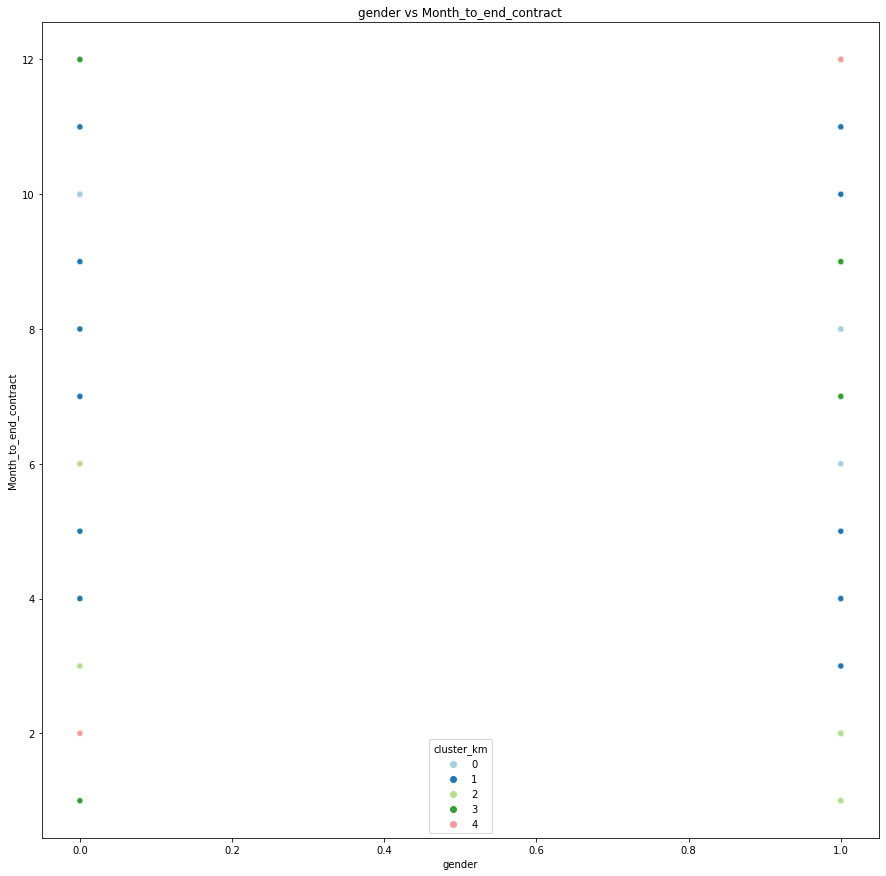

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


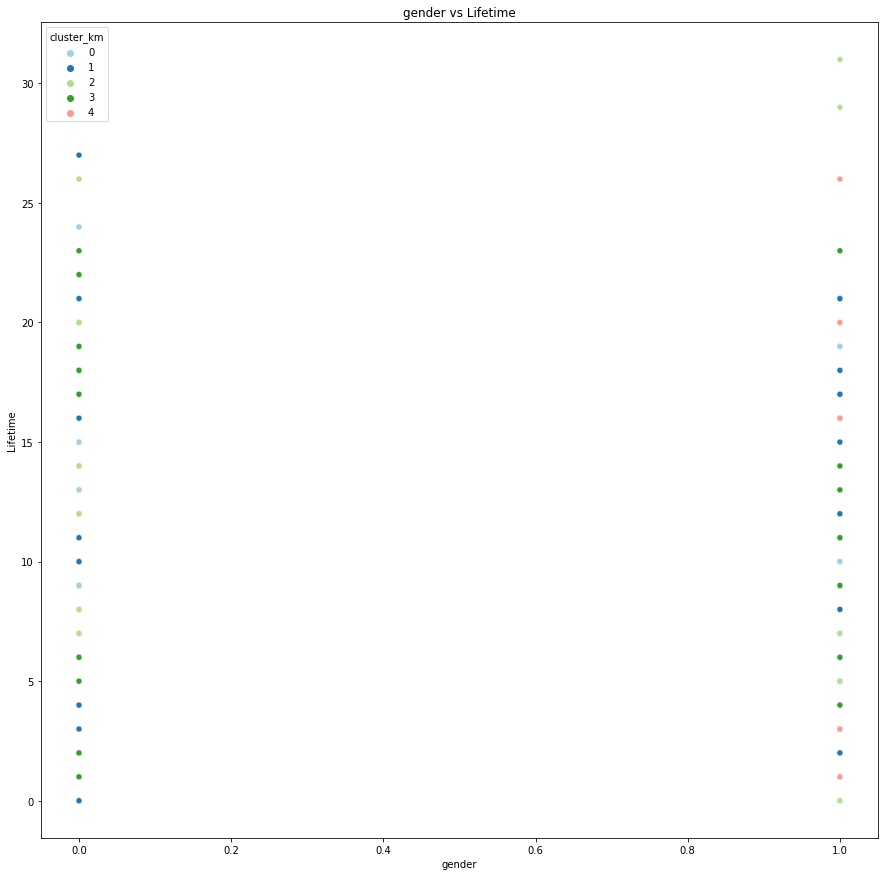

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


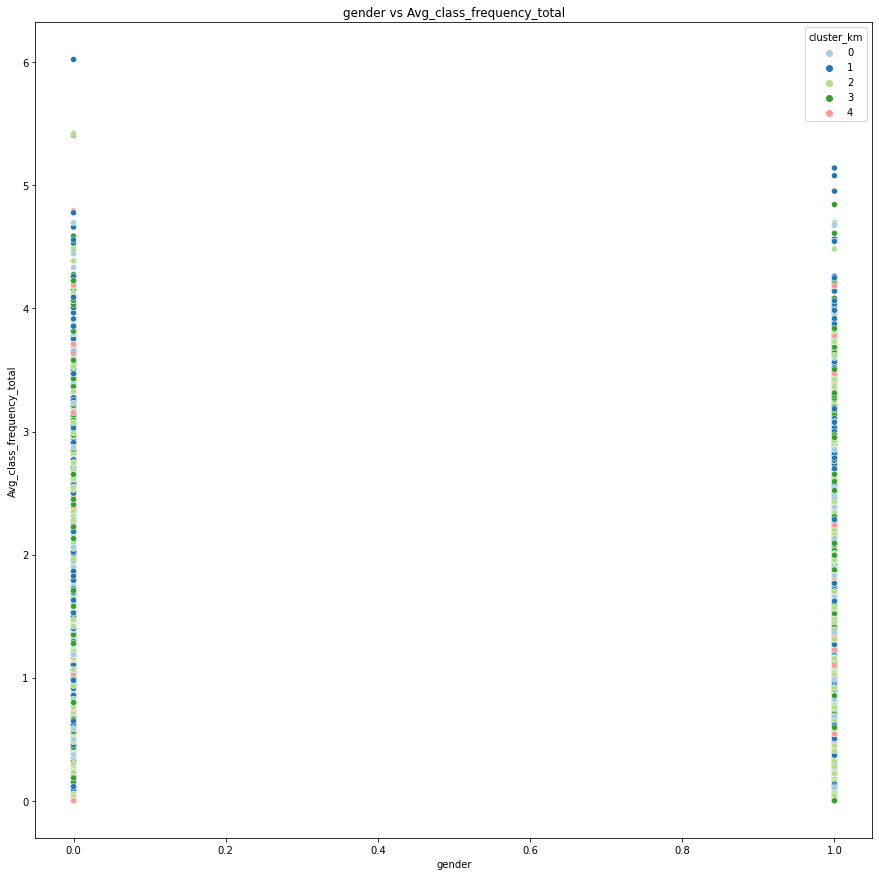

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


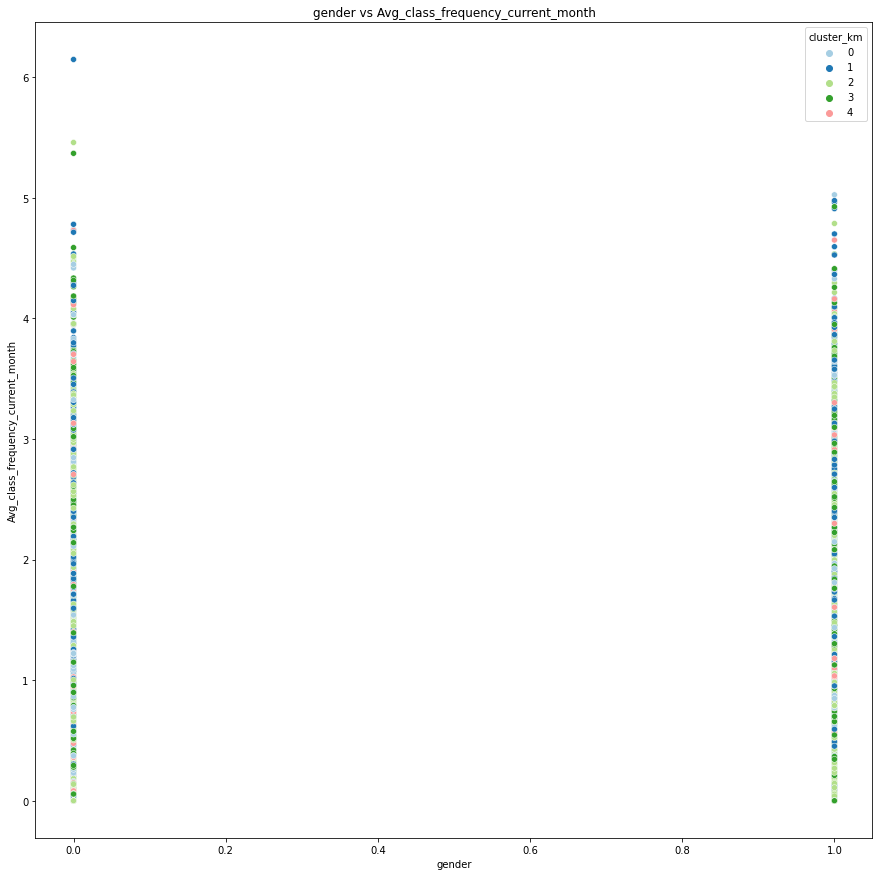

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


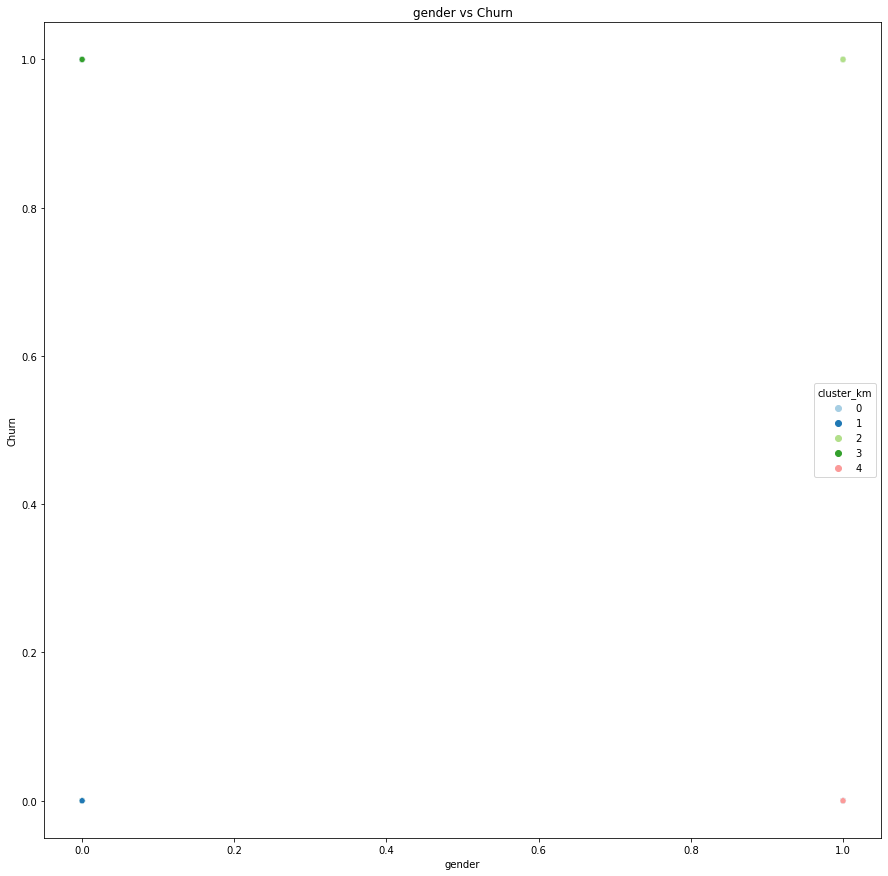

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


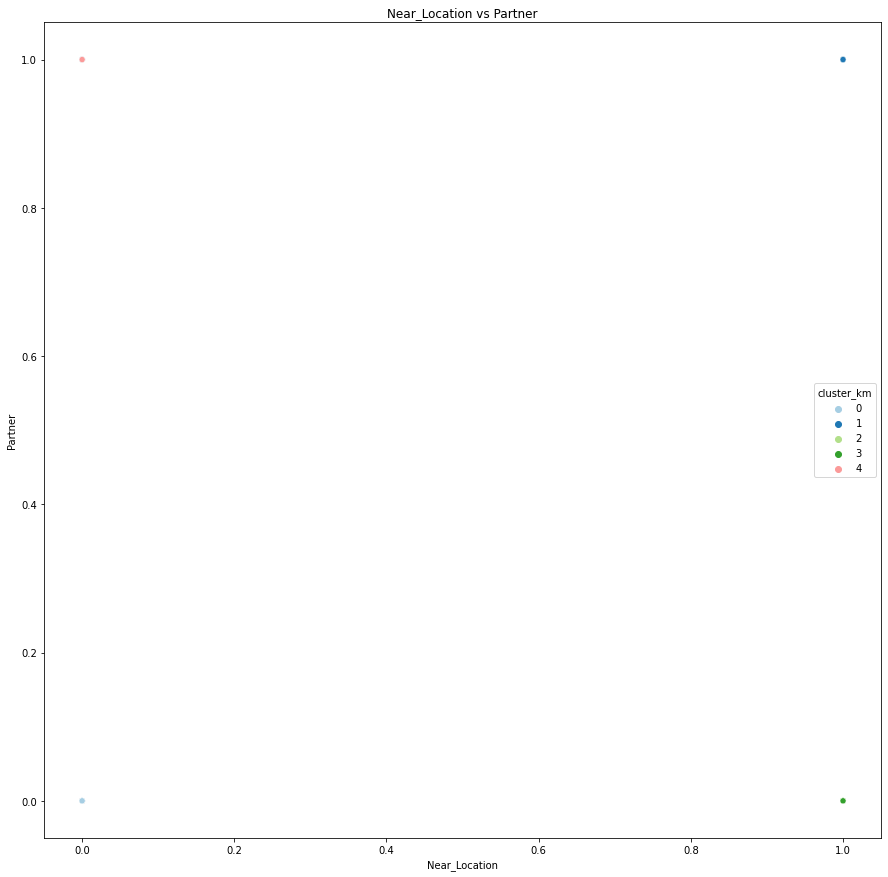

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


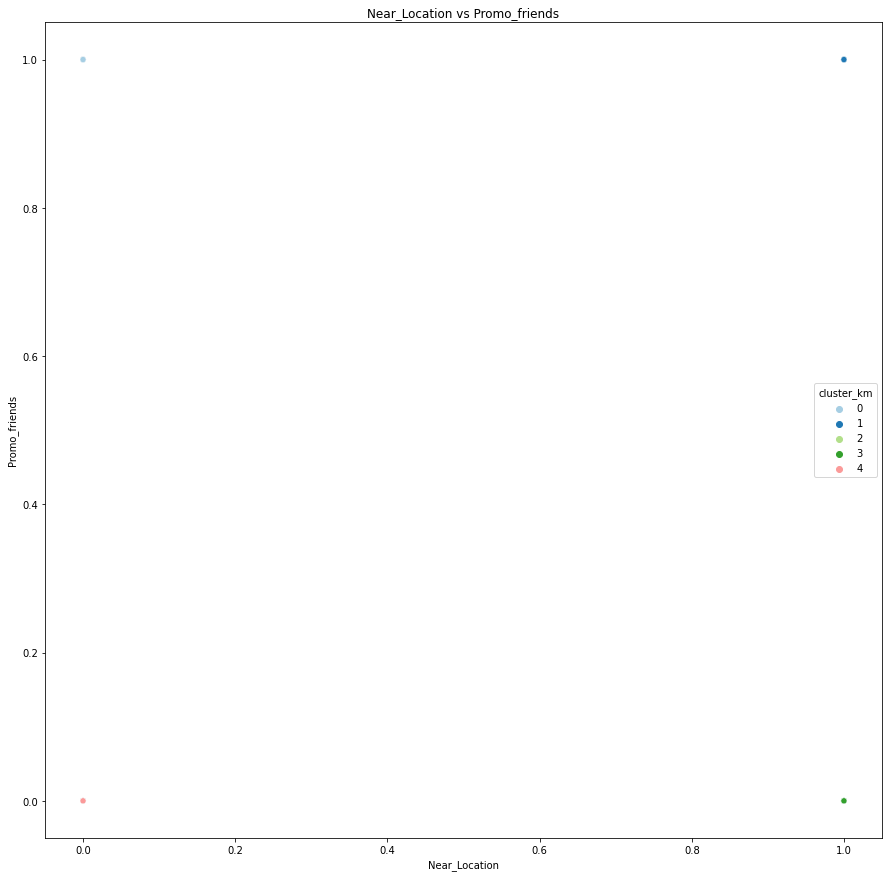

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


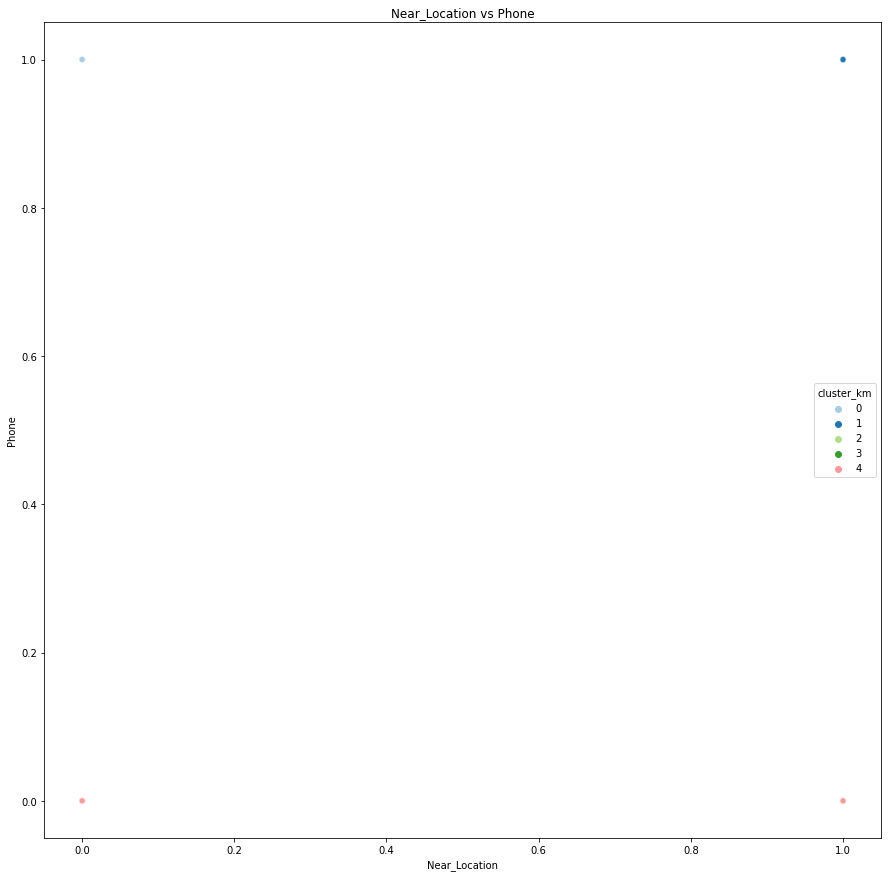

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


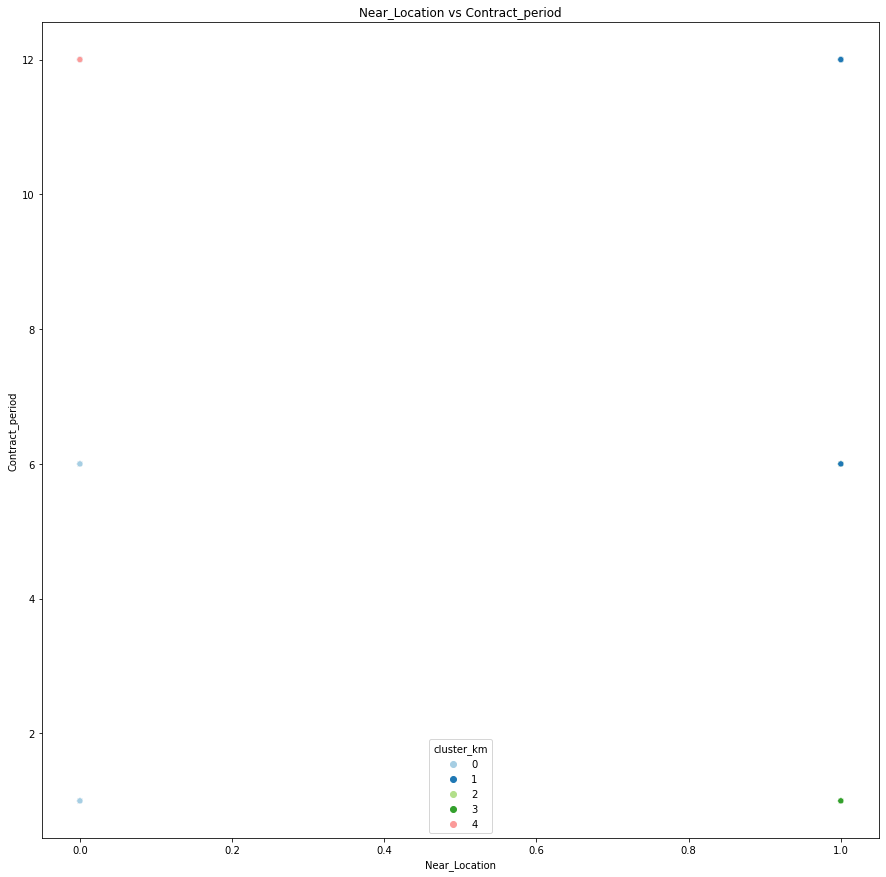

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


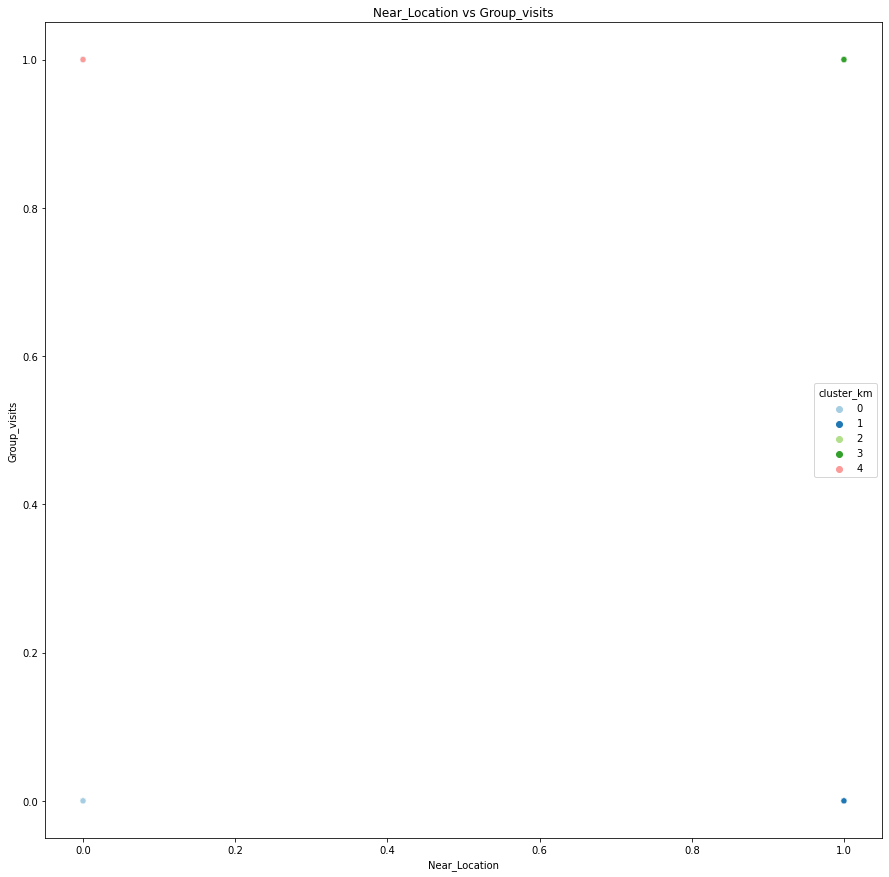

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


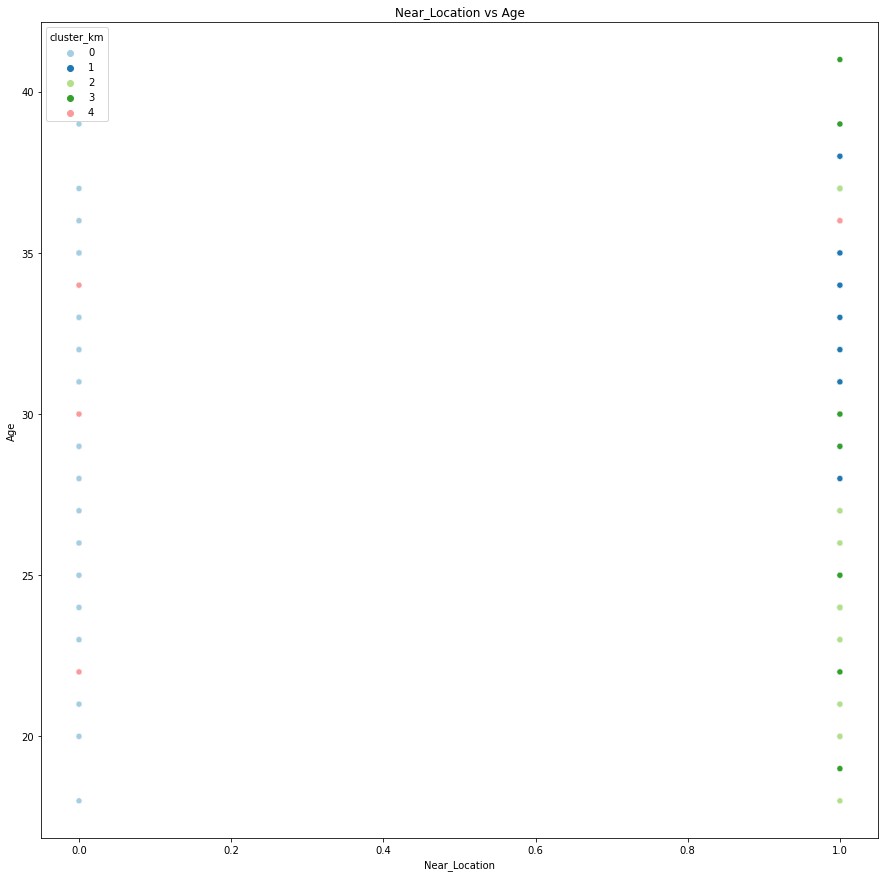

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


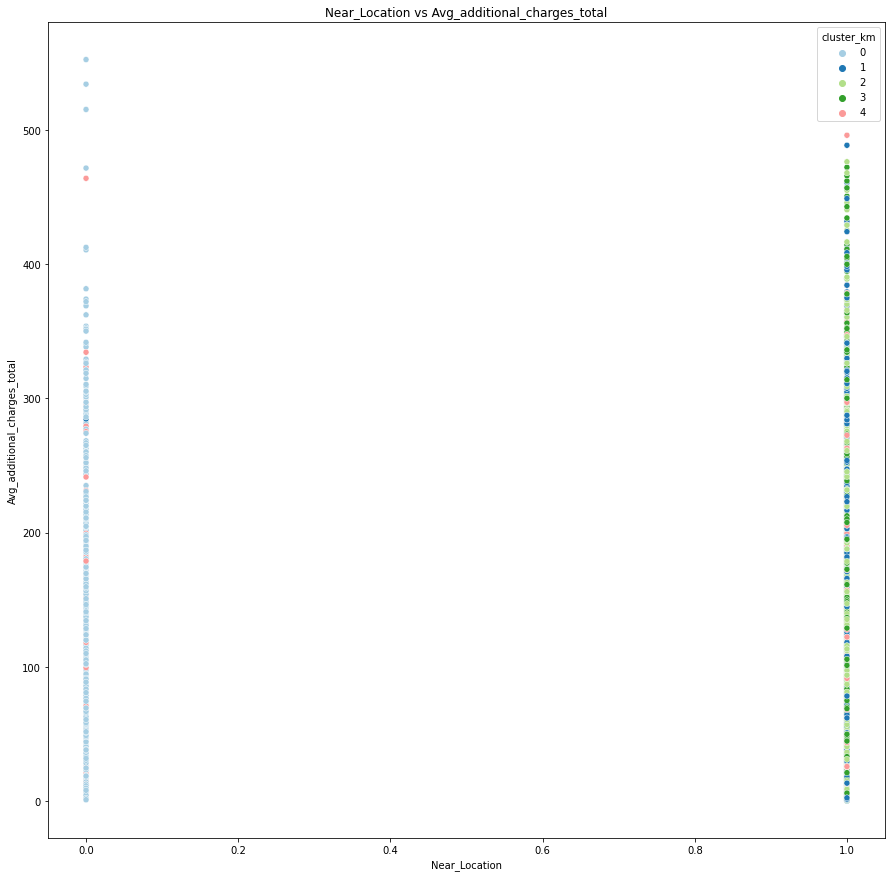

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


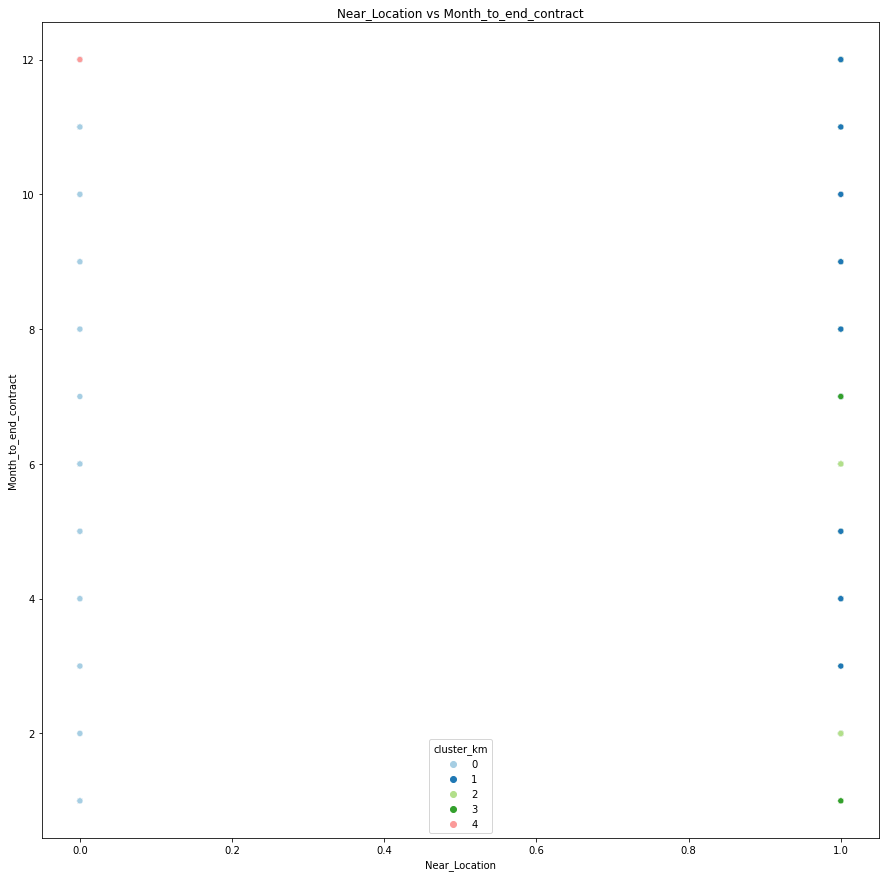

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


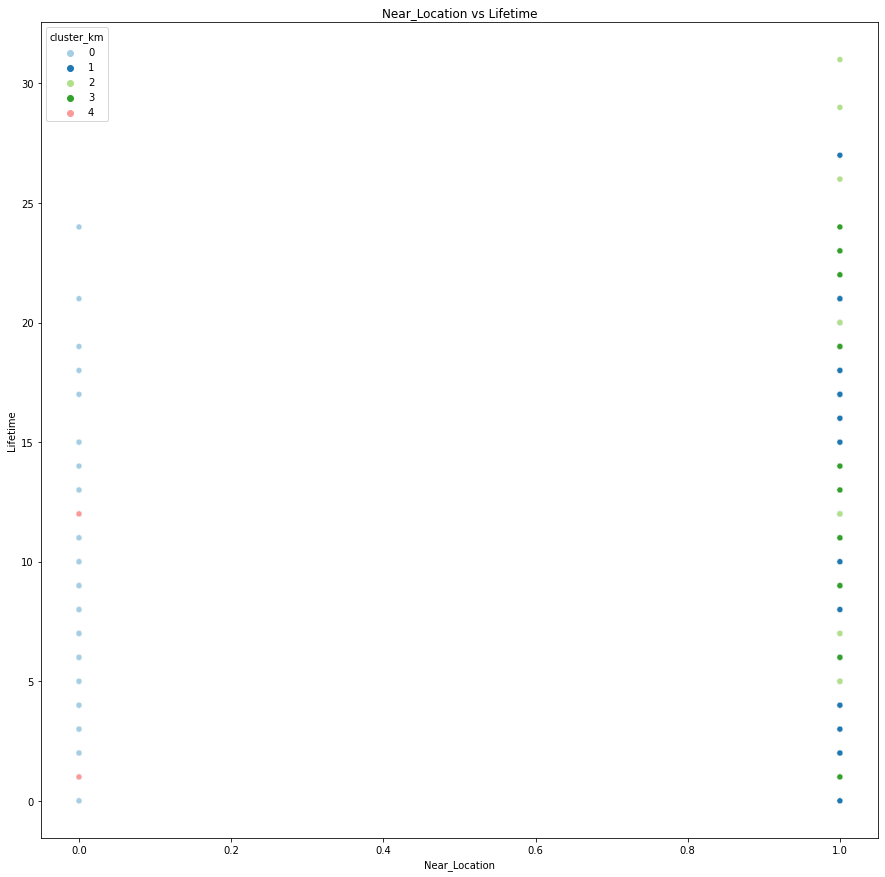

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


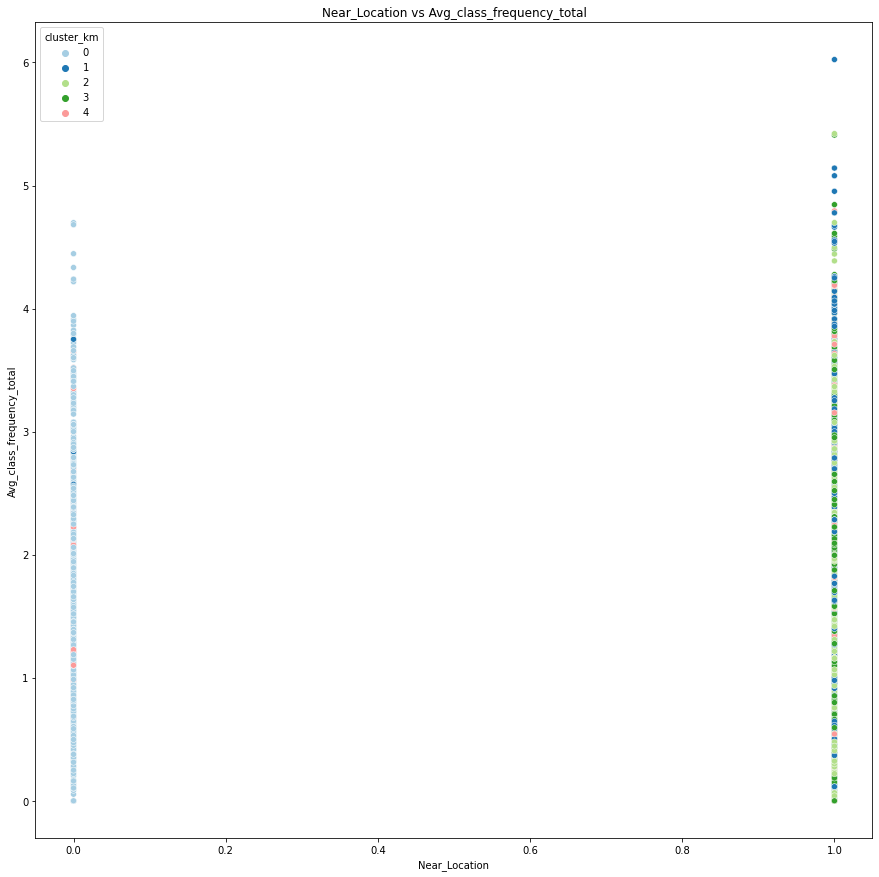

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


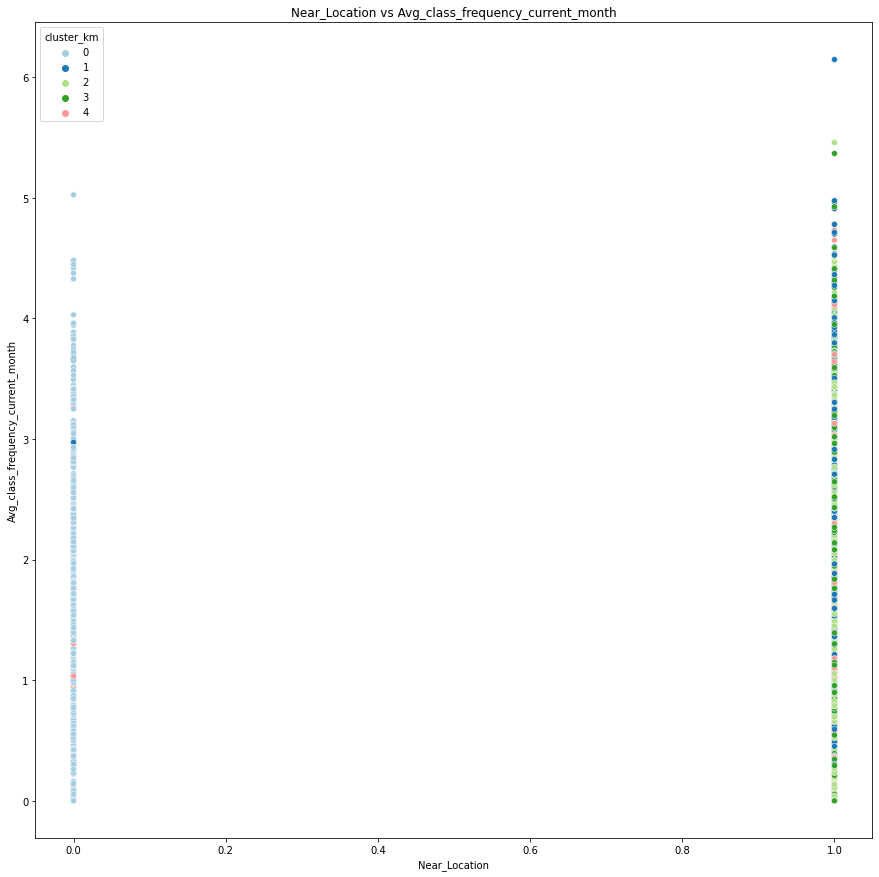

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


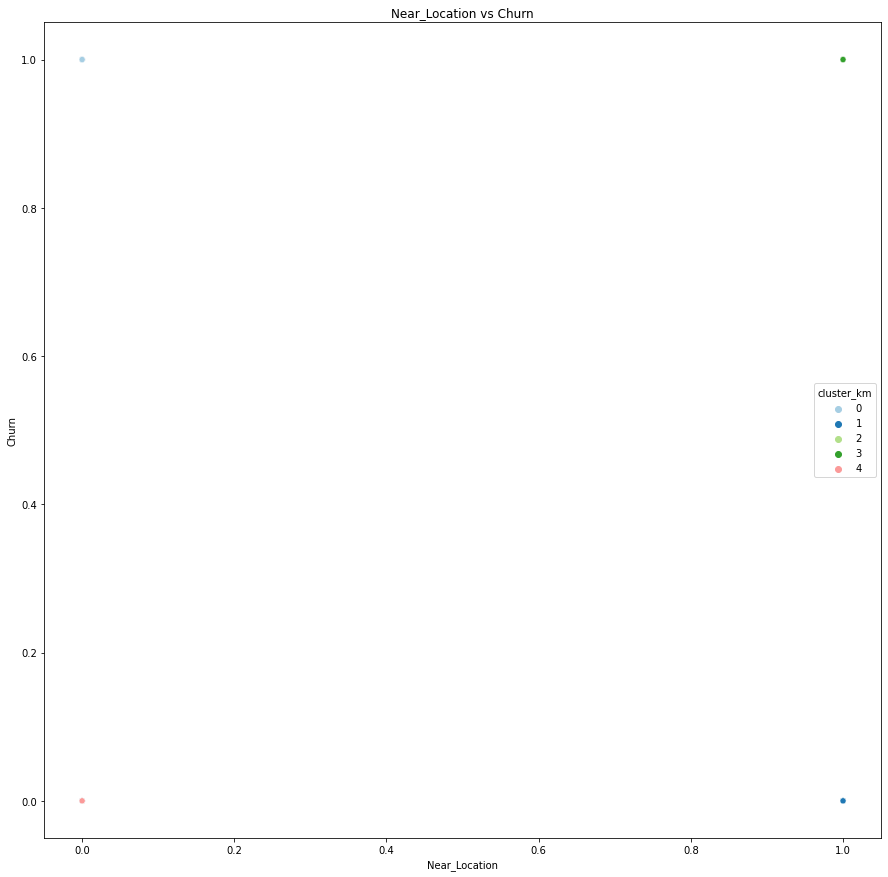

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


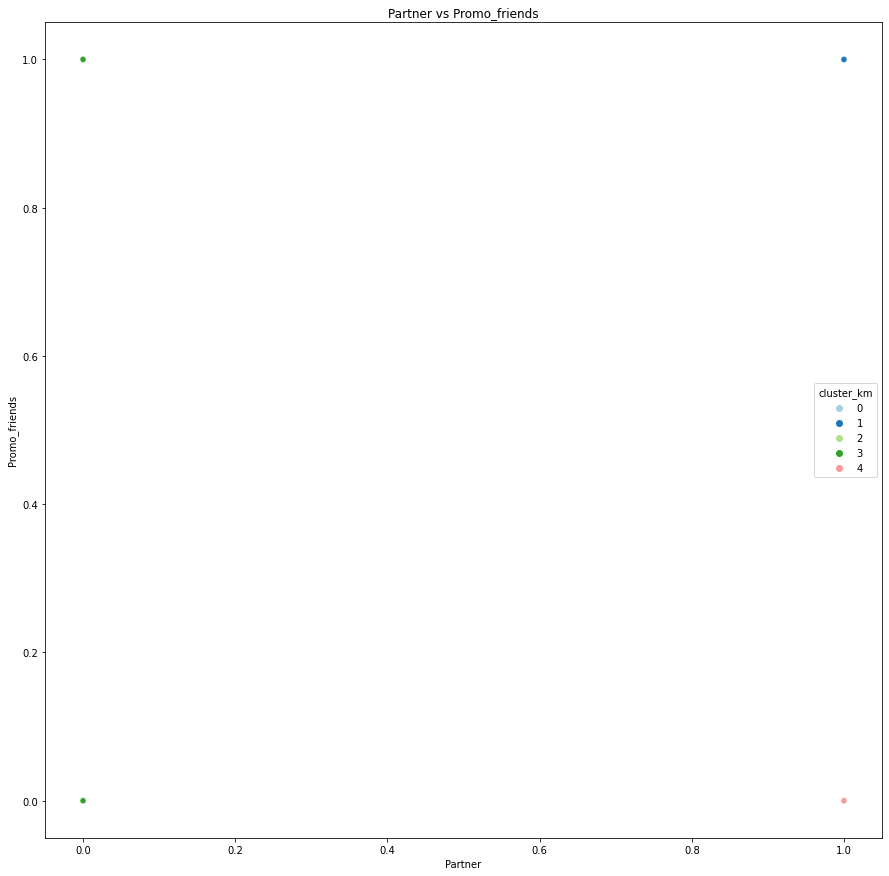

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


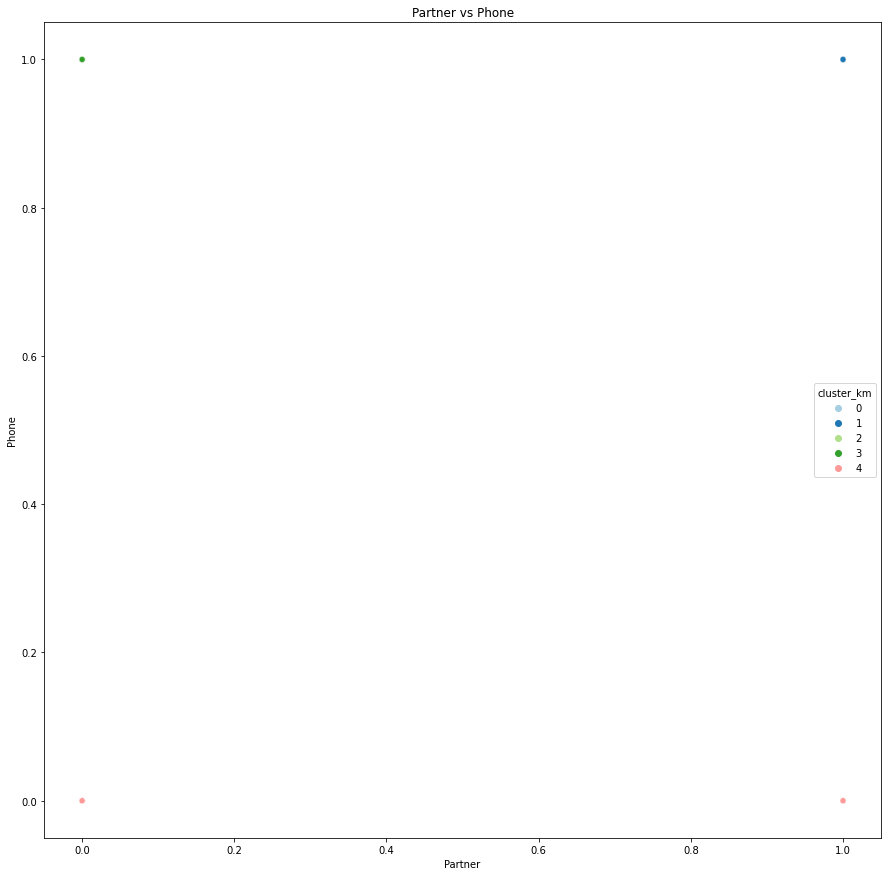

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


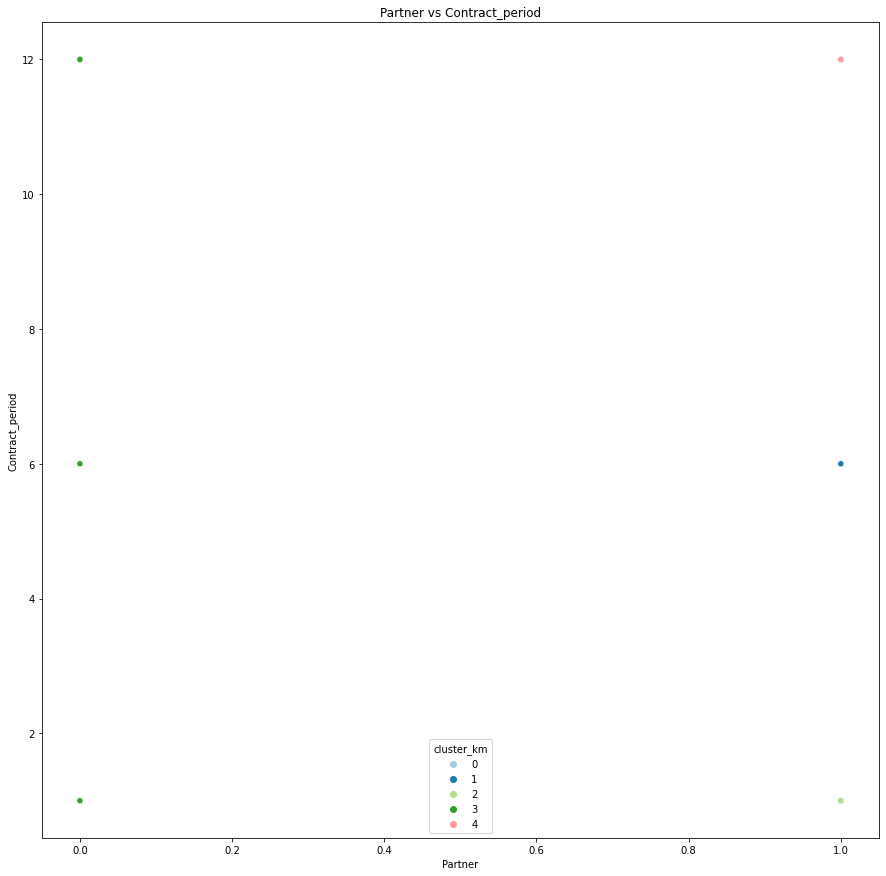

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


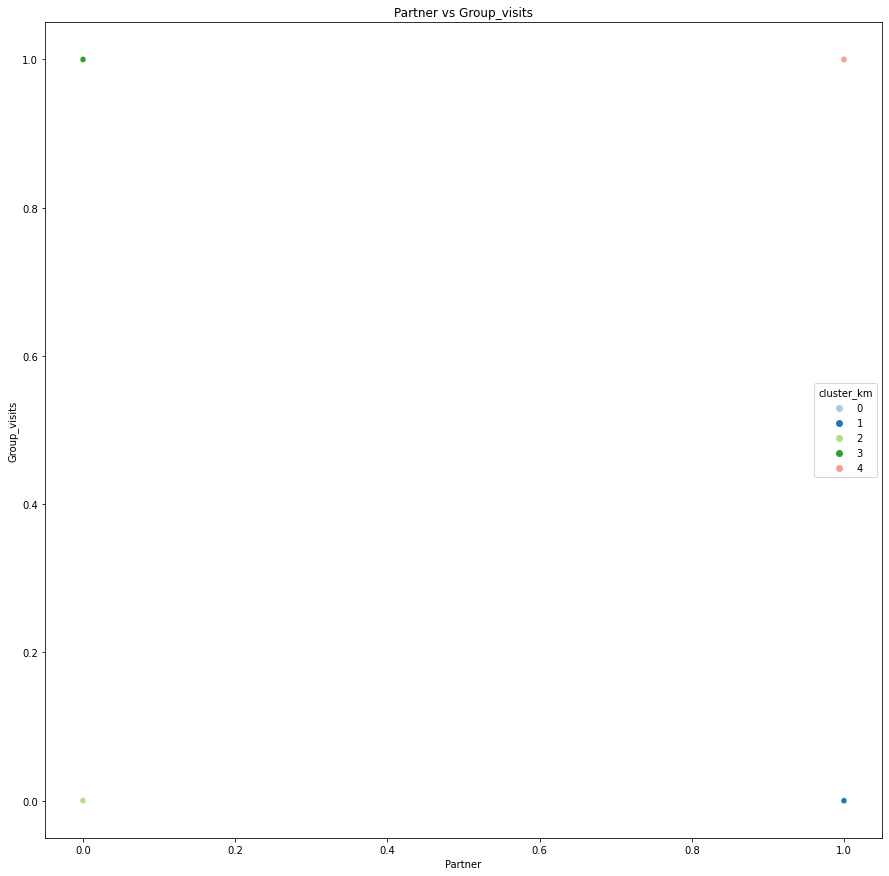

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


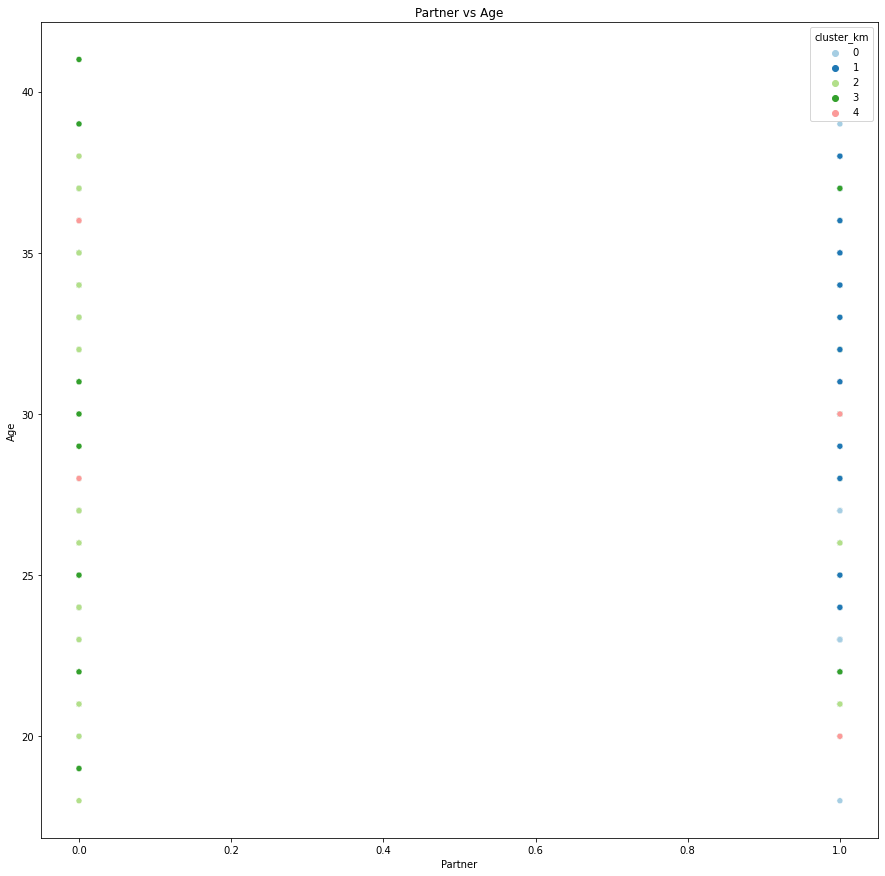

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


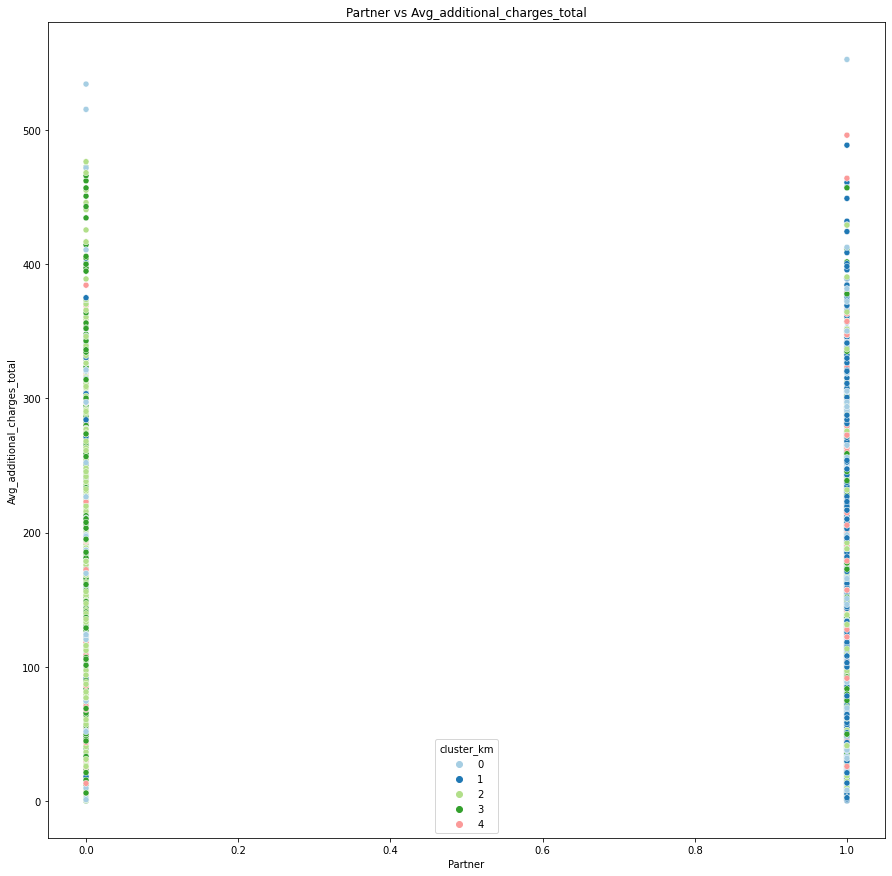

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


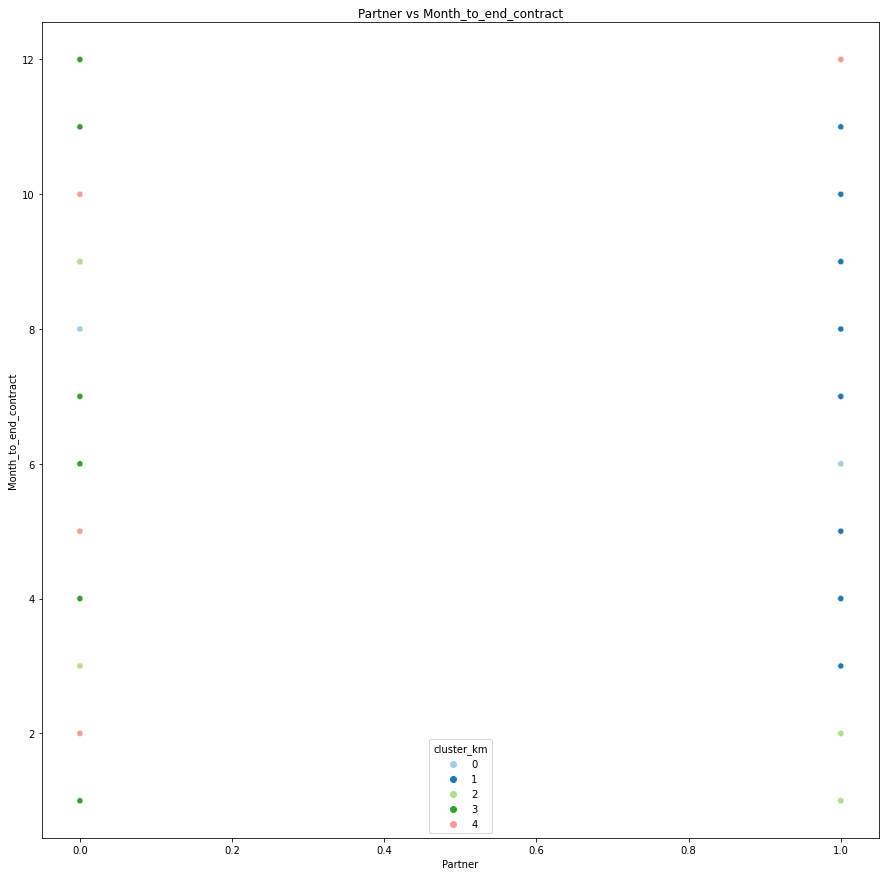

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


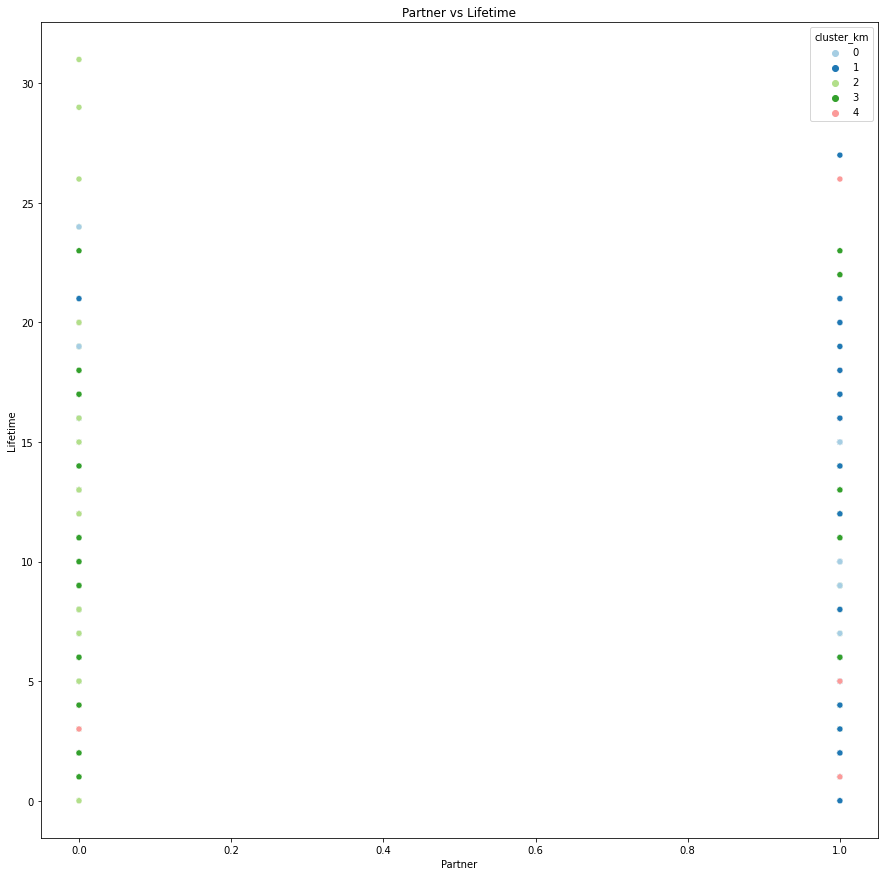

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


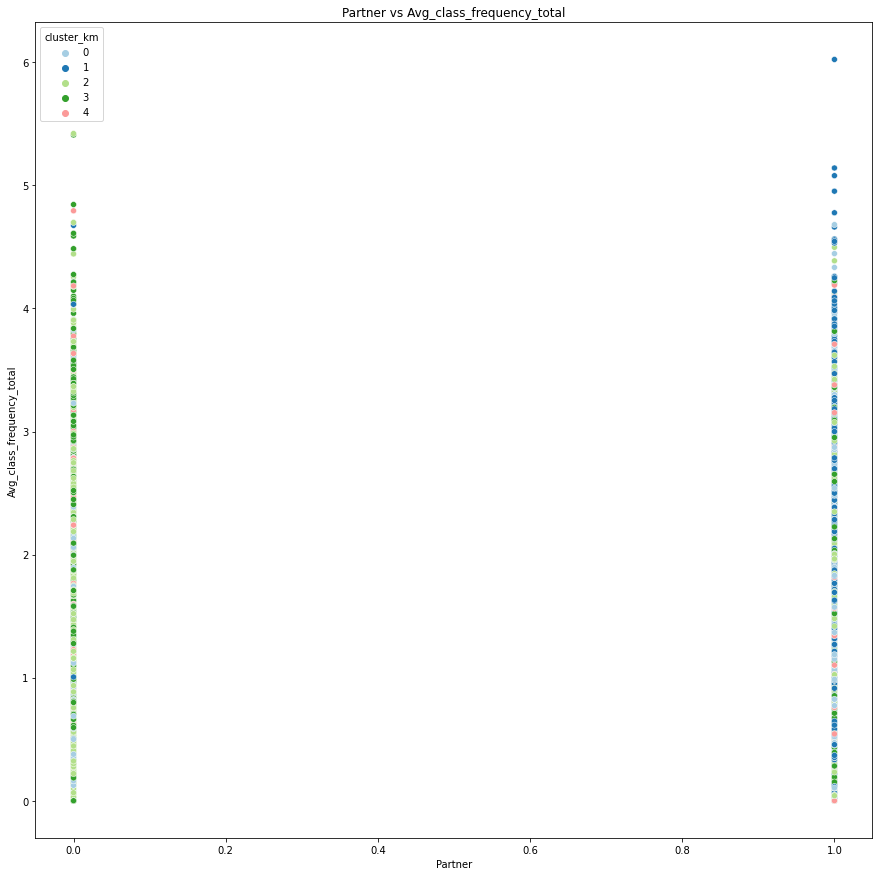

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


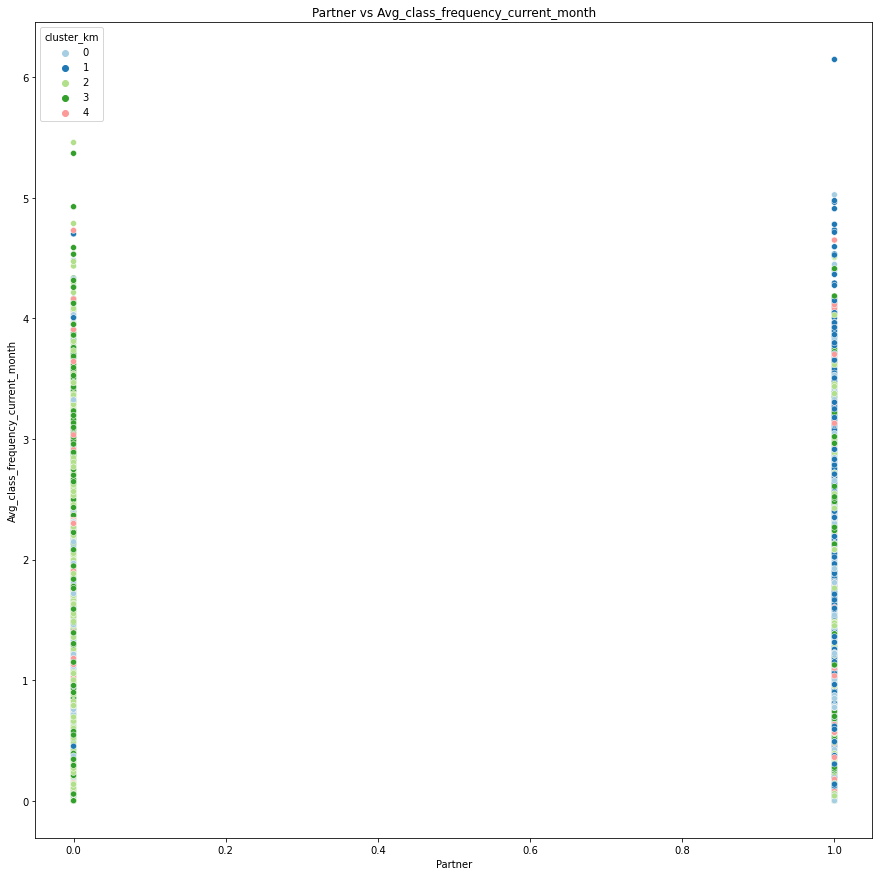

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


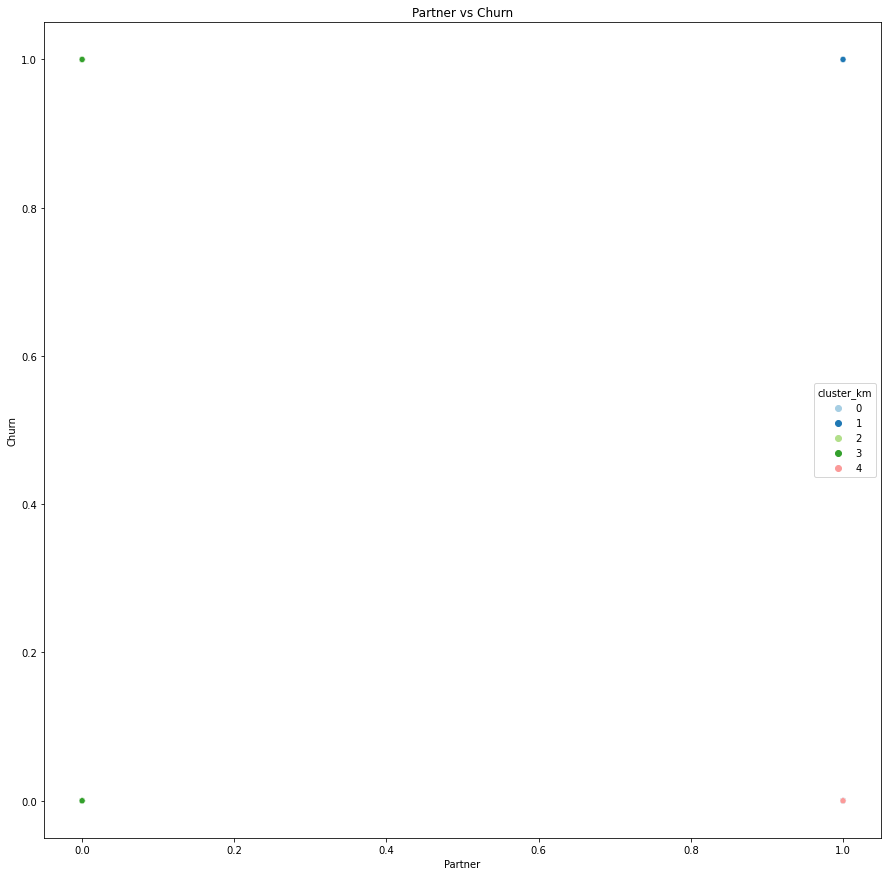

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


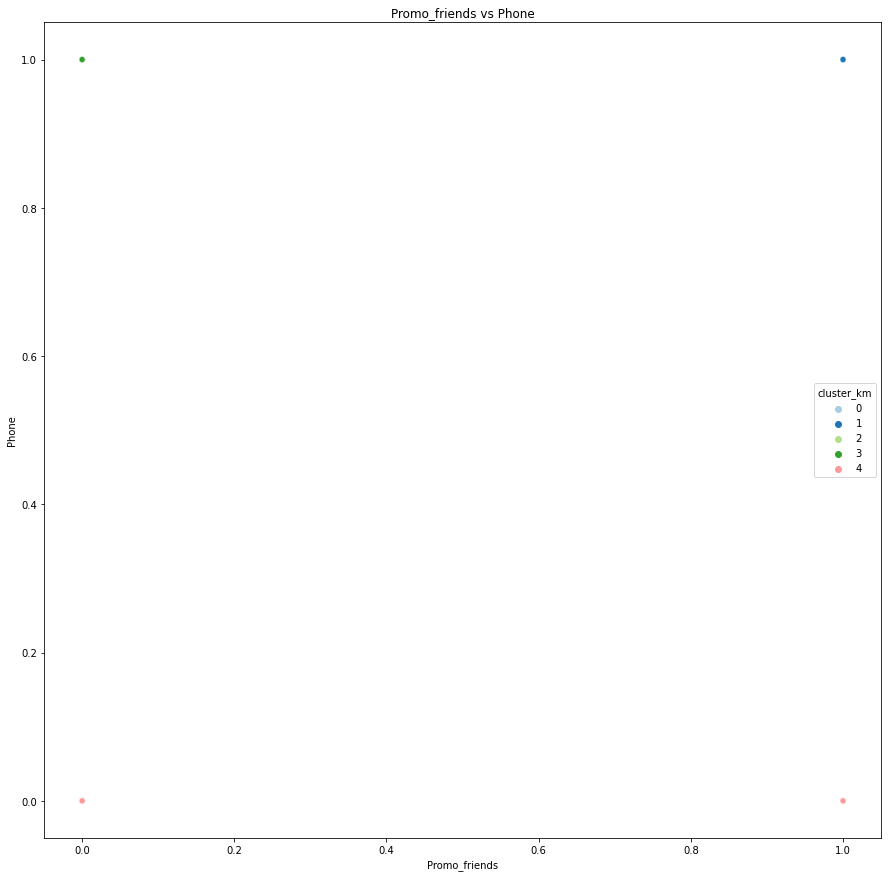

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


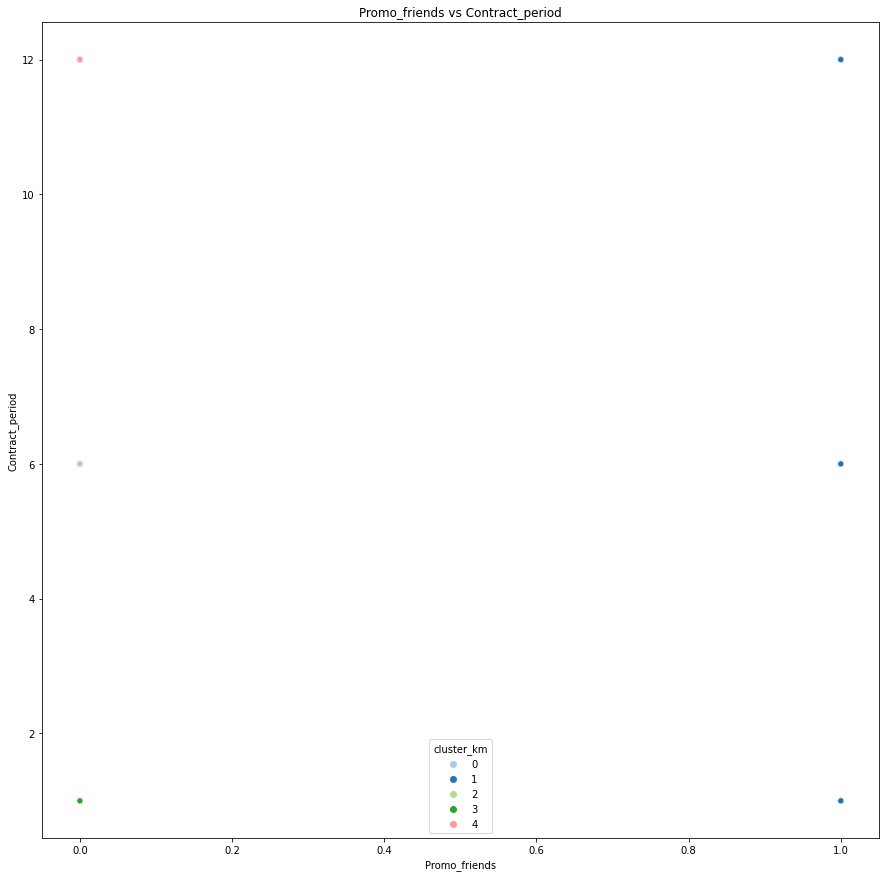

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


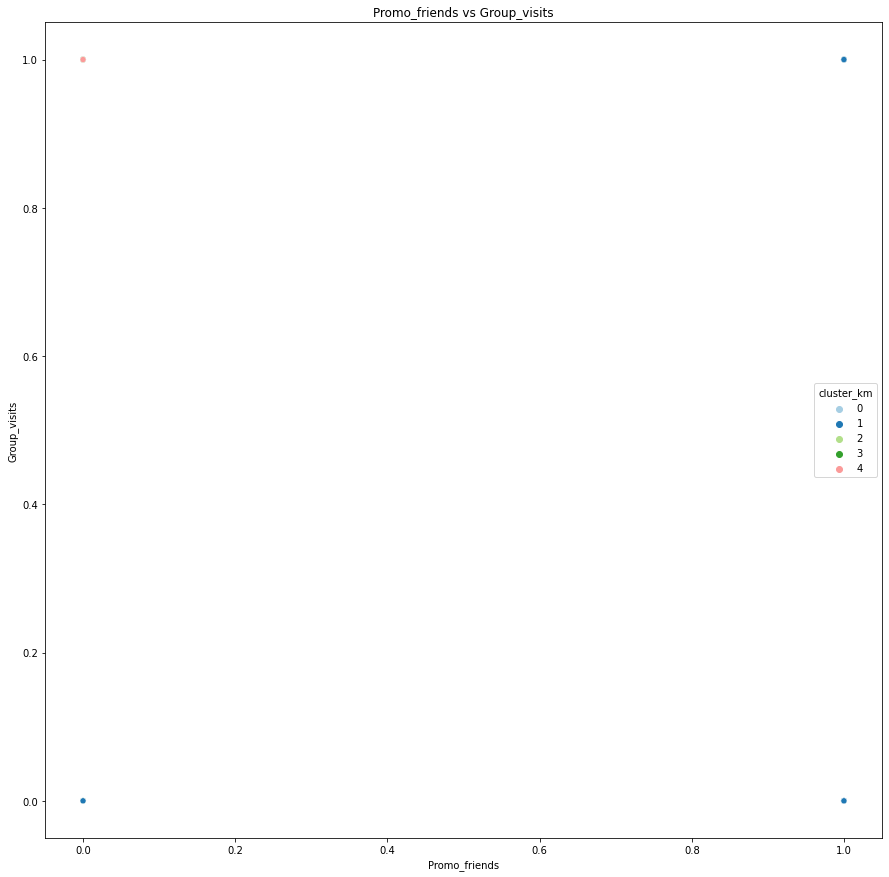

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


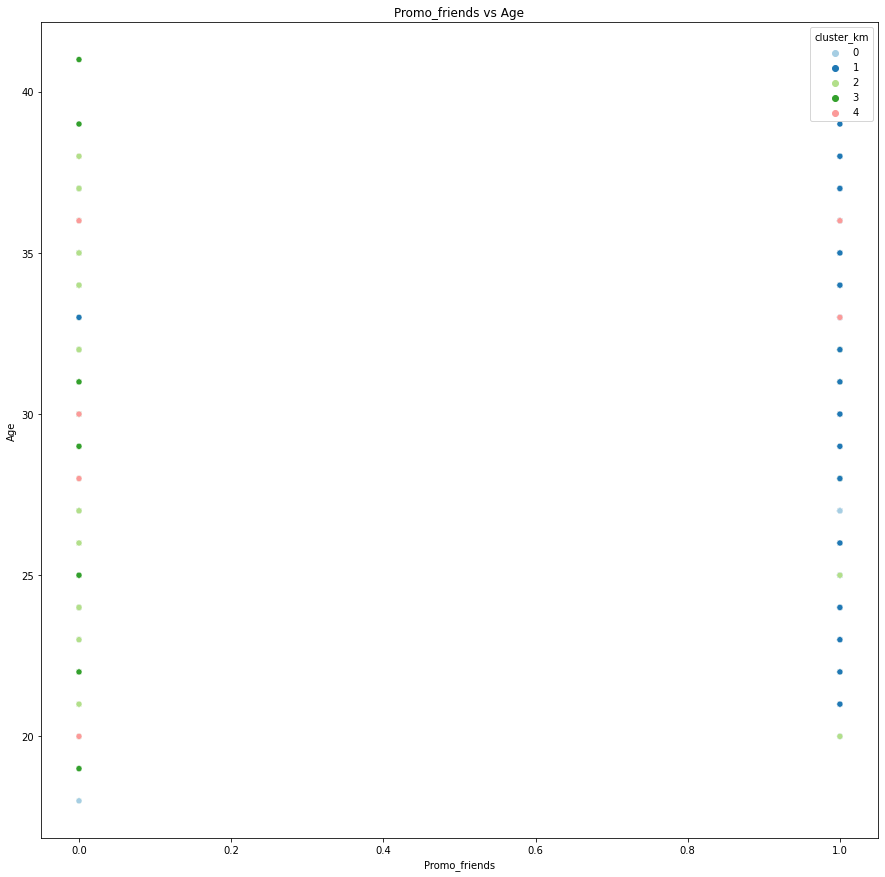

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


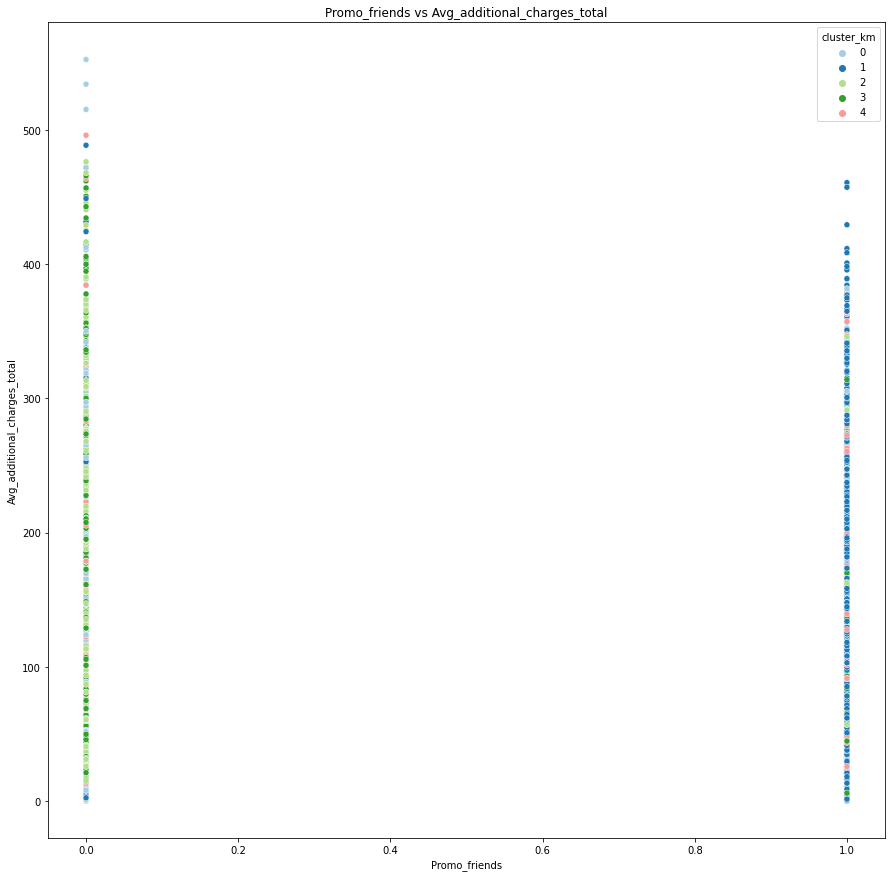

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


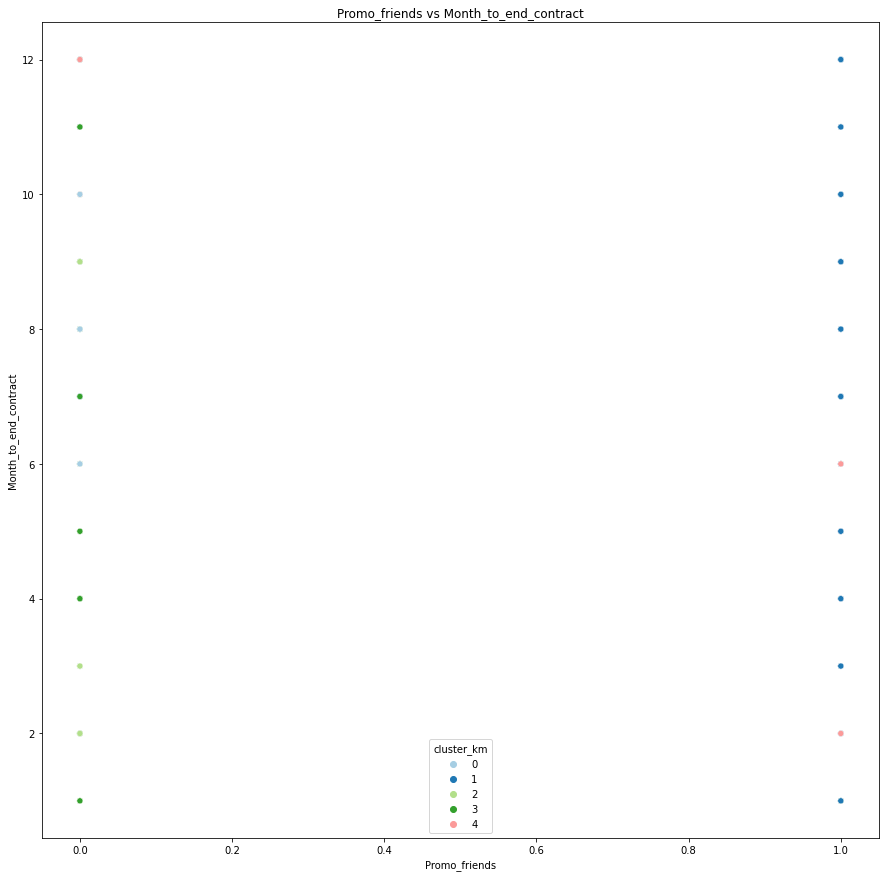

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


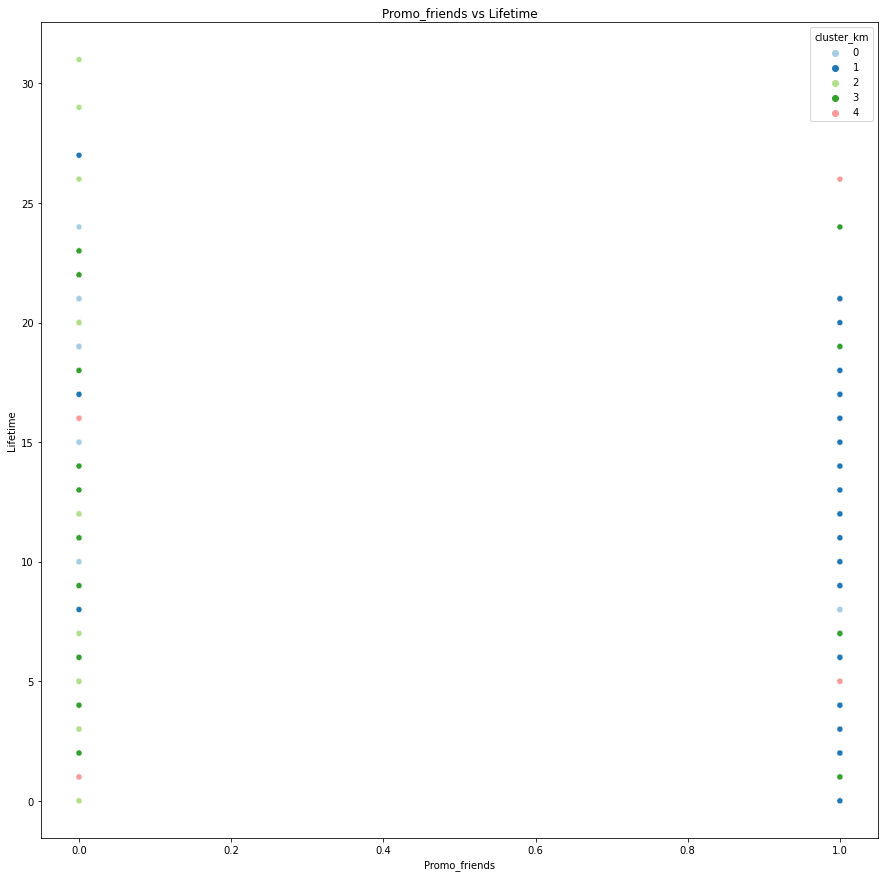

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


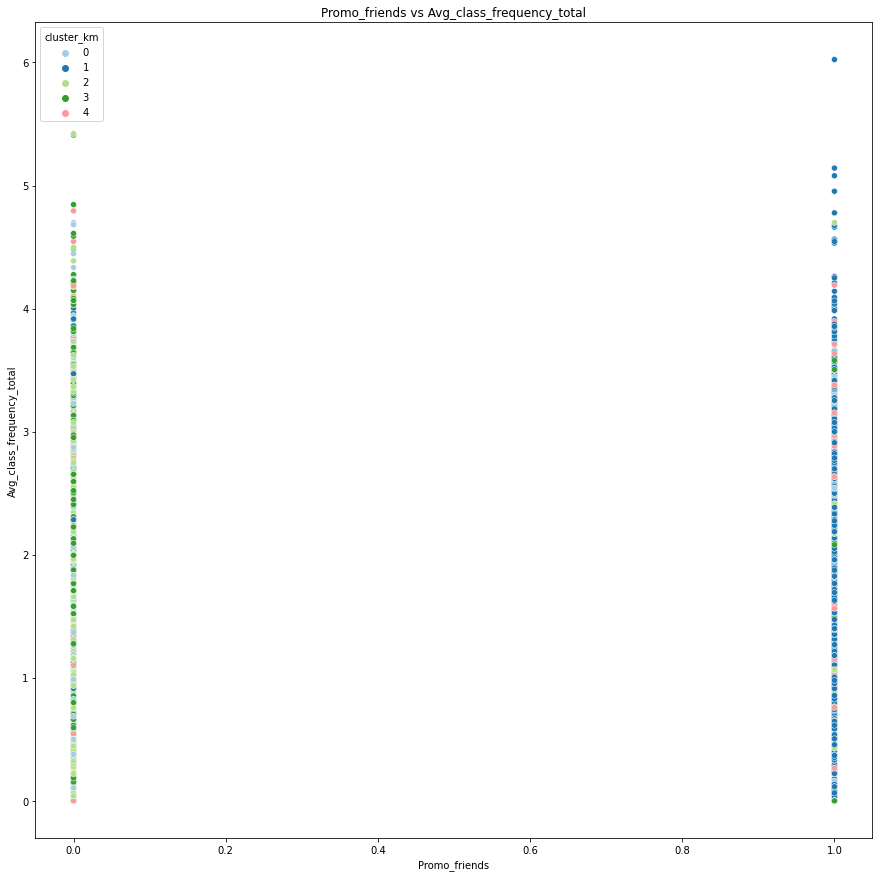

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


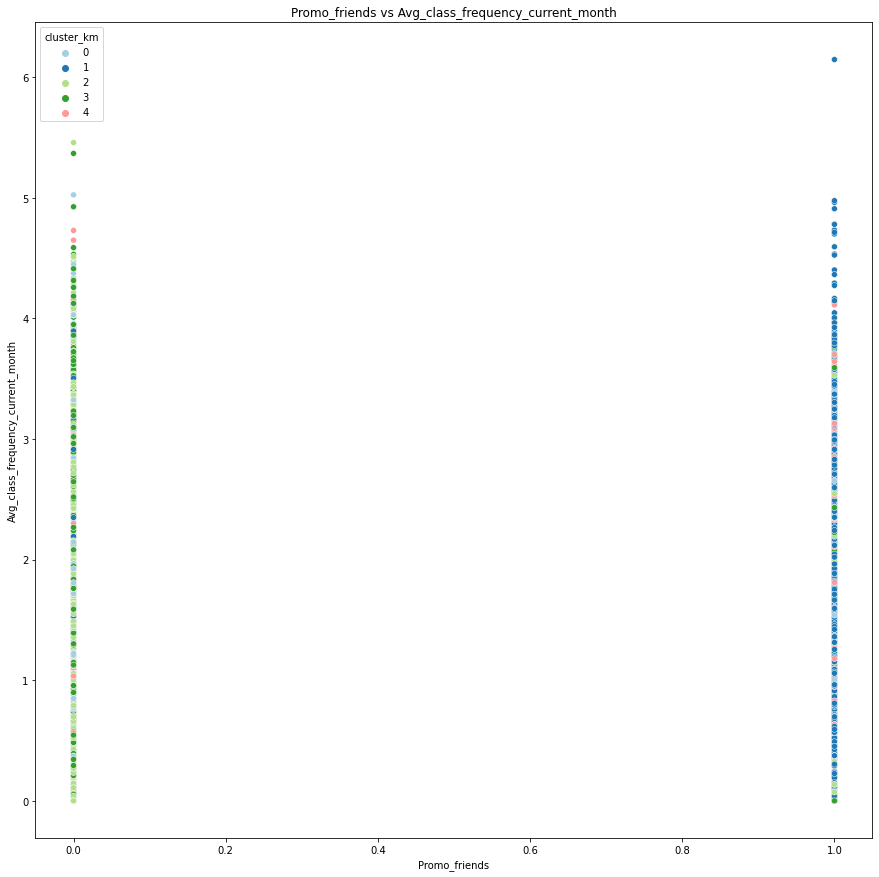

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


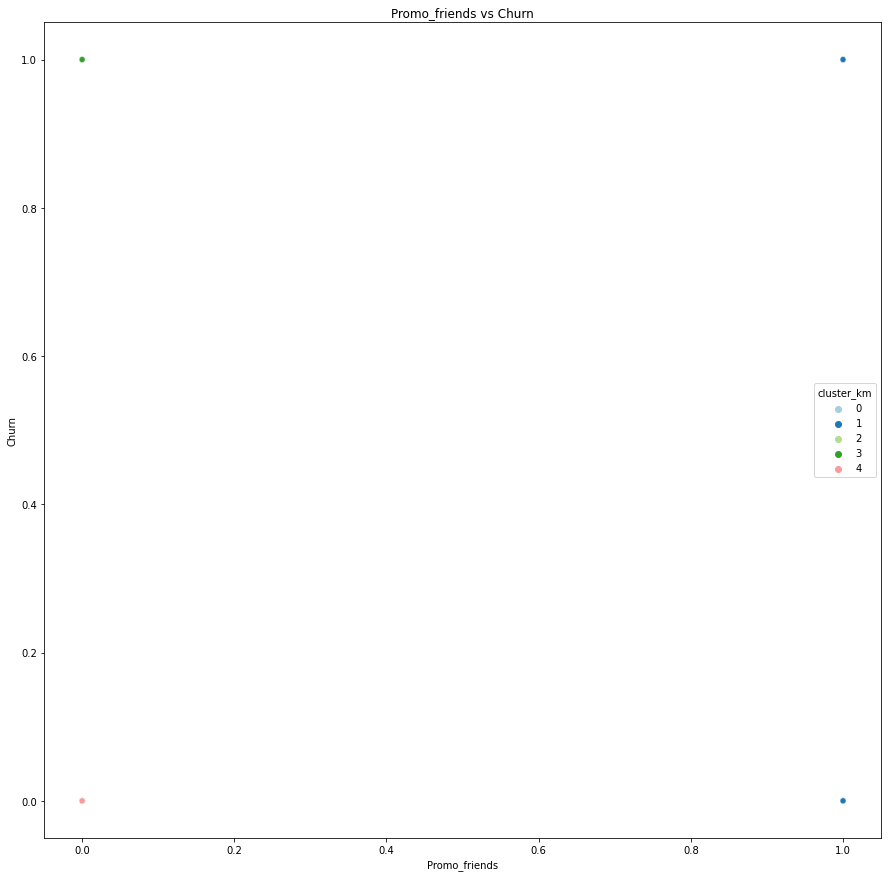

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


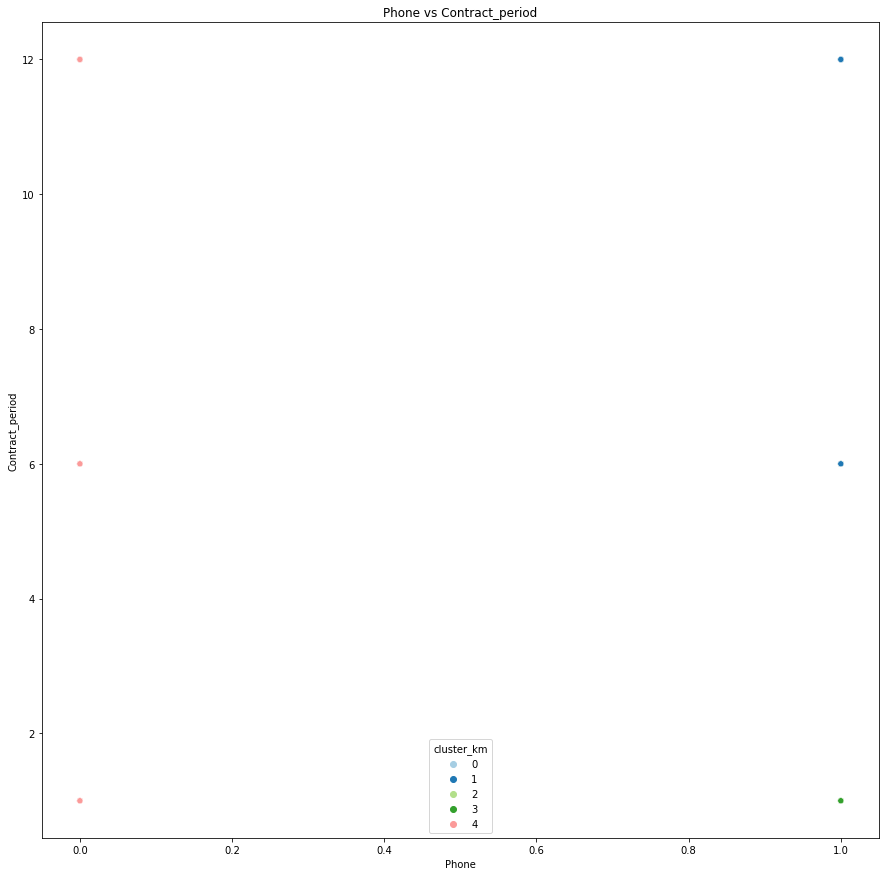

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


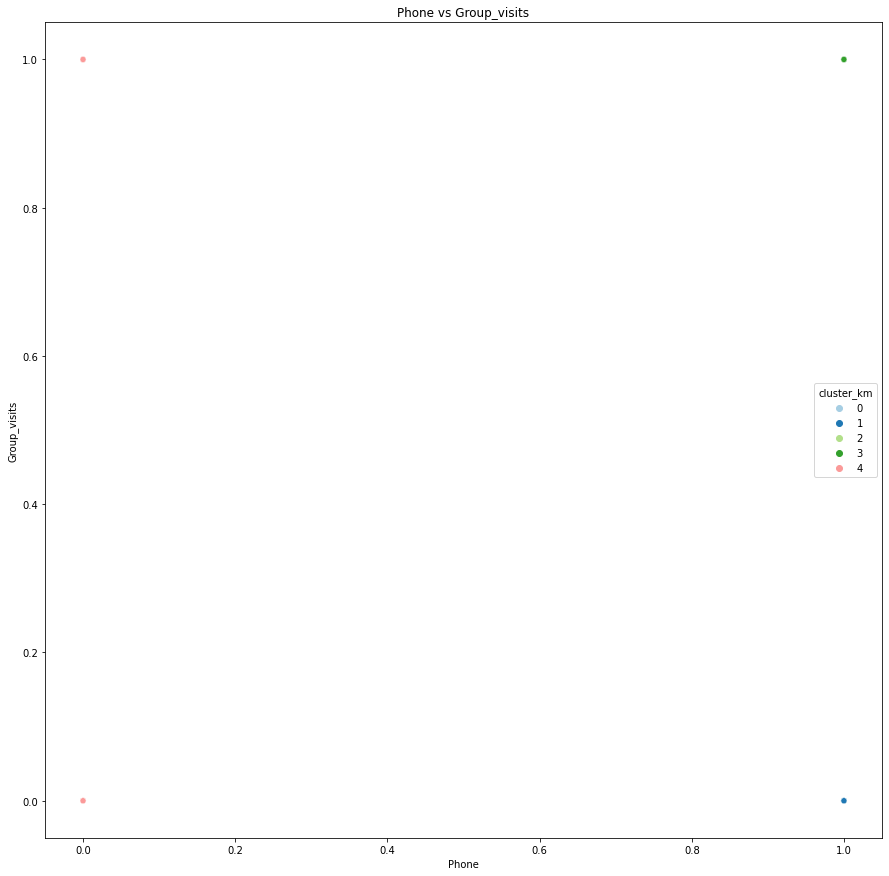

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


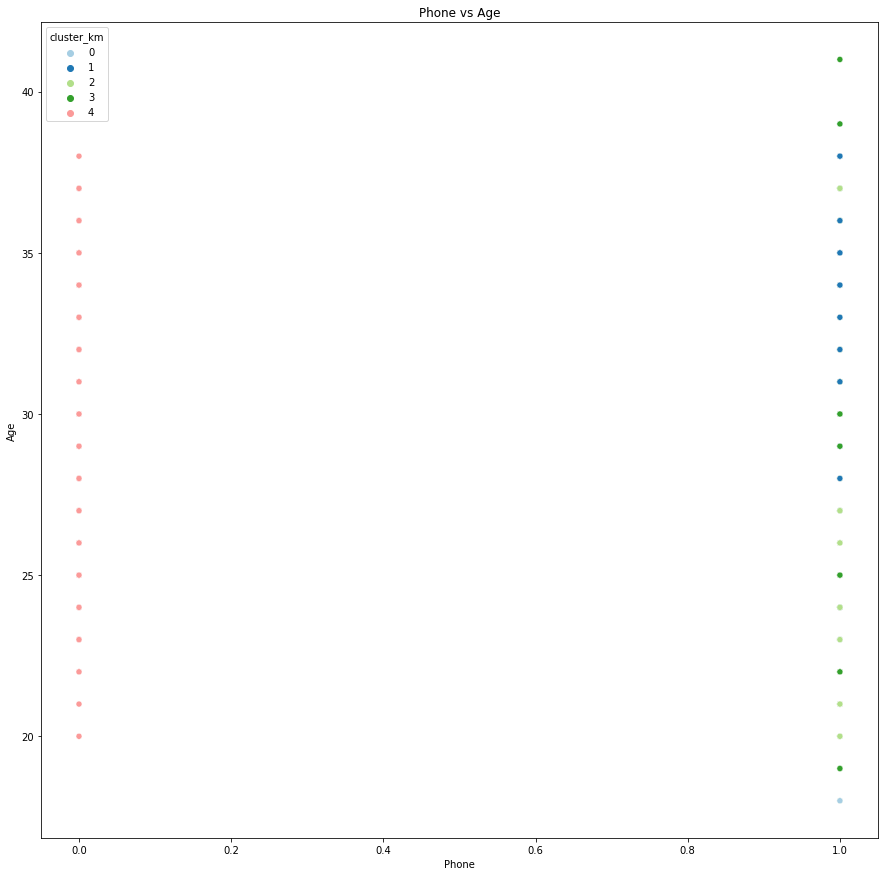

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


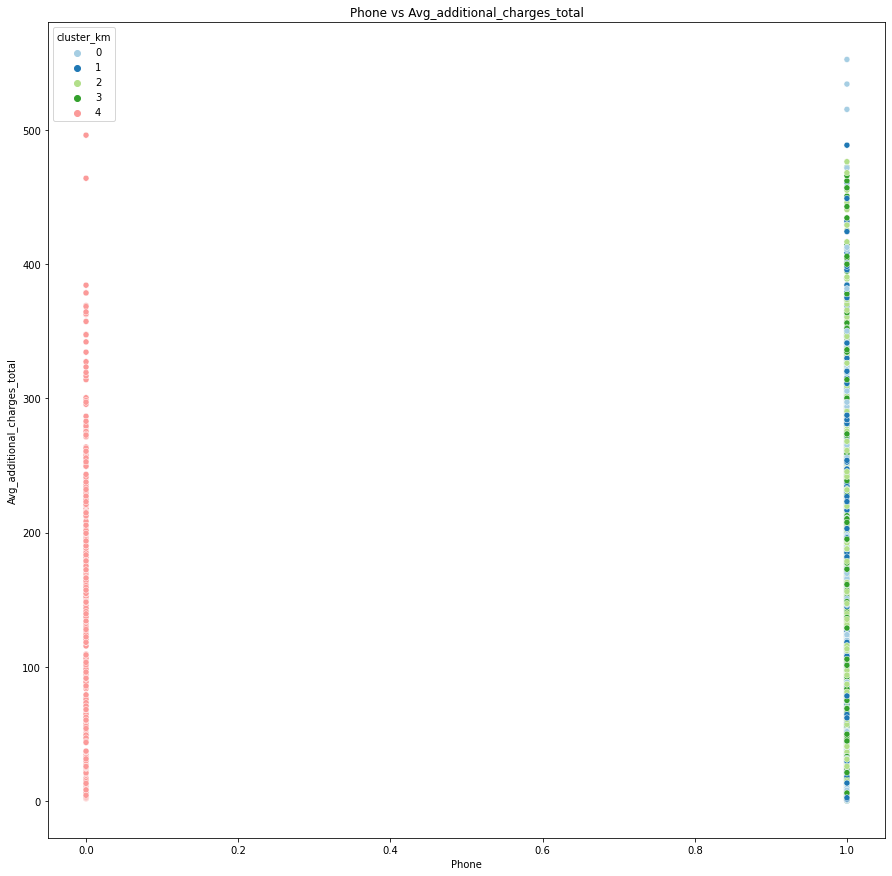

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


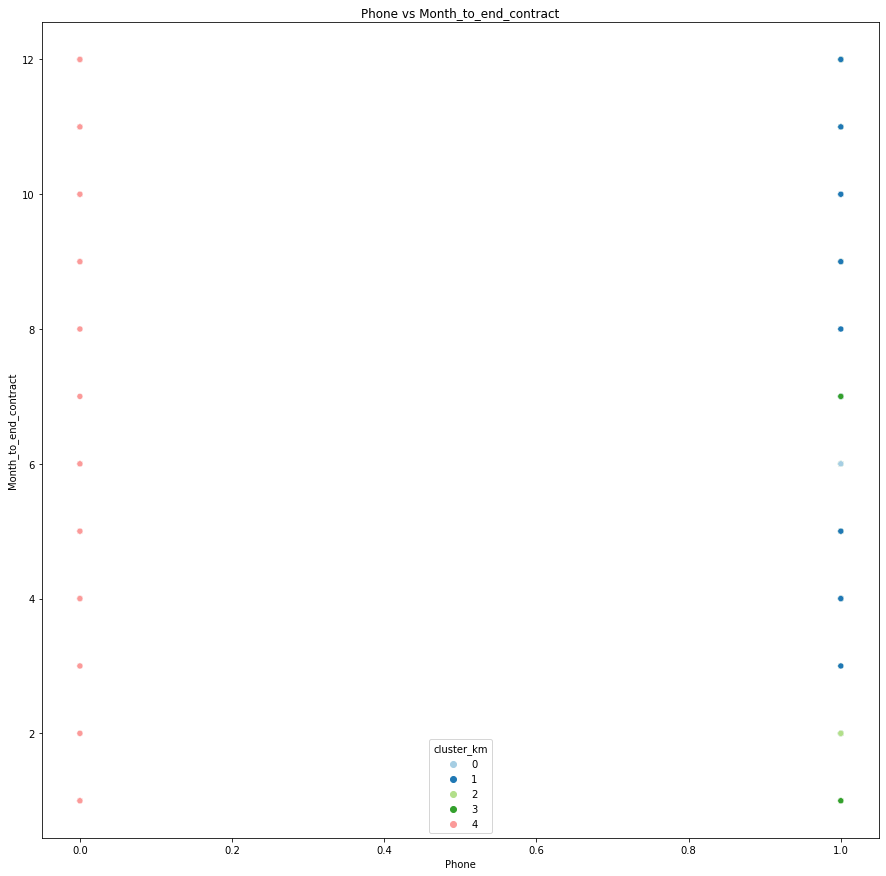

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


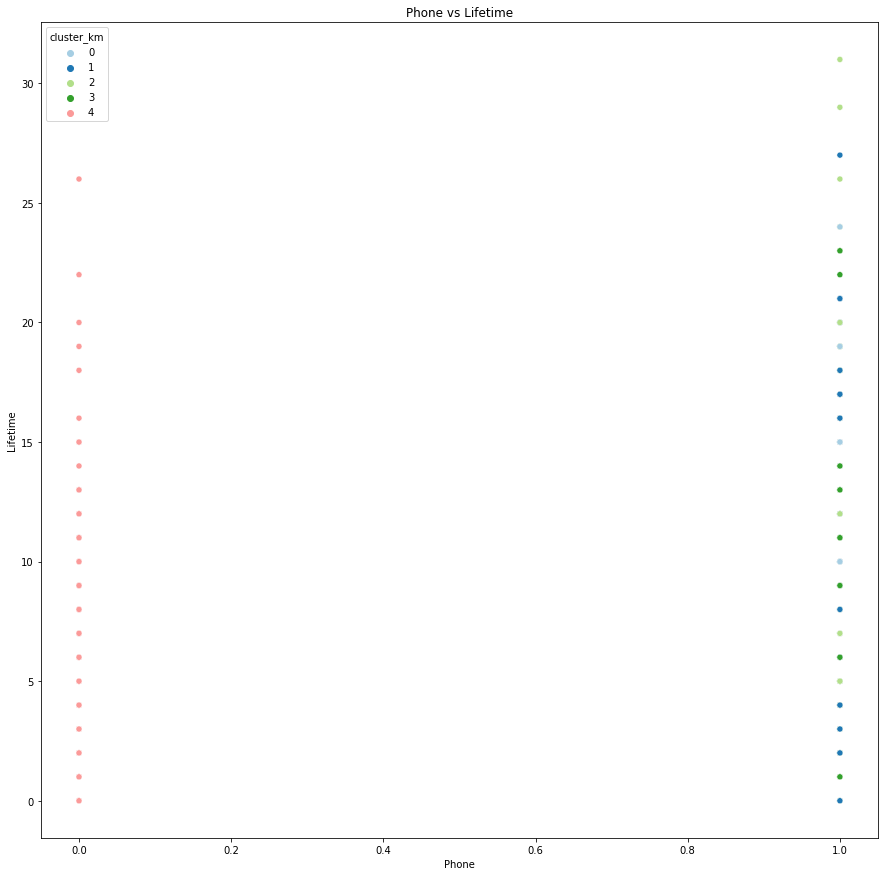

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


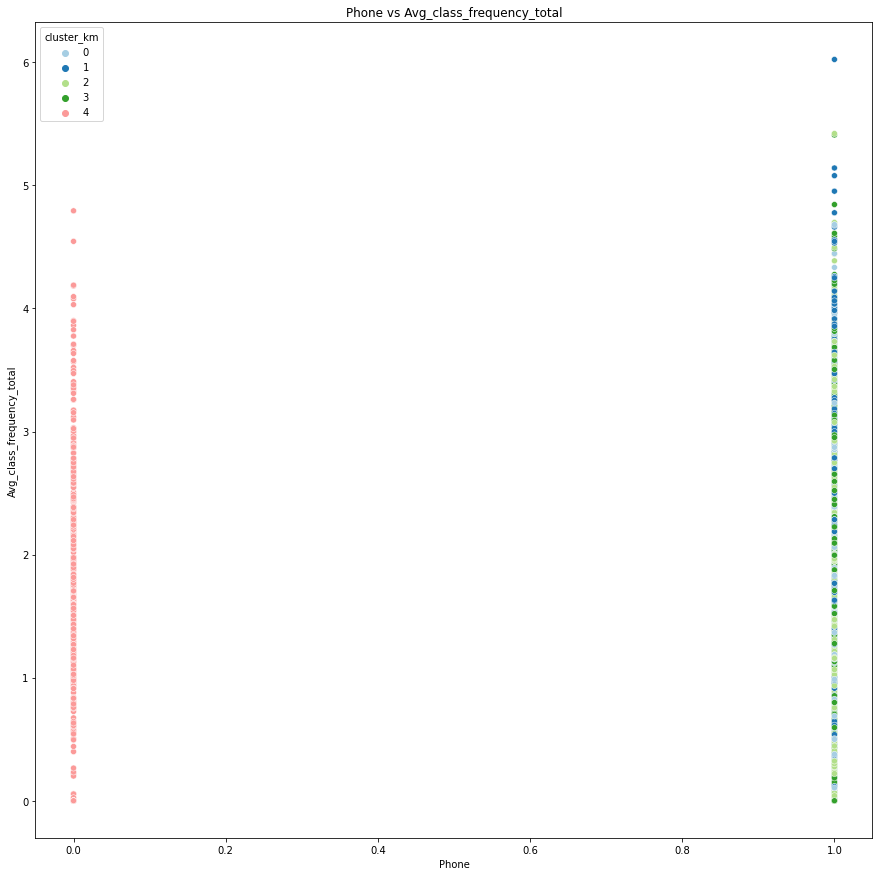

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


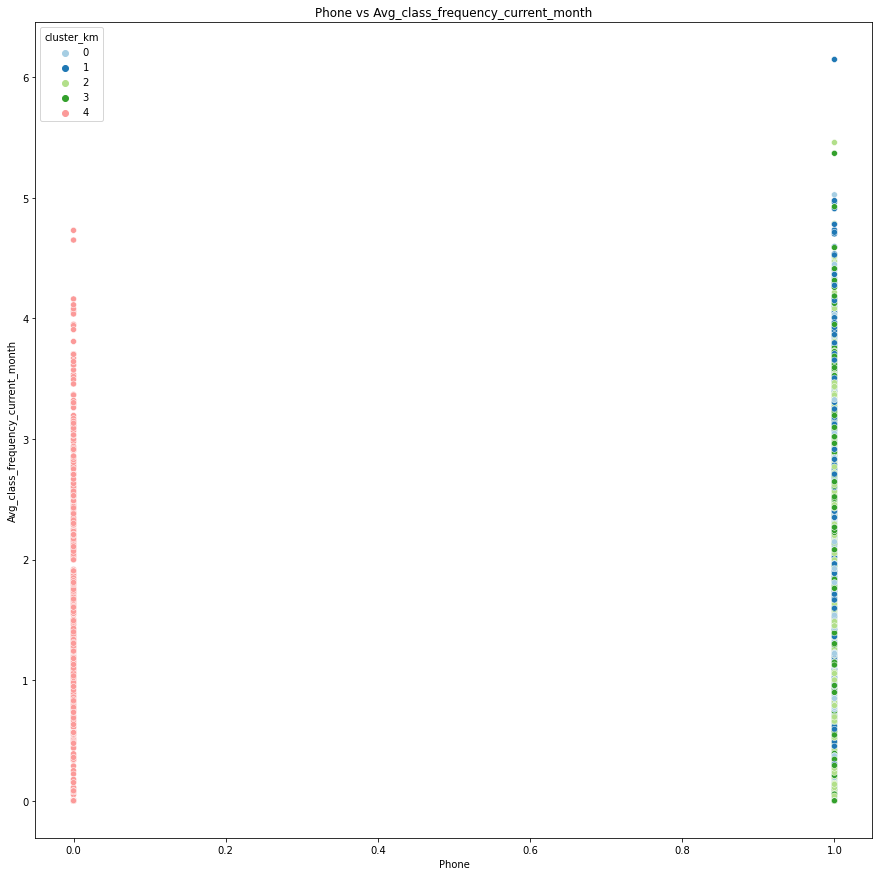

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


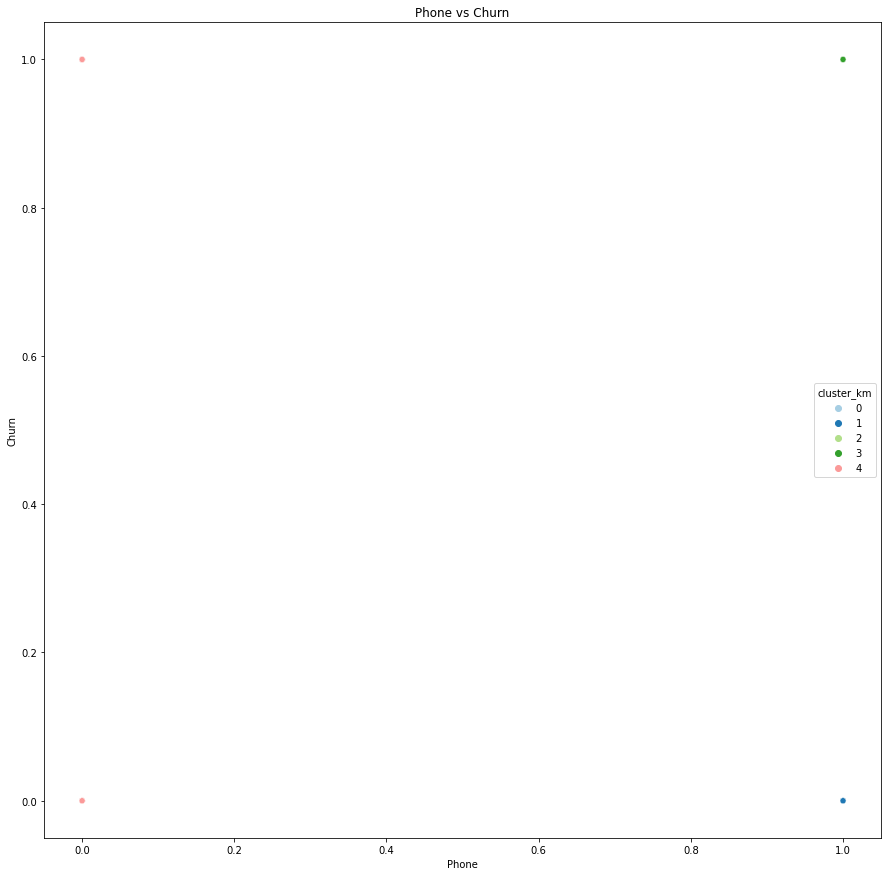

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


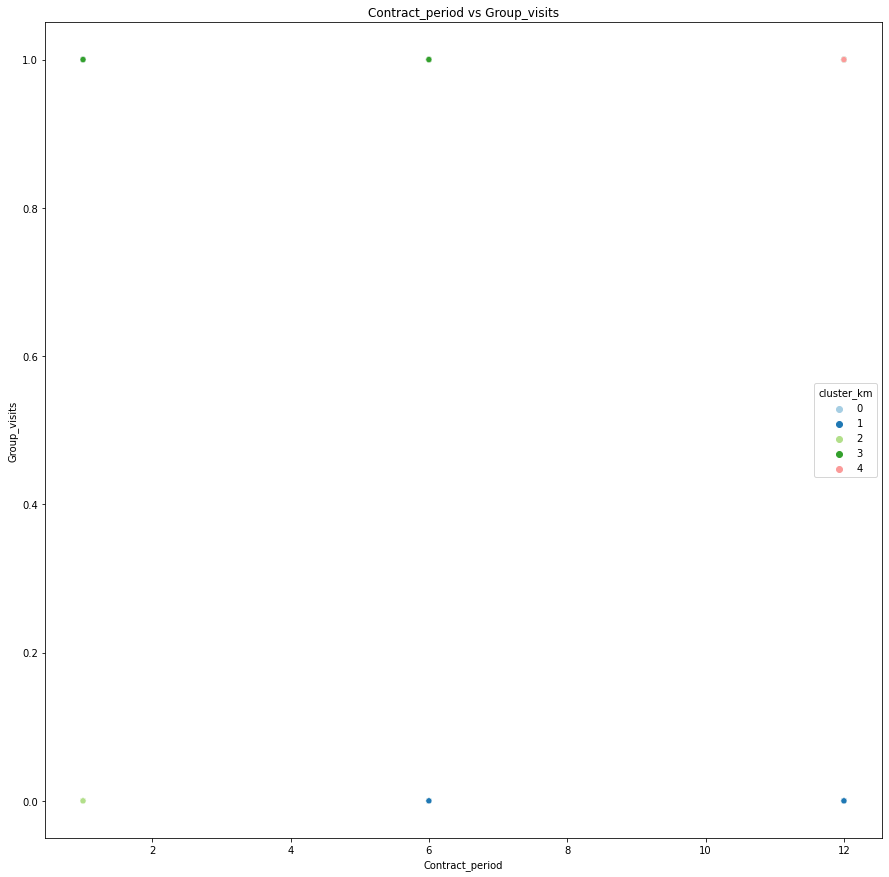

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


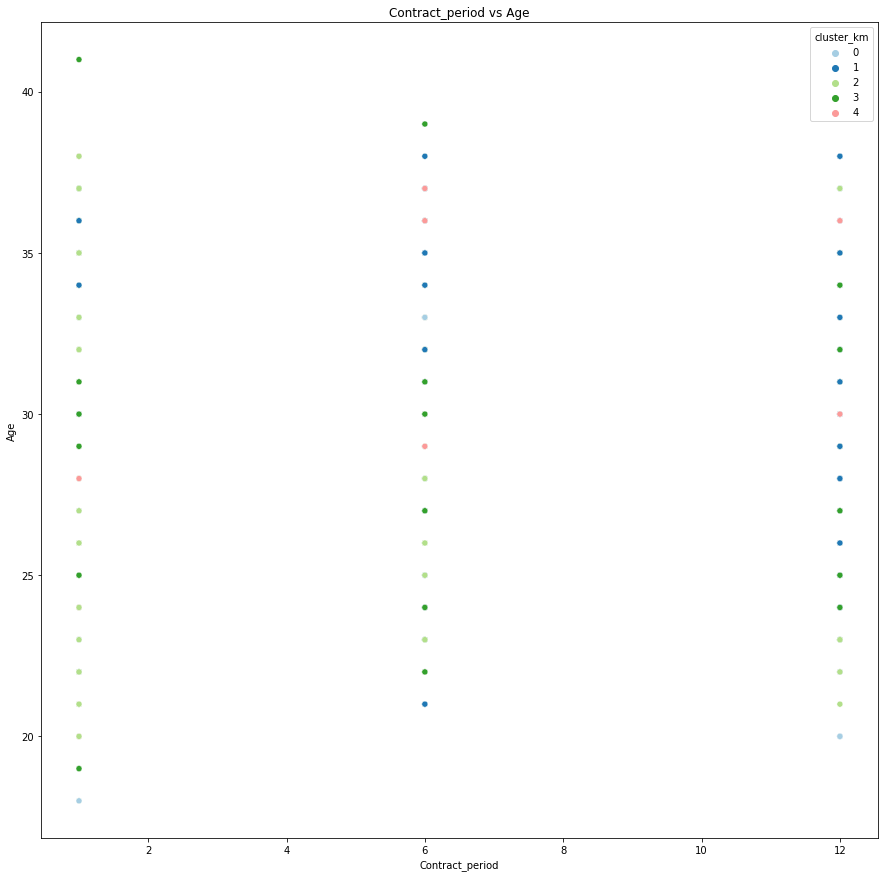

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


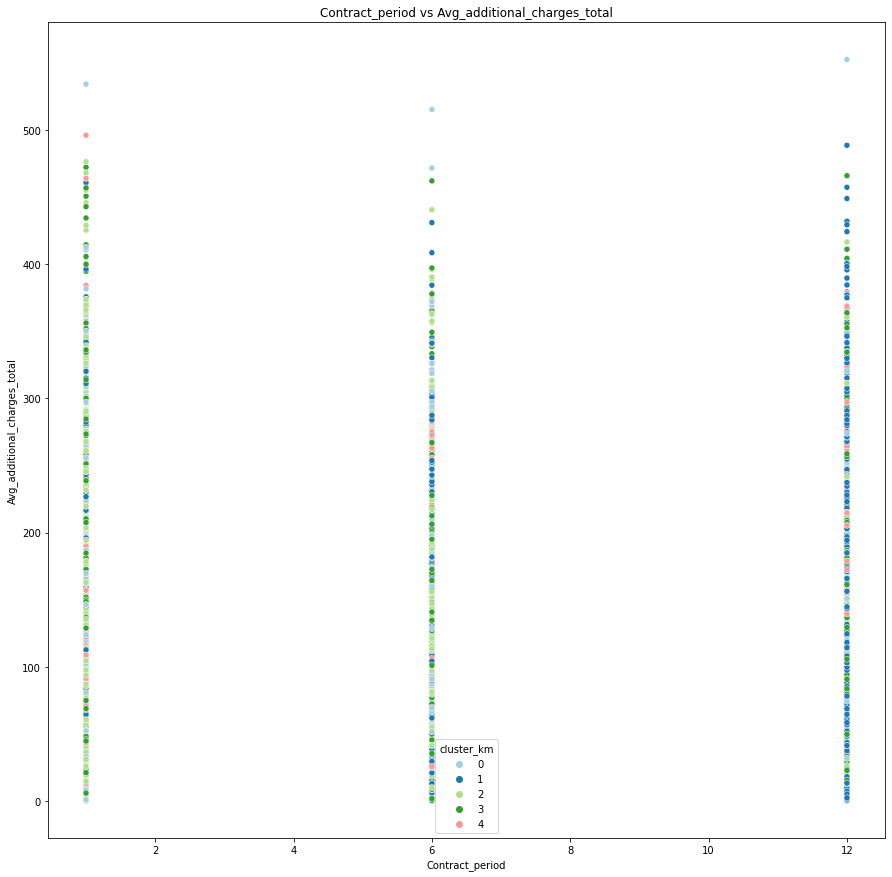

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


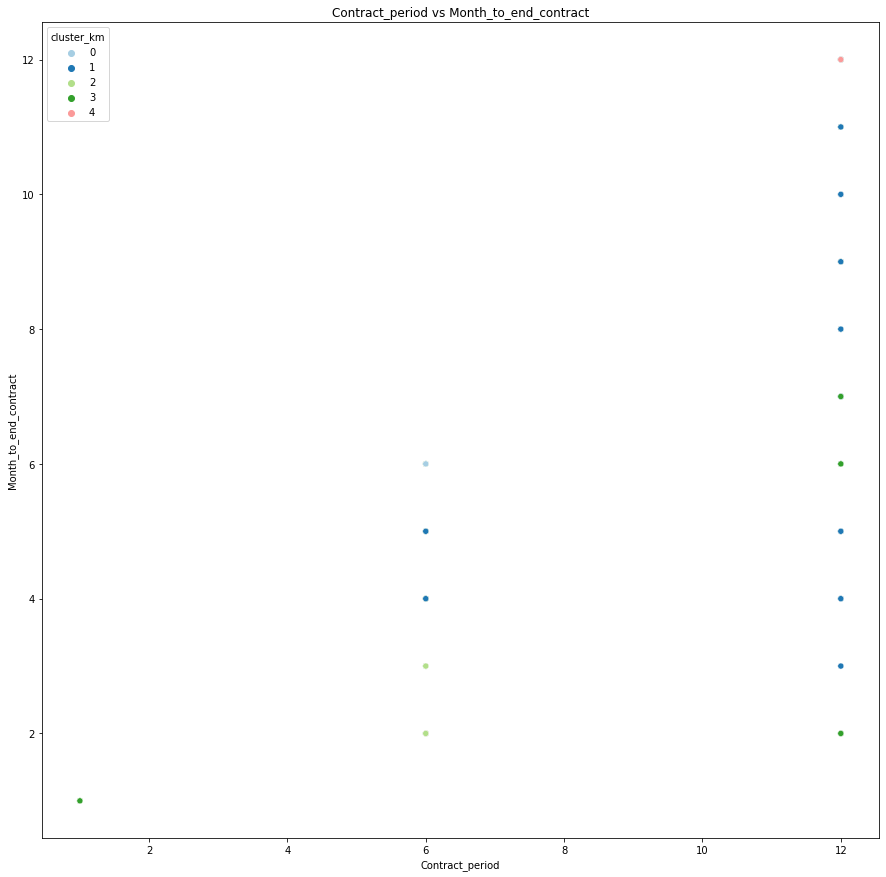

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


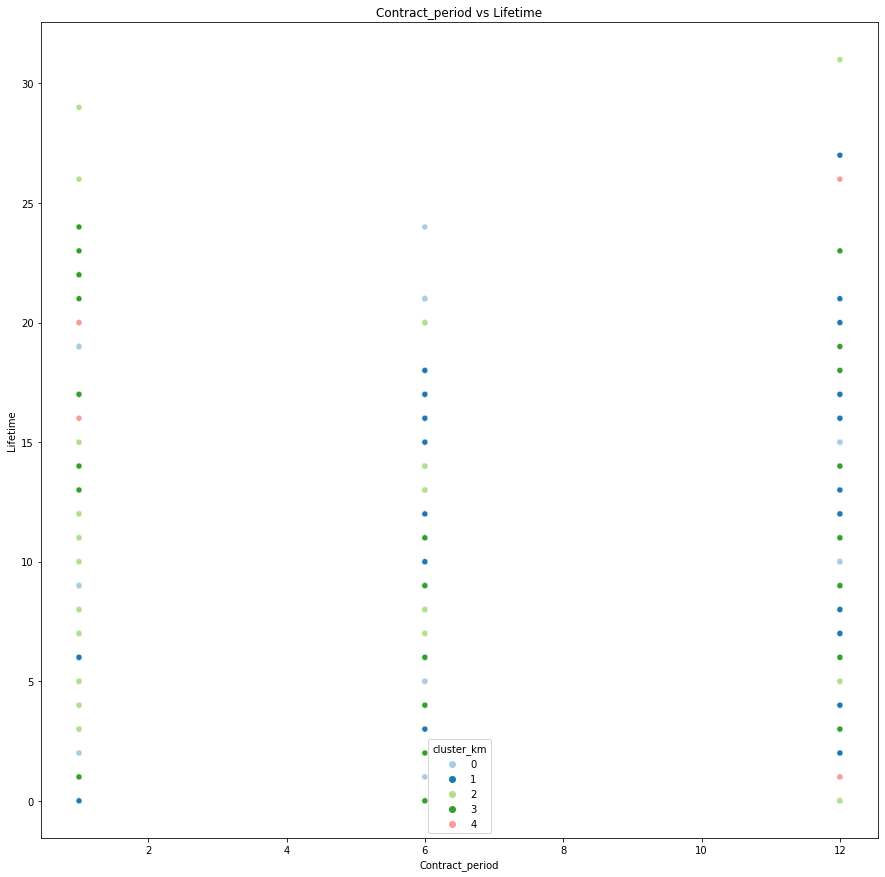

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


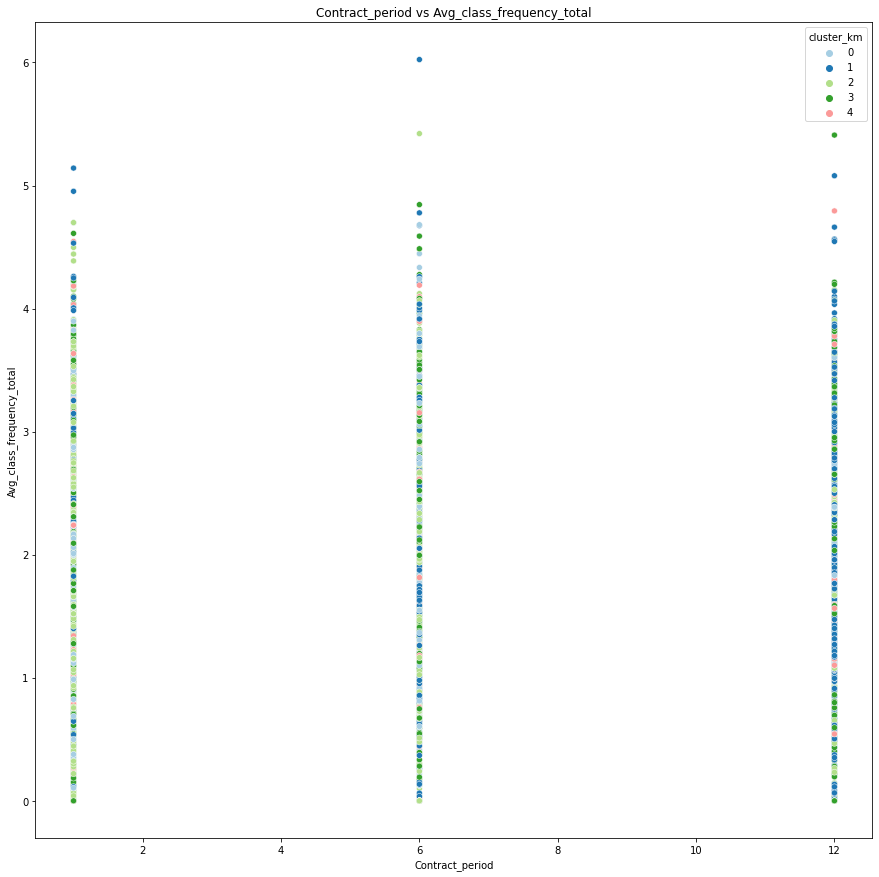

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


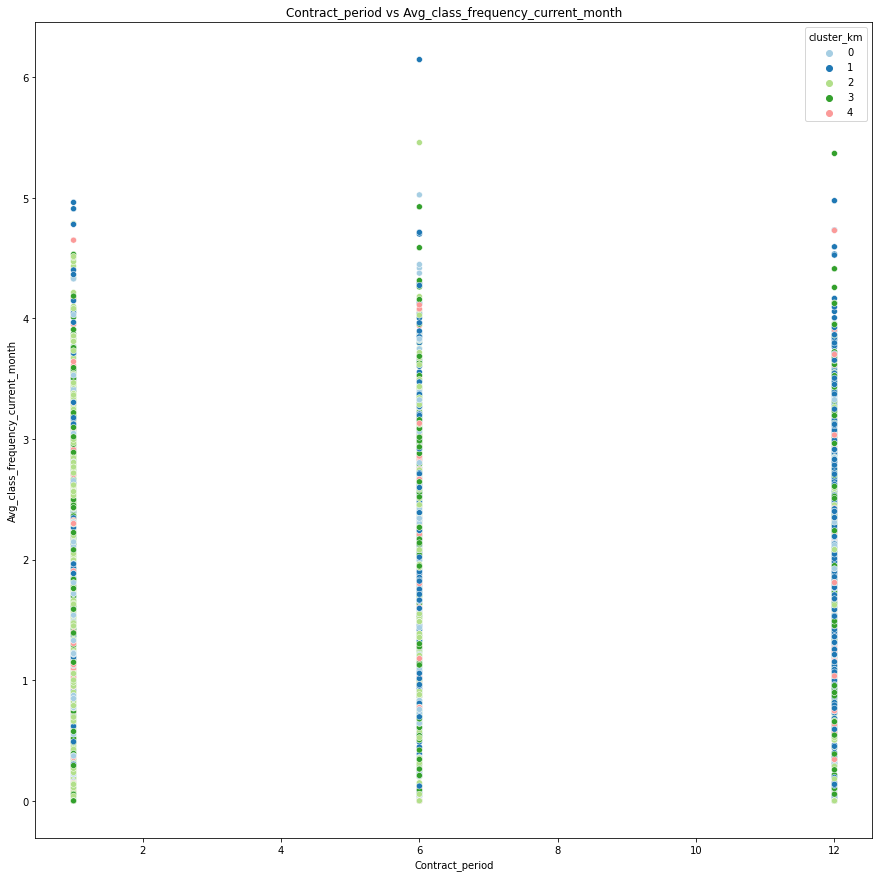

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


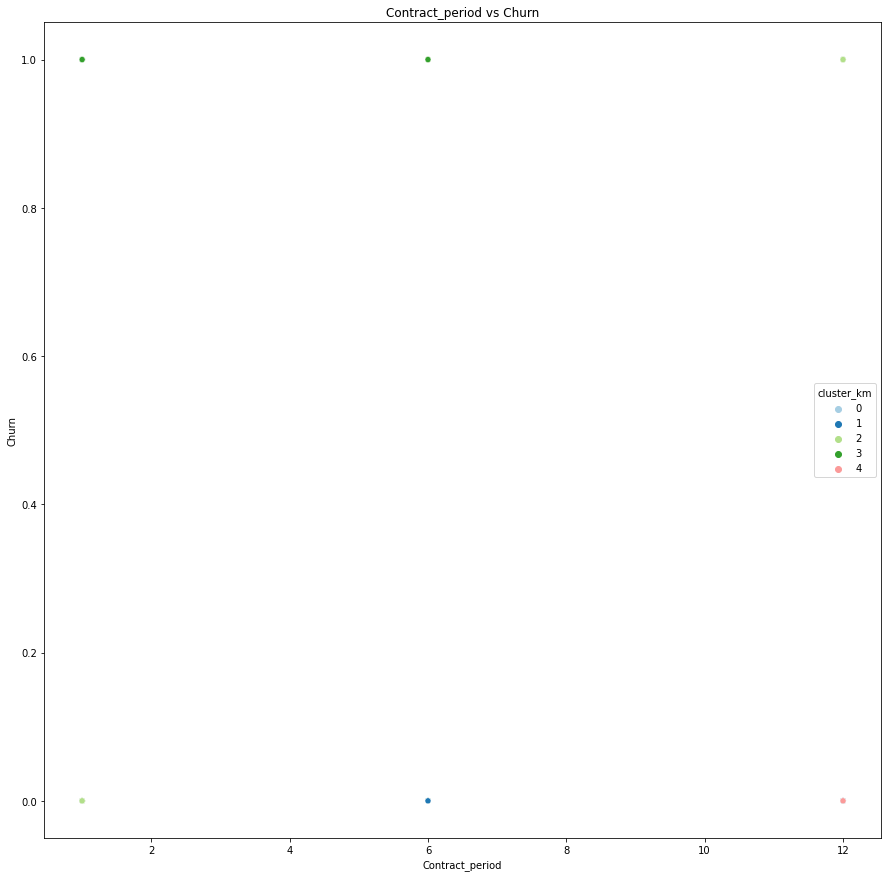

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


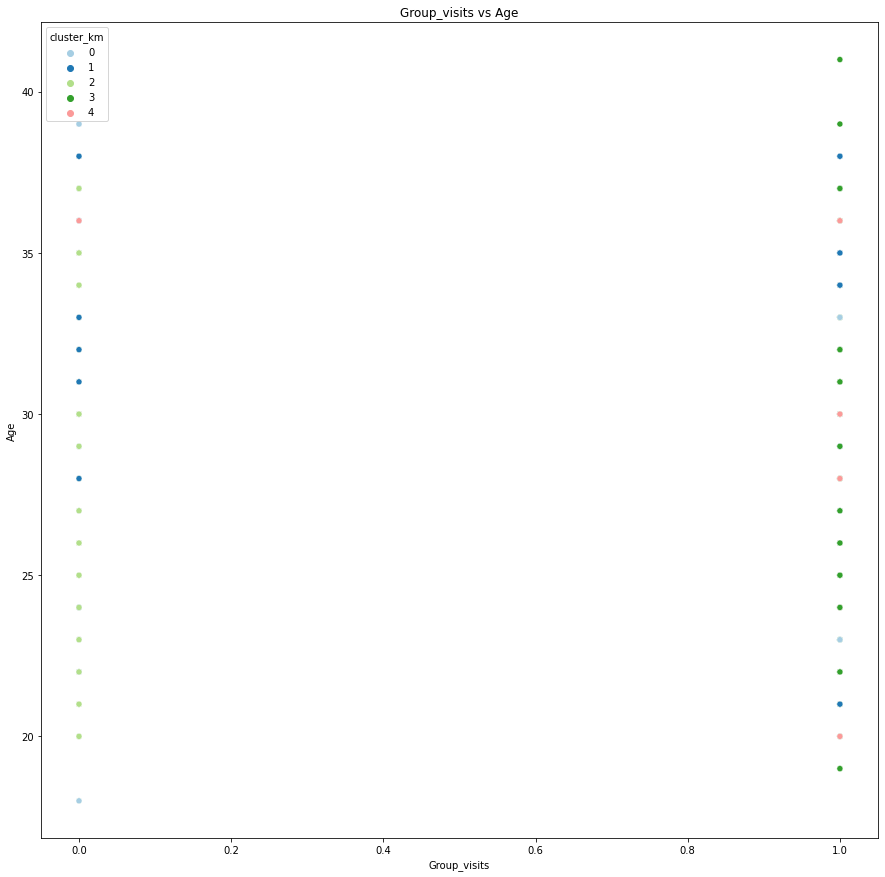

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


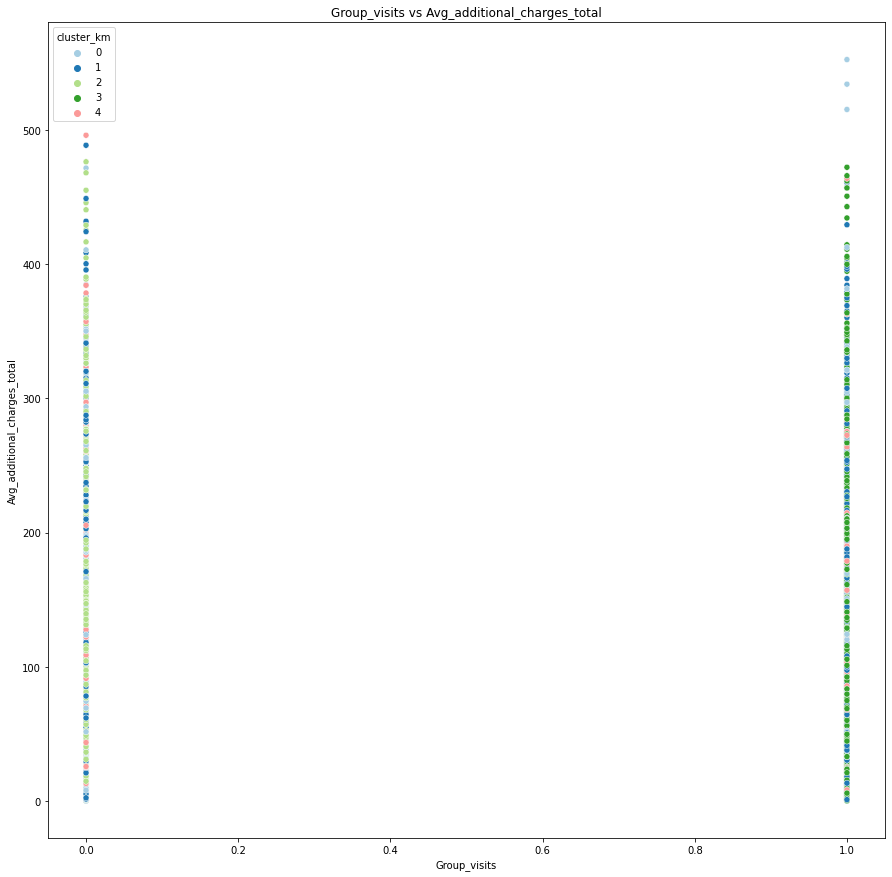

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


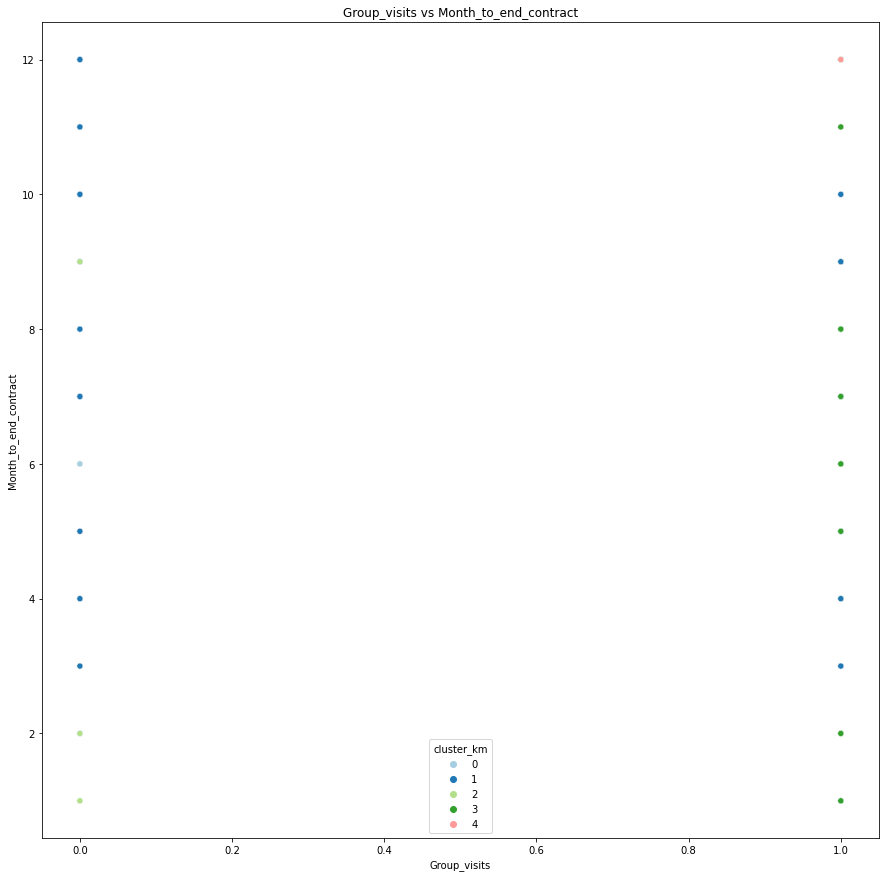

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


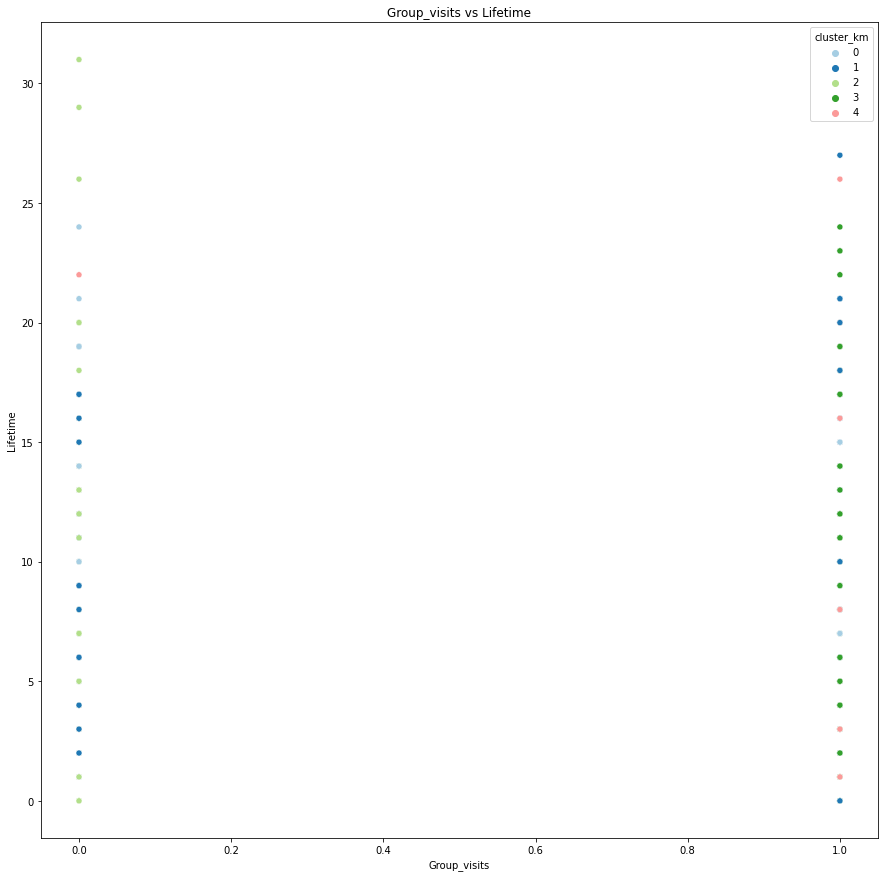

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


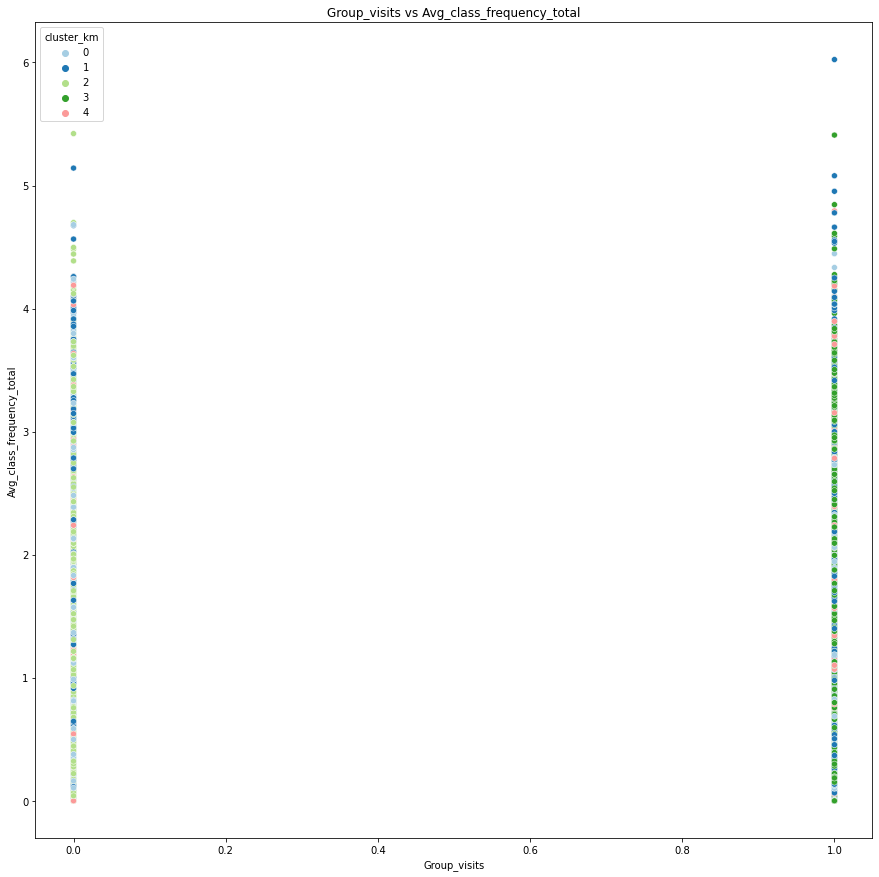

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


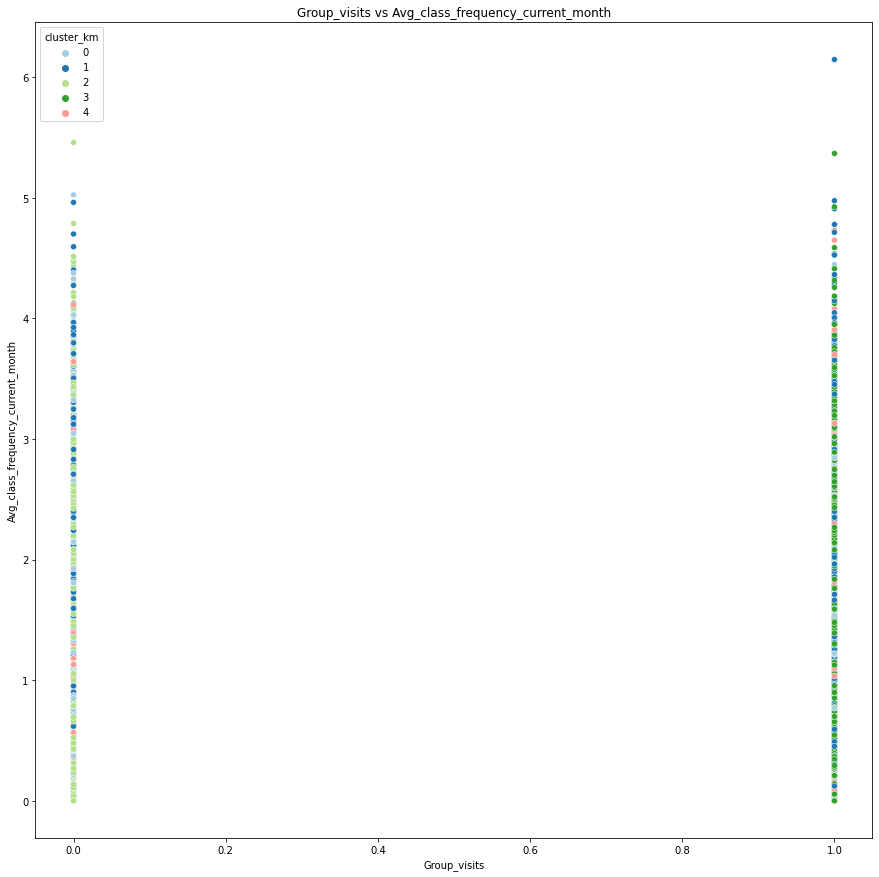

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


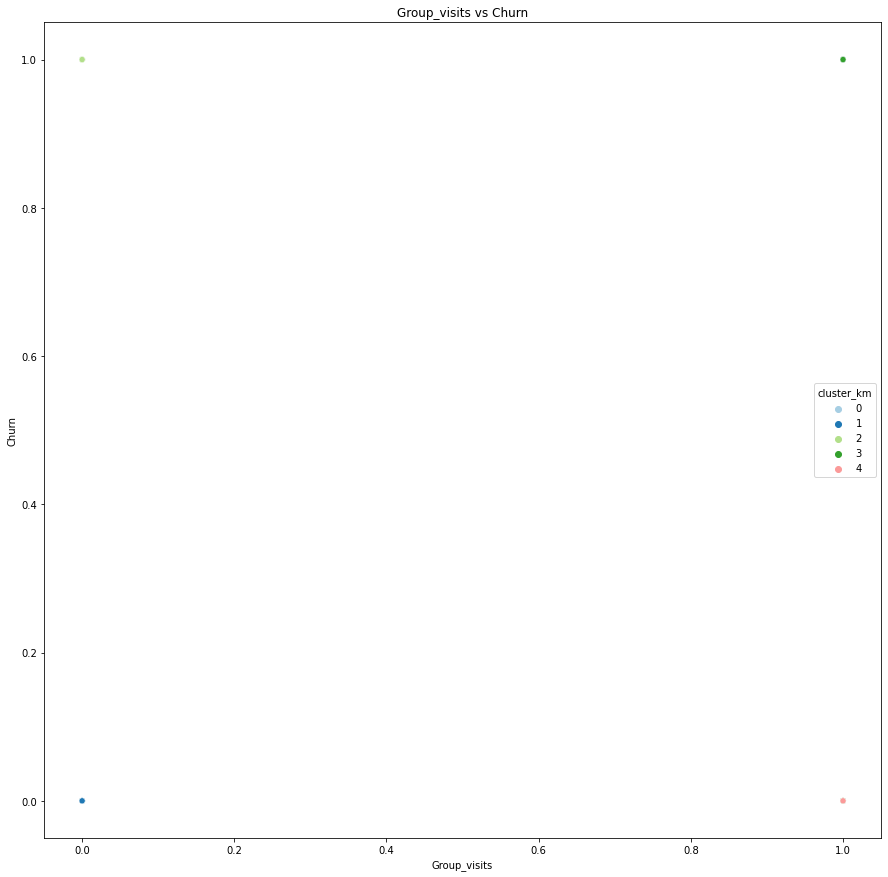

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


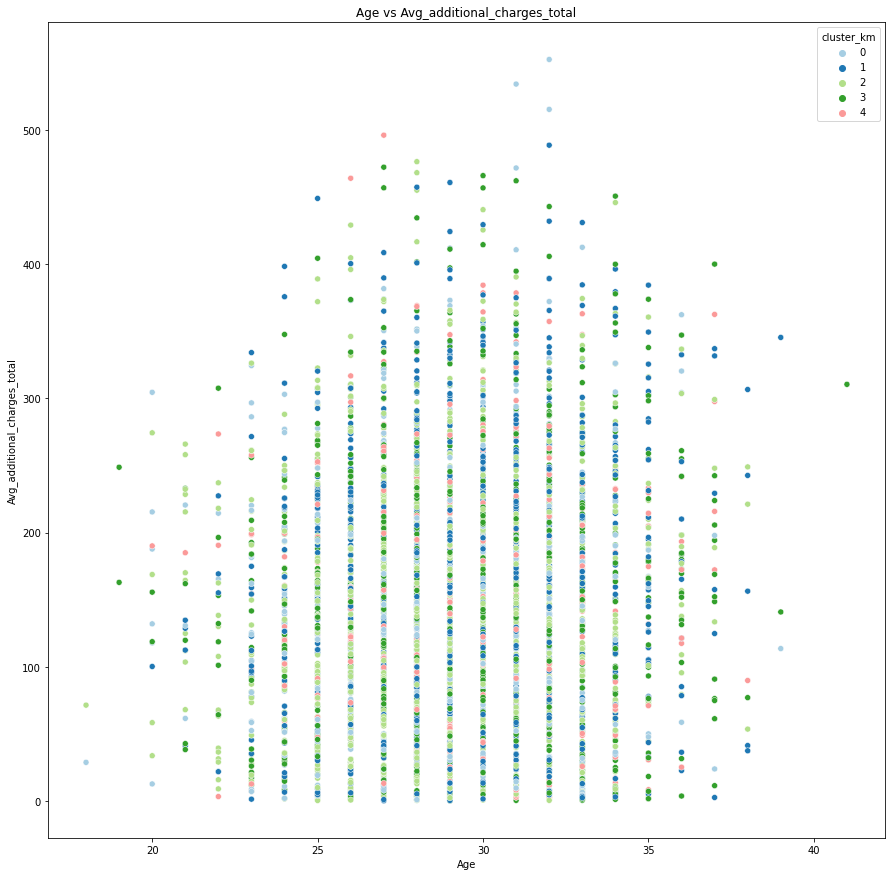

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


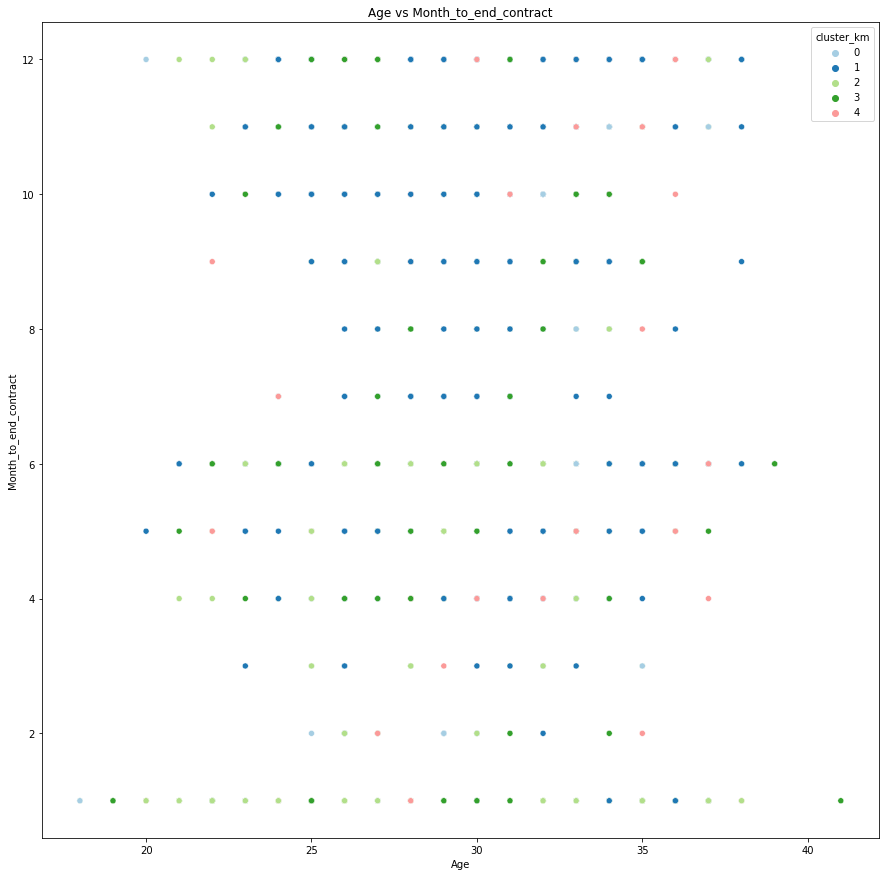

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


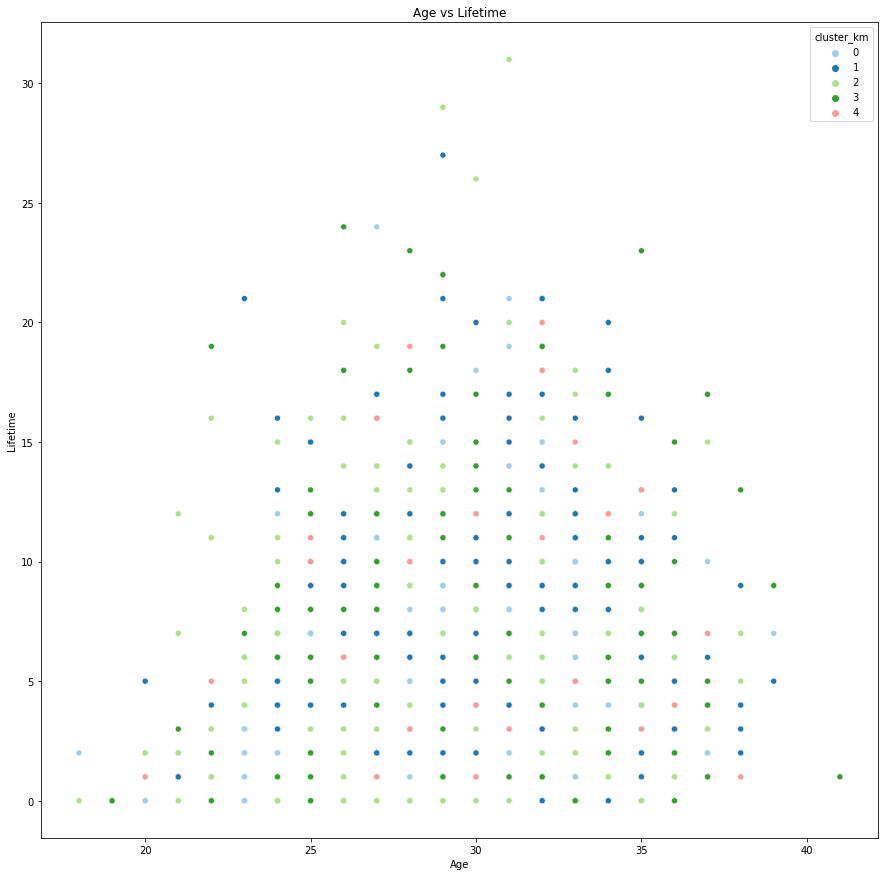

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


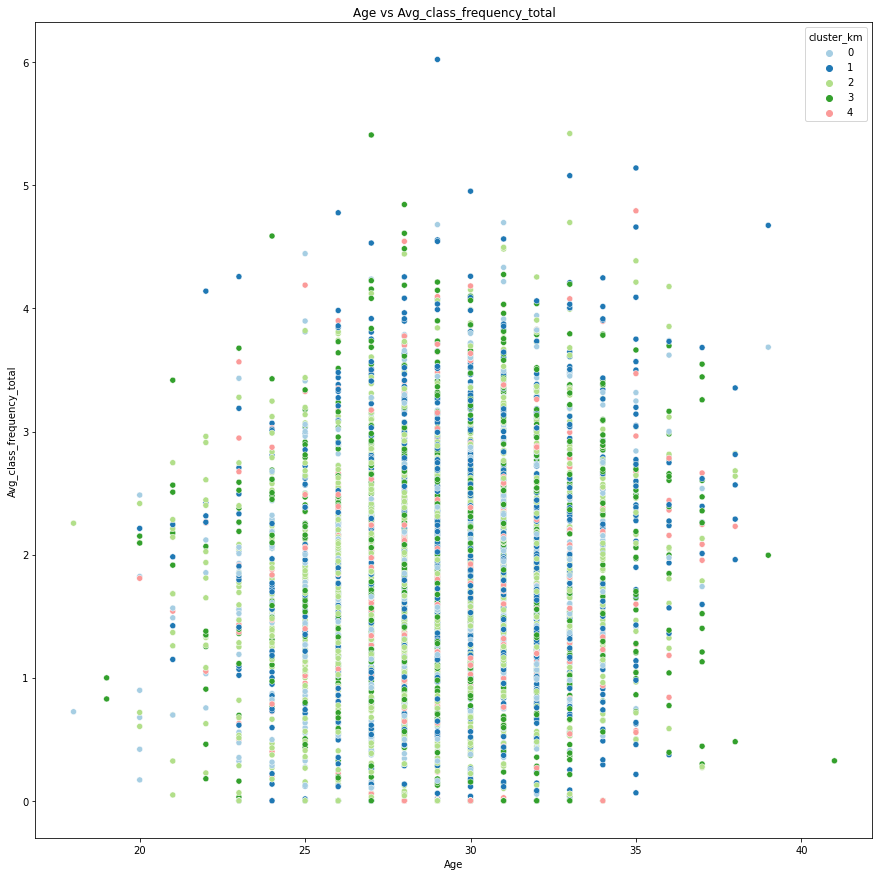

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


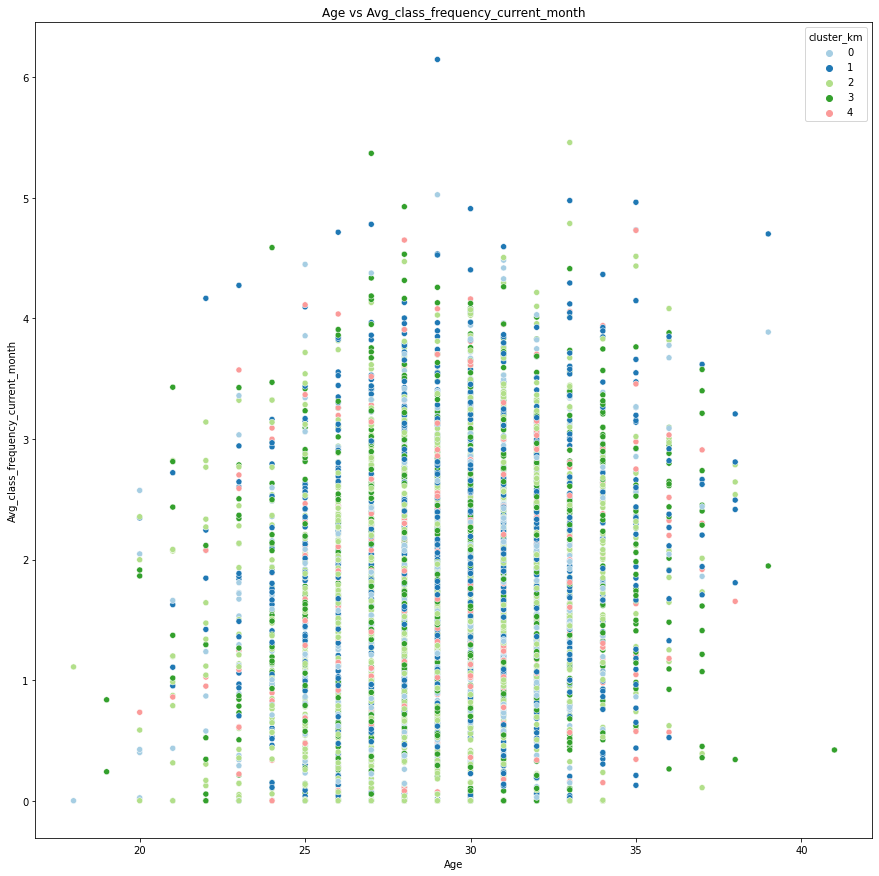

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


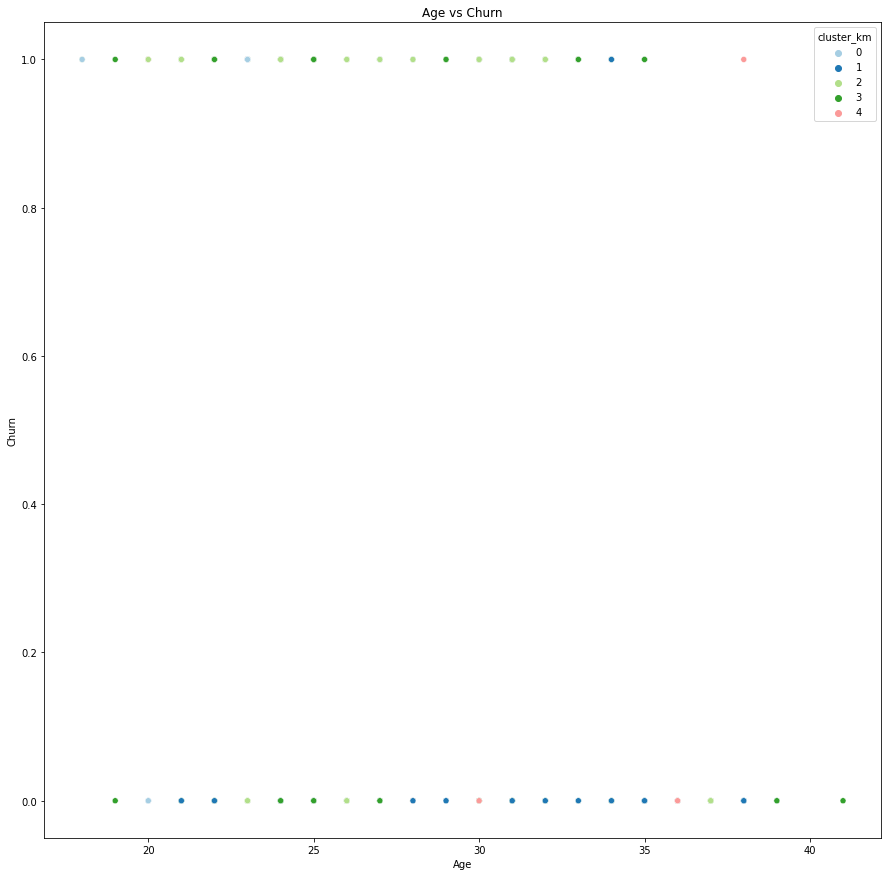

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


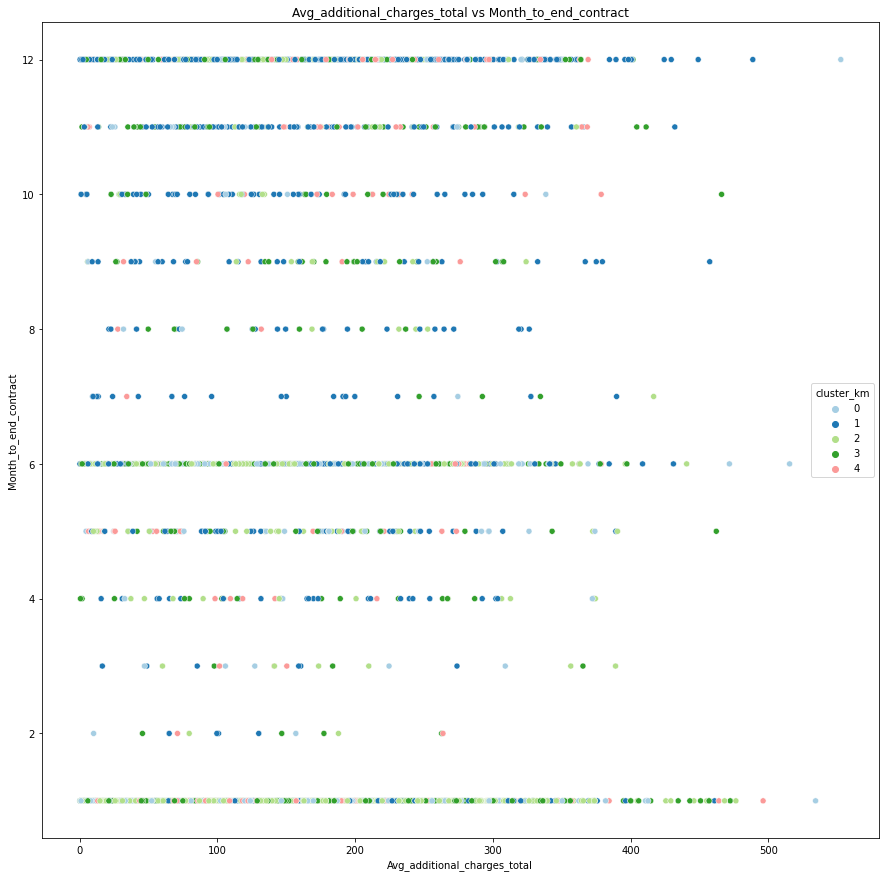

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


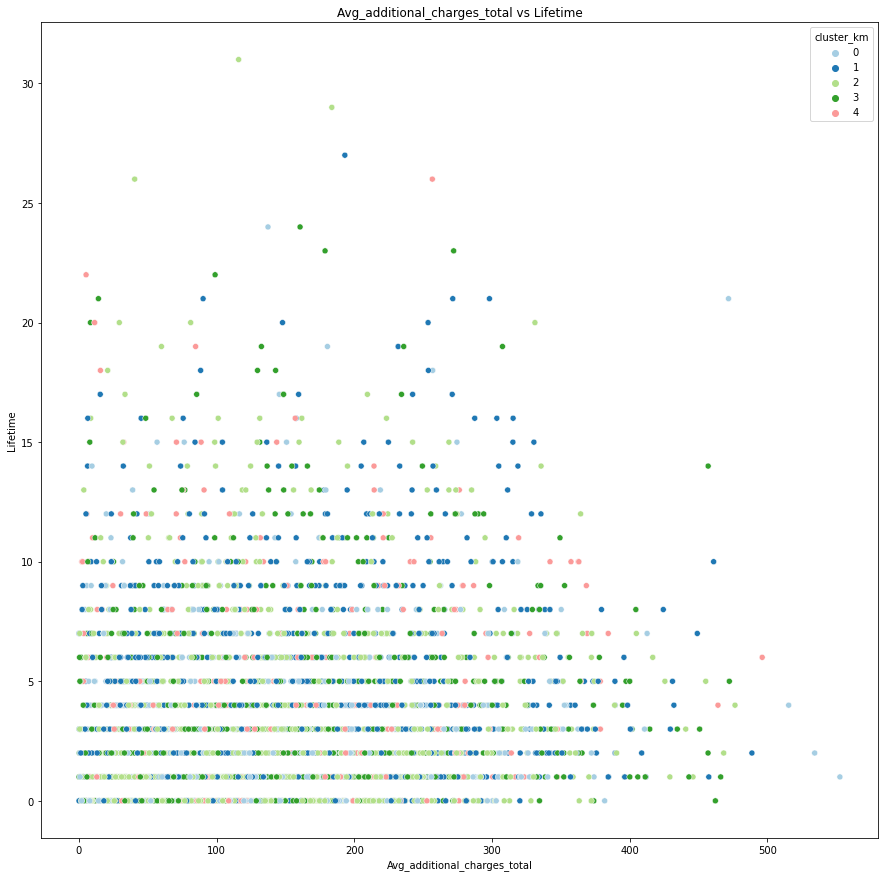

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


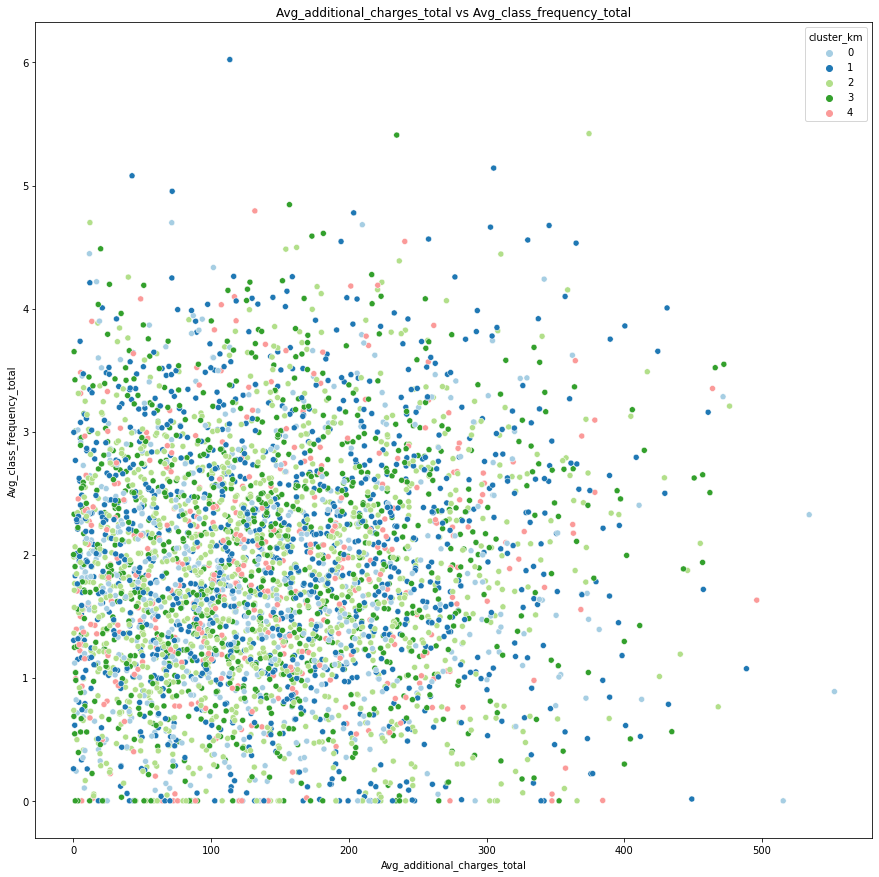

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


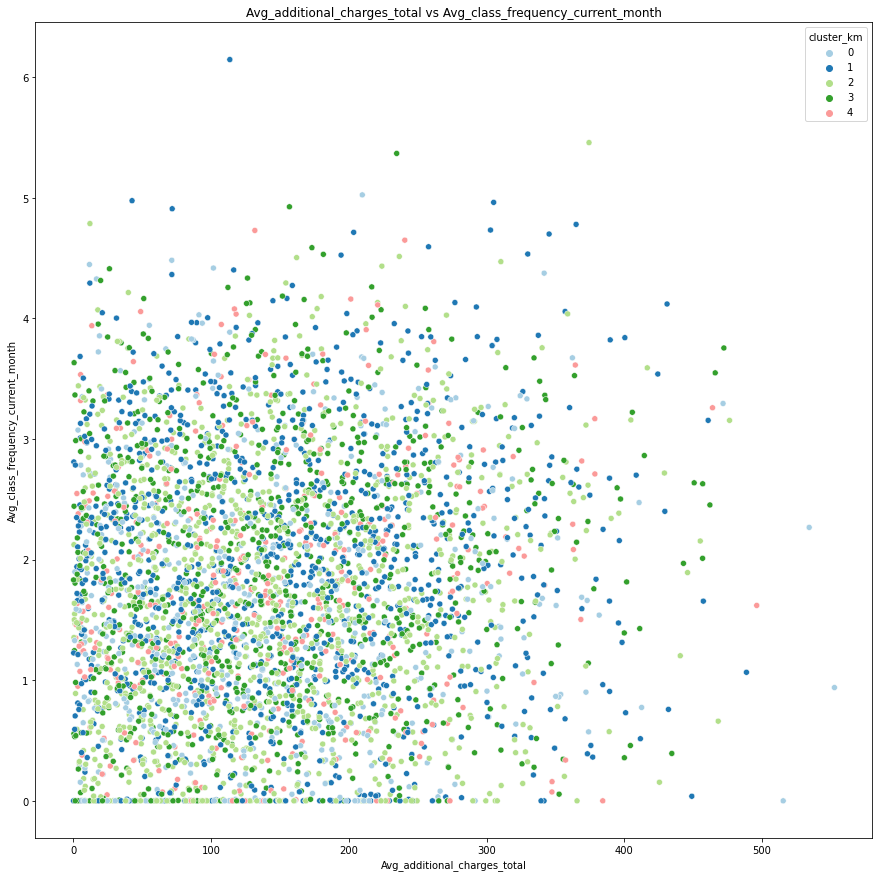

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


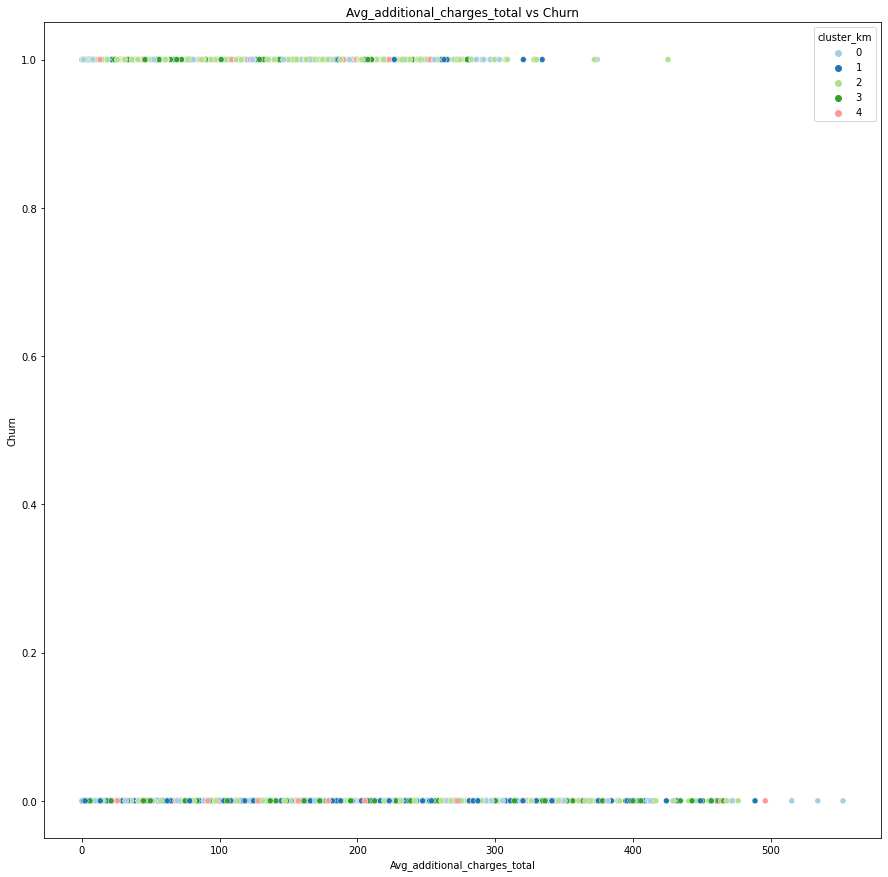

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


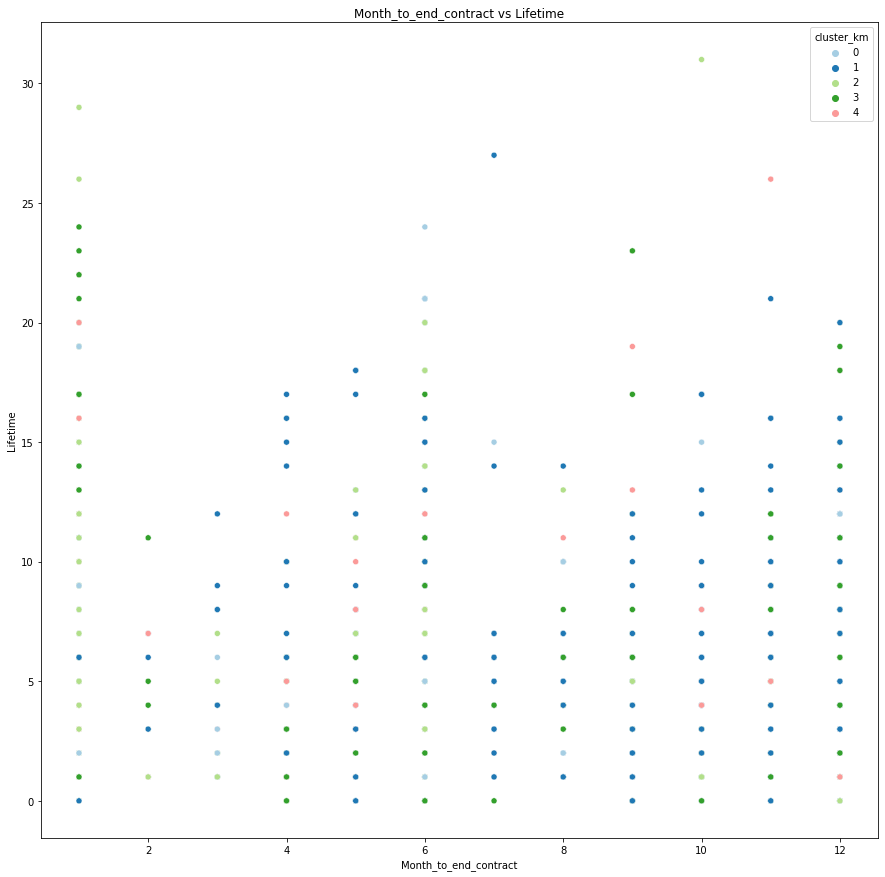

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


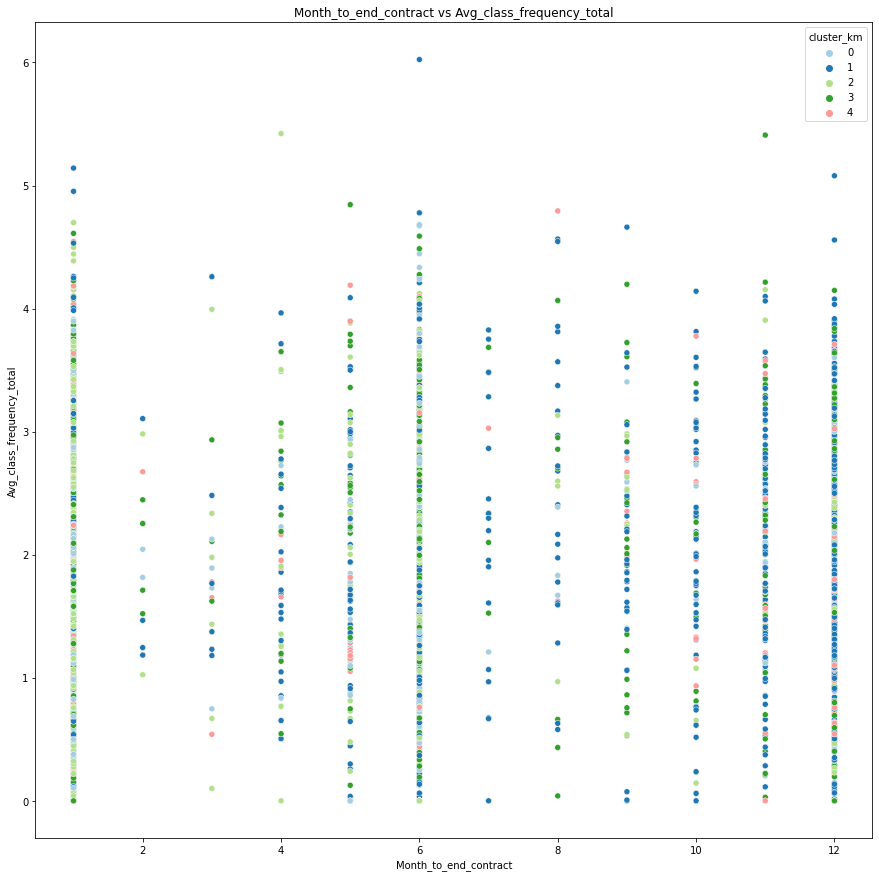

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


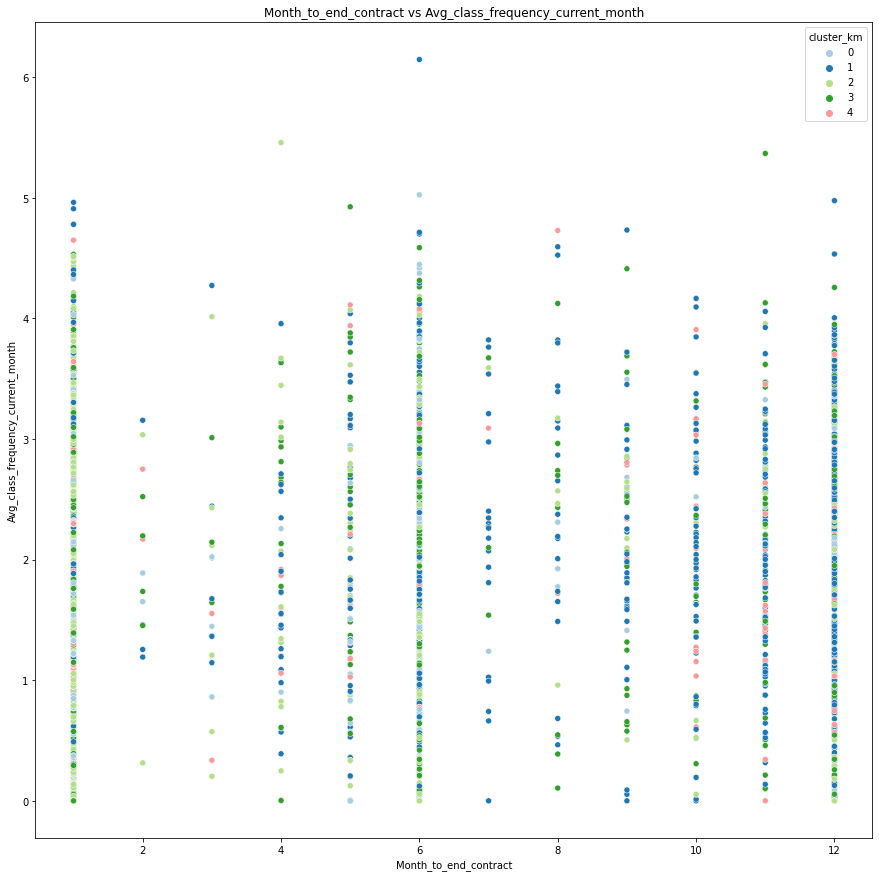

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


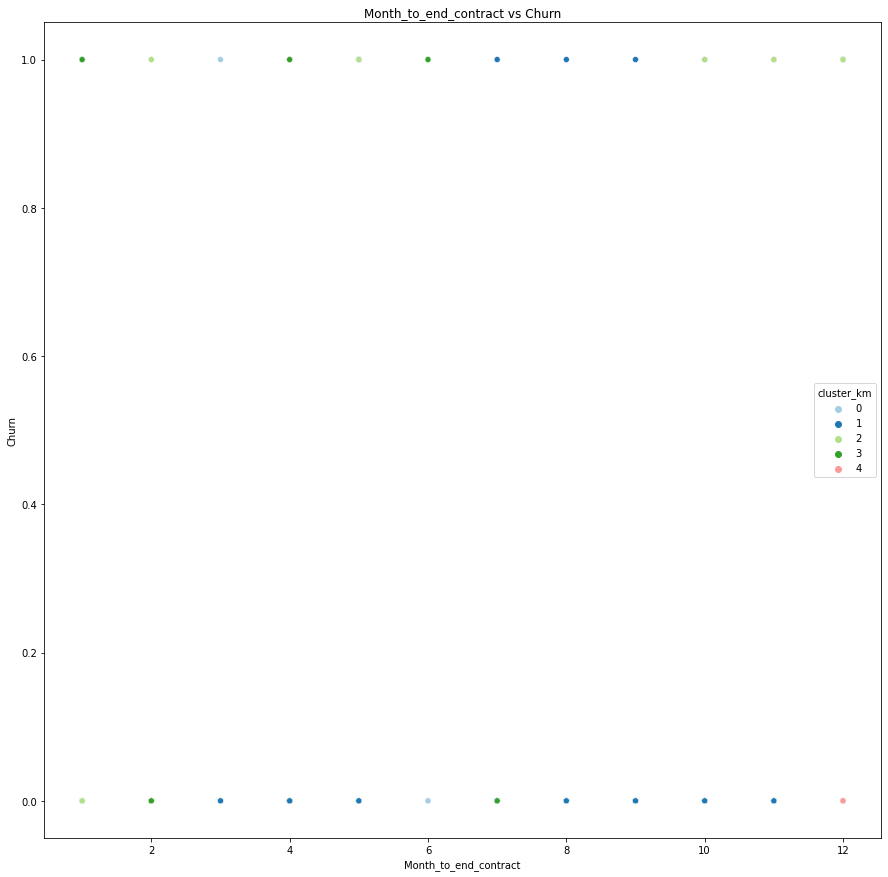

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


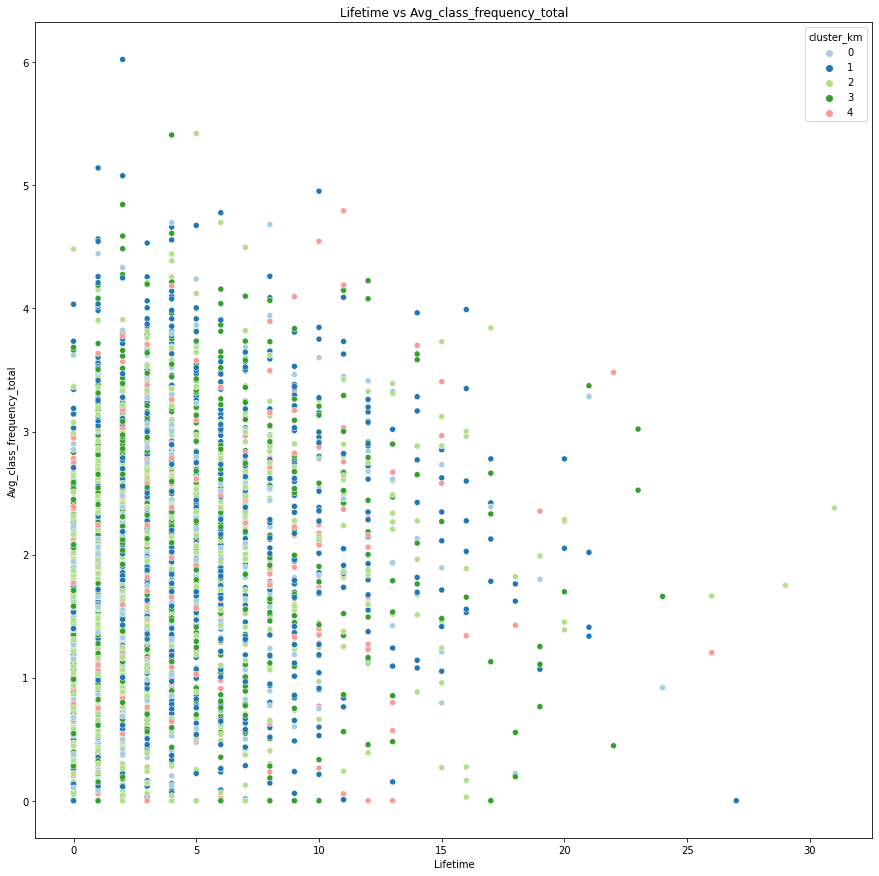

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


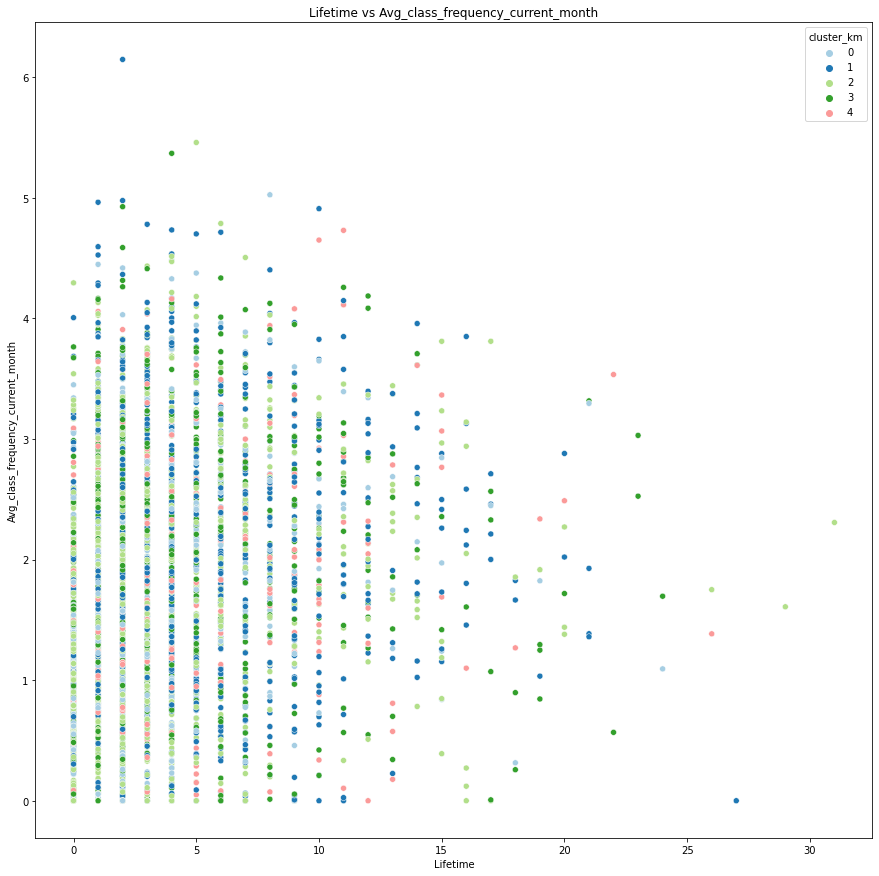

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


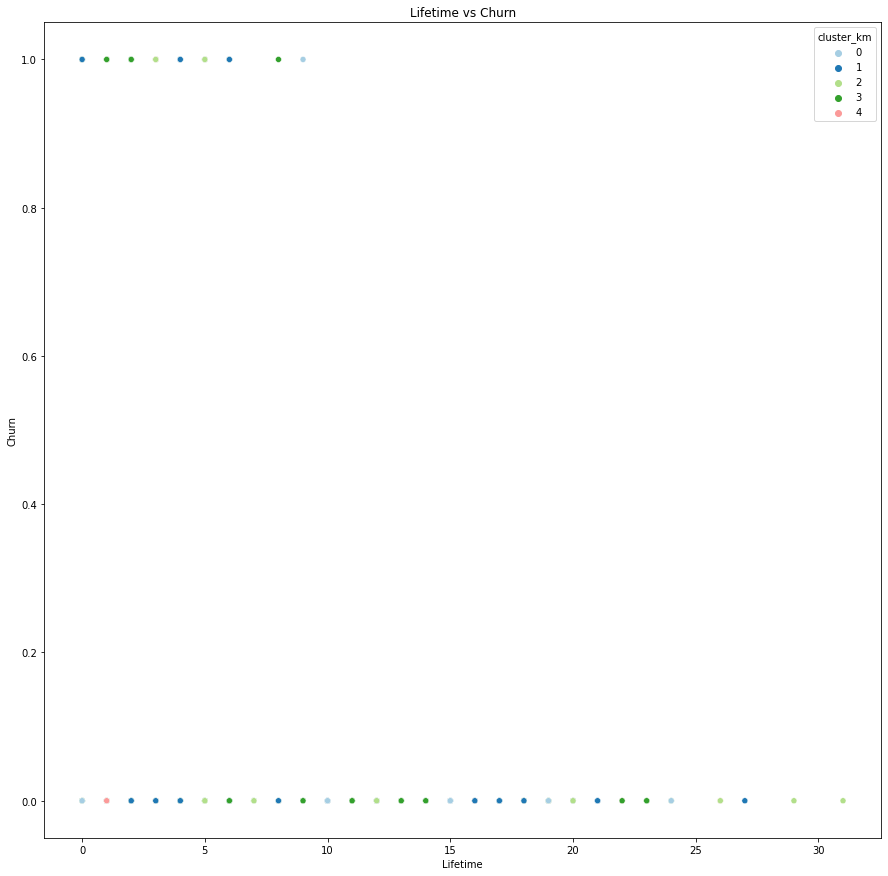

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


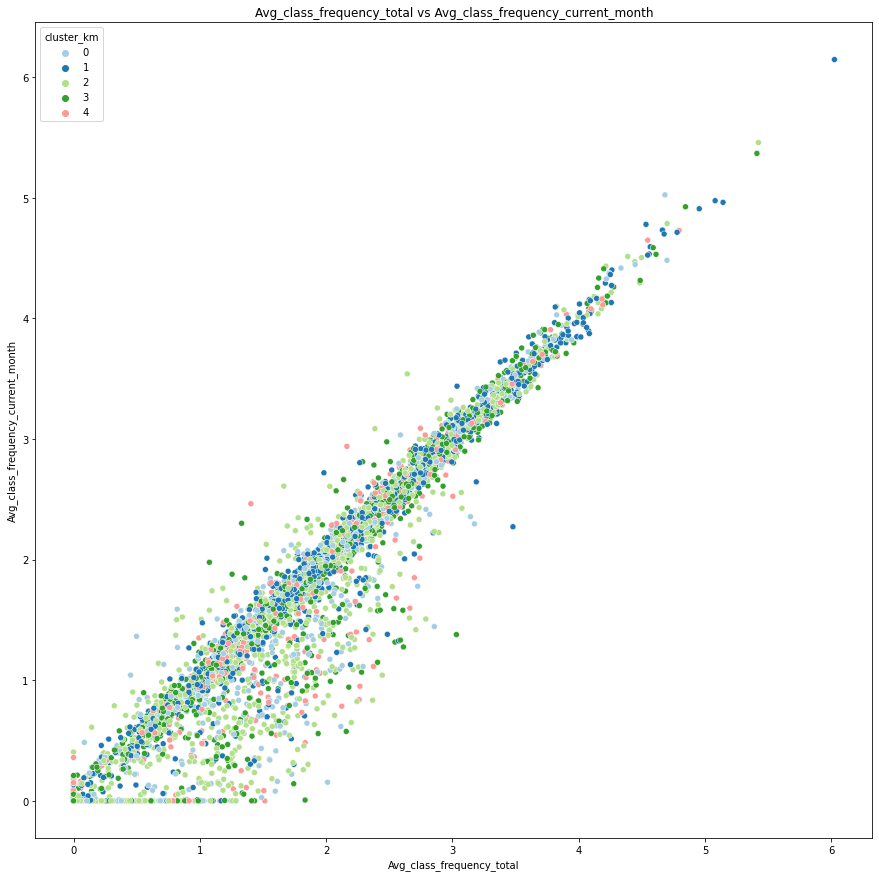

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


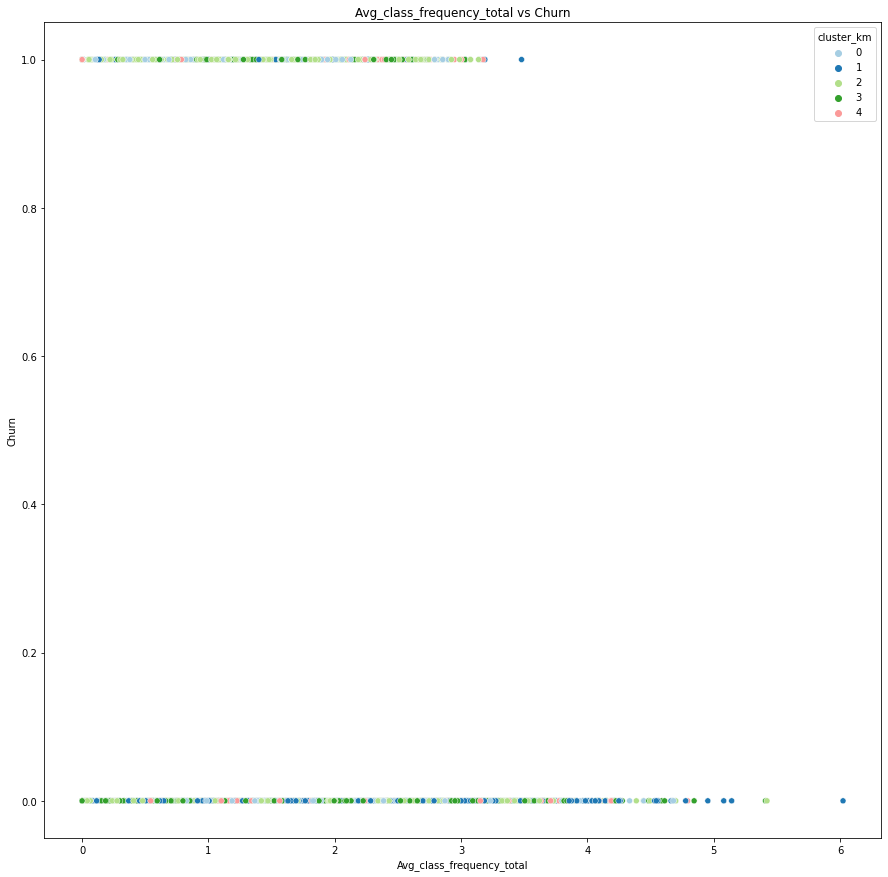

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


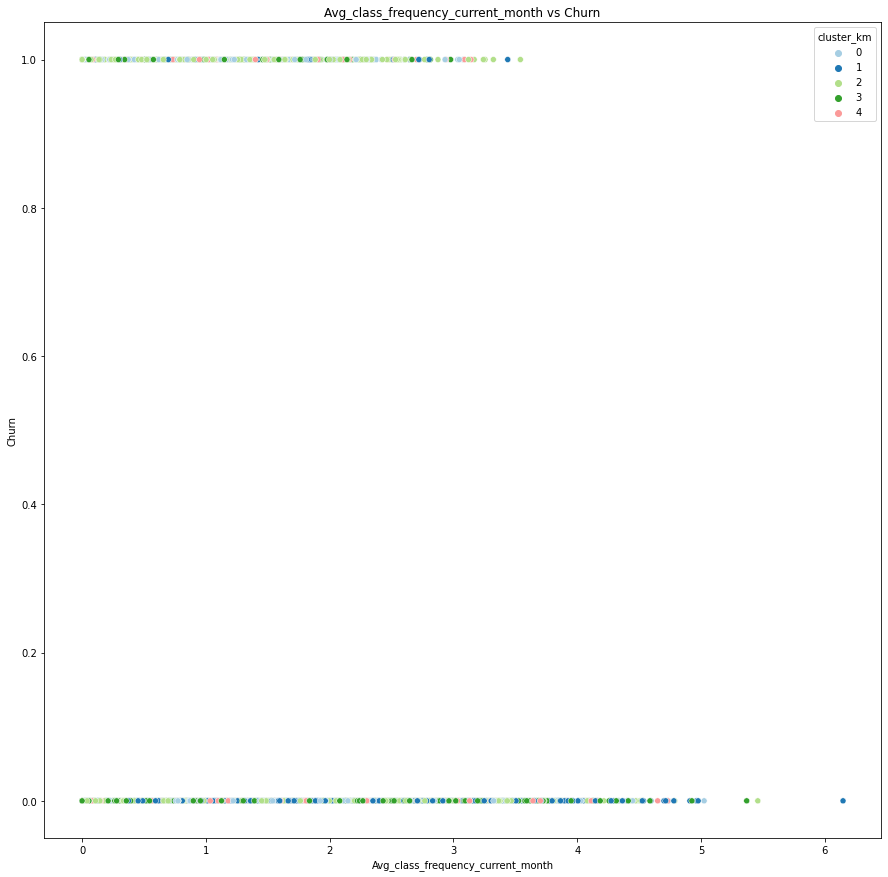

In [ ]:
# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 2)
labels = km.fit_predict(X_sc)

# сохраняем метки кластера в поле нашего датасета
data['cluster_km'] = labels

# выводим статистику по средним значениям наших признаков по кластеру
print(data.groupby('cluster_km').mean())

# отрисуем графики для попарных сочетаний признаков с разметкой по кластерам
col_pairs = list(itertools.combinations(data.drop('cluster_km', axis=1).columns, 2))
for pair in col_pairs:
    show_clusters_on_plot(data, pair[0], pair[1], 'cluster_km')

Заметны некоторые закономерности в данных:
1. Те, кто приходил по акции "приведи друга", ходят в зал чаще остальных.
2. Самая яркая зависимость видна на графике возраста и дополнительных затрат. Сформировалось определенное облако из категорий, которые чаще всего приобретают дополнительные услуги центра.
3. Чаще всего в зал ходят люди от 25 до 35 лет.
4. Больше всего трат делают те, кто купил абонемент совсем недавно.
5. Чем дольше человек посещает фитнес-центр, тем меньше денег он тратит на дополнительные услуги.
6. Ушедшие клиенты потратили в фитнес-центре меньше, чем постоянные посетители.
7. Новички ходят в зал гораздо чаще, чем те, кто посещает его на протяжении нескольких месяцев.

## Шаг 5. Сформулировать выводы и сделать базовые рекомендации по работе с клиентами

Прежде чем делать выводы, нужно оценить важнейшие признаки, которые влияют на отток клиентов.

In [ ]:
importances = model.coef_
importances = pd.DataFrame(importances)
importances.columns= ['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone', 'Contract_period','Group_visits', 'Age', 'Avg_additional_charges_total', 'Lifetime', 'Avg_class_frequency_total']
print(importances)

     gender  Near_Location  Partner  Promo_friends     Phone  Contract_period  \
0  0.048809      -0.087137 -0.05314      -0.214108 -0.116857        -1.295321   

   Group_visits       Age  Avg_additional_charges_total  Lifetime  \
0     -0.354118 -1.080316                     -0.559044 -3.785661   

   Avg_class_frequency_total  
0                  -0.719486  


Важноть признаков показывает, что чем дольше клиент посещает зал, тем меньше вероятность его ухода. Вторым важным критерием является возраст клиента, чем он старше, тем лучше, но исходя из графиков, представленных выше, целевой аудиторией лучше выбирать людей от 25 до 35 лет. Еще одним немаловажным критерием является длительность абонемента. Клиентов стоит мотивировать приобретать более длительные абонементы, чтобы у них был стимул посещать фитнес-центр. Все остальные критерии оказывают малое влияние на результаты, поэтому их можно проигнорировать. Ведь если руководство будет заниматься акцией "приведи друга", или расширением групповых программ, потребуются серьезные инвестиции, что в дальнейшем может не окку